In [1]:
import pandas as pd
import numpy as np
import pickle
import time
import datetime
from dateutil.relativedelta import relativedelta
import requests
import locale
from pandas.io.json import json_normalize
import io
import os
from os.path import exists
import sys
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import source.read_tickers_and_isins as URTI
import source.get_directors_dealings as UGDD
import source.get_timeseries as UGT
import source.analyze_get_summary_of_data as AGSOD
import source.preprocess_directors_dealings as UPDD
import source.preprocess_timeseries as UPTS
import source.preprocess_timeseries_from_excel as UPTFE
import source.analyse_single_company as UASC
import source.calculate_daily_returns_for_period as CDRFP
from source import data_checks, determine_T0_T1_T2, cut_timeseries, calculate_coefficients
import logging
logging.getLogger().setLevel(logging.WARNING)

### Load return series

In [2]:
NAME = "Niedermayer" # "Knudsen"
DATA_LOCATION = f'data/{NAME}/'
DATA_LOCATION_INSIDER_RAW = DATA_LOCATION + 'raw/insider/'
DATA_LOCATION_INSIDER_PROCESSED = DATA_LOCATION + 'processed/insider/'
DATA_LOCATION_TIME_SERIES_RAW = DATA_LOCATION + 'raw/timeseries/'
DATA_LOCATION_TIME_SERIES_PROCESSED = DATA_LOCATION + 'processed/timeseries/'
DATA_LOCATION_RI = DATA_LOCATION + 'processed/RI/'

_ri_location = DATA_LOCATION_RI
_insider_location = DATA_LOCATION_INSIDER_PROCESSED


file_locs_ = os.listdir(_ri_location)
file_locs = [_ri_location + f for f in file_locs_]

companies = []
print("loading return series...")
for file_loc in tqdm(file_locs):
    with open(file_loc, "rb") as f:
        company = pickle.load(f)
    companies.append(company)

loading return series...


100%|██████████| 2171/2171 [00:02<00:00, 1085.46it/s]


### Calculate Returns, Analyse Companies

In [3]:
print("calculate returns")
returns_df = [CDRFP.calculate_daily_returns(c.return_index_df) for c in companies]

print("concatenate")
df_returns = pd.concat(returns_df[:10000], axis=1) # TODO remove the slice
df_return_index = pd.concat([c.return_index_df for c in companies[:10]], axis=1) # TODO remove the slice

print("analyse ...")
pickles = os.listdir(DATA_LOCATION_RI)[:100] # TODO remove
ISINs = [rick[:-7] for rick in pickles]

outputs = []
for isin in tqdm(ISINs):
    outputs.append(UASC.analyse_single_company(isin, DATA_LOCATION_RI, DATA_LOCATION_INSIDER_PROCESSED))


calculate returns
concatenate
analyse ...


100%|██████████| 100/100 [00:09<00:00, 10.17it/s]


### Visualise Mean Daily Returns

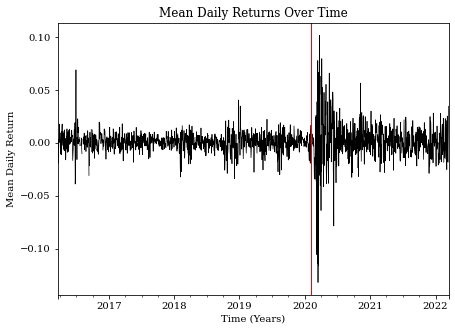

In [4]:
plt.rc('font', family='serif')
plt.rc('xtick')
plt.rc('ytick')

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

returns_companies = df_returns.mean(axis=1)
returns_companies.plot(color="k", linewidth=0.7)

ax.set_xlabel('Time (Years)')
ax.set_ylabel('Mean Daily Return')
ax.set_title('Mean Daily Returns Over Time')

interval_borders = ["2020-02-01"] # TODO see if it makes sense to actually take first of Feb

for int_ in interval_borders:
    plt.axvline(x = int_, color = 'red', label = 'DD Event time', linewidth = 1)

plt.savefig(DATA_LOCATION +"visualisations/NYSE_daily_returns.jpg", dpi=600)
plt.show()


### Investigate Filing Trade Lag Times

Negative lag for 12 out of 29688 trades.
Lag longer than 21 days for 691 out of 29688 trades.
Eligible trades: 28985 out of 29688 trades.


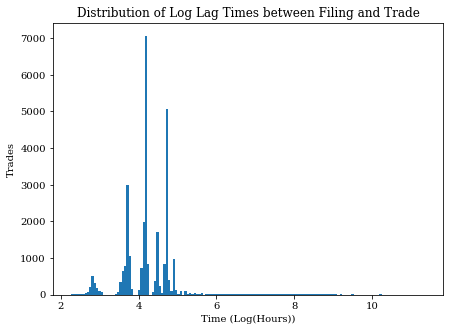

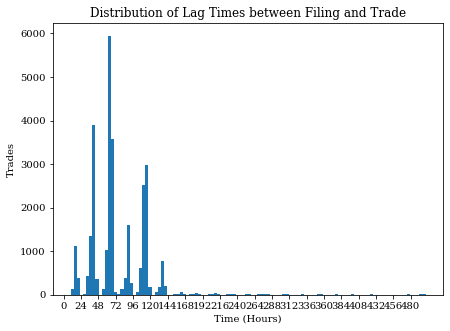

In [5]:
sum_returns = sum([x[0] for x in outputs], [])
filing_trade_lags = sum([x[1] for x in outputs], [])

lag_in_hours = np.asarray(filing_trade_lags)
negative_lag_mask = lag_in_hours < 0
positive_lag = lag_in_hours[~negative_lag_mask]
in_21_days = positive_lag < 21*24
relevant_lag = positive_lag[in_21_days]
print(f"Negative lag for {negative_lag_mask.sum()} out of {len(negative_lag_mask)} trades.")
print(f"Lag longer than 21 days for {len(positive_lag) - len(relevant_lag)} out of {len(negative_lag_mask)} trades.")
print(f"Eligible trades: {len(relevant_lag)} out of {len(negative_lag_mask)} trades.")

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
plt.hist(np.log(positive_lag), bins="auto")
ax.set_xlabel('Time (Log(Hours))')
ax.set_ylabel('Trades')
ax.set_title('Distribution of Log Lag Times between Filing and Trade')

plt.savefig(DATA_LOCATION +"visualisations/log_transformed_lags.jpg", dpi=600)
plt.show()

without_outliers = positive_lag[positive_lag < 24*21]

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
plt.hist(without_outliers, bins="auto")
plt.xticks(np.arange(0, max(without_outliers) + 1, 24))
ax.set_xlabel('Time (Hours)')
ax.set_ylabel('Trades')
ax.set_title('Distribution of Lag Times between Filing and Trade')

plt.savefig(DATA_LOCATION +"visualisations/lags_without_outliers.jpg", dpi=600)

# Get Market timeseries

In [6]:
end_time = datetime.datetime(2022, 3, 21, 23, 59, 59)
_end_time_unix = int(time.mktime(end_time.timetuple()))
print(_end_time_unix)

start_time = datetime.datetime(2016, 3, 21, 0, 0, 0)
_start_time_unix = int(time.mktime(start_time.timetuple()))

print(_start_time_unix)

if NAME == "Knudsen":
    _ticker = '%5EIXIC'
    
if NAME == "Niedermayer":
    _ticker = "%5Enya"
else:
    raise NotImplementedError
    
url = f'https://query1.finance.yahoo.com/v7/finance/download/{_ticker}?period1={_start_time_unix}&period2={_end_time_unix}&interval=1d&events=history&includeAdjustedClose=true'
market_timeseries = pd.read_csv(url)

market_timeseries = market_timeseries.set_index('Date')
market_timeseries.index = market_timeseries.index.astype('datetime64[ns]')

trading_days = market_timeseries.index
market_timeseries

1647903599
1458514800


Open          High           Low         Close  \
Date                                                                 
2016-03-21  10204.700195  10232.799805  10181.849609  10219.690430   
2016-03-22  10169.900391  10226.509766  10145.349609  10194.200195   
2016-03-23  10171.379883  10171.379883  10096.889648  10099.679688   
2016-03-24  10032.889648  10087.049805  10003.980469  10086.599609   
2016-03-28  10105.120117  10128.900391  10065.379883  10106.440430   
...                  ...           ...           ...           ...   
2022-03-15  15694.349609  15914.929688  15694.349609  15895.669922   
2022-03-16  15895.669922  16262.549805  15895.669922  16261.500000   
2022-03-17  16261.500000  16483.669922  16212.570313  16483.580078   
2022-03-18  16483.580078  16615.960938  16412.500000  16612.640625   
2022-03-21  16612.640625  16694.679688  16514.990234  16606.669922   

               Adj Close      Volume  
Date                                  
2016-03-21  10219.690430  3376600000  
2016-03-22  10194.200195  3418460000  
2016-03-23  10099.679688  3639510000  
2016-03-24  10086.599609  3407720000  
2016-03-28  10106.440430  2809090000  
...                  ...         ...  
2022-03-15  15895.669922  4331170000  
2022-03-16  16261.500000  5002240000  
2022-03-17  16483.580078  4174170000  
2022-03-18  16612.640625  6681510000  
2022-03-21  16606.669922  3961050000  

[1512 rows x 6 columns]

# Define windows

#### Our data contains multiple companies. A single company contains multiple filings and each filing is an event

![alt text](assets/images/windows.png "Title")

In [7]:
## Constants defining how long both Estimation Window and Event Window are
### Probably also input parameters to a function call, as we need loops later...
L1_length = 100
L2_length = 40 # TODO +-20 days = 40 days, right?

# Demonstrate process for a single event

### Fix a company

In [8]:

logging.getLogger().setLevel(logging.DEBUG)
company_index = -11
company = companies[company_index]
print(company)
company_return = company.return_index_df
insider_data_df = pd.read_csv(_insider_location + company.ticker + '.csv', index_col=0, parse_dates=['FilingDate', 'TradeDate'])
# TODO maybe some data sanitisation in the creation of company objects start_date and end_date have different datatypes

Company(company_type='2574ZV', isin='US98980B1035', name='ZIPRECRUITER A', ticker='ZIP', start_date=Timestamp('2021-05-26 00:00:00'), end_date=datetime.datetime(2022, 3, 16, 0, 0), return_index_df=            ReturnIndex
Date                   
2021-05-26       100.00
2021-05-27        98.82
2021-05-28        99.57
2021-05-31        99.57
2021-06-01       109.24
...                 ...
2022-03-10        97.58
2022-03-11        93.70
2022-03-14        89.67
2022-03-15        92.89
2022-03-16        96.78

[211 rows x 1 columns])


### Fix an event

In [9]:
# This date will be moved to a loop
## Define which periods we are looking at.
event_index = -200
event_timestamp = insider_data_df.FilingDate.iloc[event_index].floor("d") 
print("event timestamp: ", event_timestamp)

event timestamp:  2021-12-28 00:00:00


### Technical Checks

In [10]:
data_checks.run(L1_length, L2_length, event_timestamp, company_return, market_timeseries)

### Determine T0, T1 and T2

In [11]:
T0_, T1_, T0, T1, T2, ERROR, msg = determine_T0_T1_T2.run(L1_length, L2_length, event_timestamp, company_return, market_timeseries)

DEBUG:root:Found T1: 2021-11-29 00:00:00
DEBUG:root:Found T2: 2022-01-26 00:00:00
DEBUG:root:Found T0: 2021-07-08 00:00:00
DEBUG:root:------------------------------
DEBUG:root:Event occurred at             2021-12-28 00:00:00
DEBUG:root:Estimation Window (100 days): from 2021-07-08 00:00:00 to 2021-11-29 00:00:00
DEBUG:root:Event Window      ( 40 days): from 2021-11-29 00:00:00 to 2022-01-26 00:00:00


### Abnormal and Normal Returns

![alt text](assets/images/return_estimation.png "Title")

### Cut return timeseries into correct periods

In [12]:
windows = cut_timeseries.run(company_return, market_timeseries, T0_, T1, T1_, T2)
estimation_window_market_return, estimation_window_company_return, event_window_market_return, event_window_company_return = windows

DEBUG:root:shape before aggregating
DEBUG:root:# estimation_window_market_timeseries: (101, 6)
DEBUG:root:# estimation_window_company_timeseries: (103, 1)
DEBUG:root:# event_window_market_timeseries: (41, 6)
DEBUG:root:# event_window_company_timeseries: (43, 1)
DEBUG:root:shape after aggregating
DEBUG:root:# estimation_window_market_return: (102,)
DEBUG:root:# estimation_window_market_return: (102,)
DEBUG:root:# event_window_market_return: (42,)
DEBUG:root:# event_window_company_return: (42,)


### Calculate coefficients

In [13]:
alpha, beta = calculate_coefficients.run(estimation_window_market_return, estimation_window_company_return)

DEBUG:root:                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     11.44
Date:                Fri, 16 Sep 2022   Prob (F-statistic):            0.00103
Time:                        00:21:17   Log-Likelihood:                 209.89
No. Observations:                 102   AIC:                            -415.8
Df Residuals:                     100   BIC:                            -410.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.003      0.7

### The Abnormal Return
This is the last step of the whole process for one event

In [14]:
company_return = event_window_company_return
market_return = event_window_market_return
estimated_return = alpha + beta*market_return
abnormal_return = company_return - estimated_return
print(abnormal_return)

Date
2021-11-29   -0.004123
2021-11-30   -0.041165
2021-12-01   -0.011859
2021-12-02   -0.025141
2021-12-03   -0.055116
2021-12-06    0.003454
2021-12-07    0.017956
2021-12-08    0.015772
2021-12-09   -0.022500
2021-12-10   -0.023340
2021-12-13   -0.033331
2021-12-14   -0.028838
2021-12-15   -0.007283
2021-12-16   -0.059731
2021-12-17    0.011624
2021-12-20   -0.007290
2021-12-21    0.028136
2021-12-22   -0.006466
2021-12-23    0.003617
2021-12-24   -0.002397
2021-12-27   -0.000345
2021-12-28   -0.012568
2021-12-29   -0.015338
2021-12-30    0.028529
2021-12-31   -0.018945
2022-01-03   -0.002303
2022-01-04   -0.008448
2022-01-05   -0.067013
2022-01-06   -0.004320
2022-01-07    0.028852
2022-01-10    0.035028
2022-01-11    0.006570
2022-01-12   -0.024349
2022-01-13   -0.010355
2022-01-14   -0.024951
2022-01-17   -0.002397
2022-01-18    0.001798
2022-01-19   -0.038483
2022-01-20   -0.028796
2022-01-21   -0.041329
2022-01-24    0.012054
2022-01-25   -0.022942
dtype: float64


In [15]:
# TODO @Gunnar there is this market calendar package perhaps its nice for checks for trading/non trading days and such
#import pandas_market_calendars as mcal

# Create a calendar
#nyse = mcal.get_calendar('NYSE')

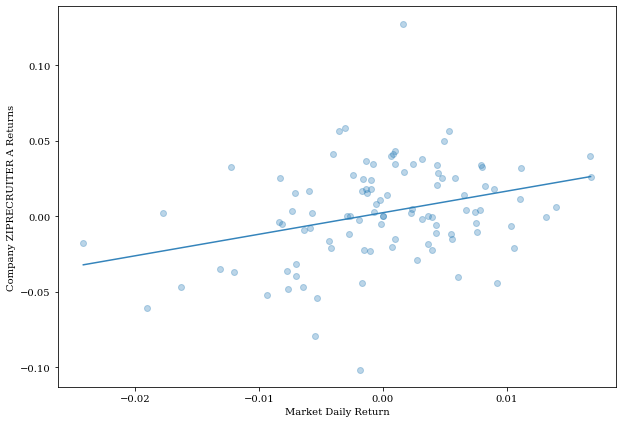

In [16]:
# I think you are the purest of garbage, and can thus be discarded
X = estimation_window_market_return.values
Y = estimation_window_company_return.values
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha
plt.figure(figsize=(10,7))
plt.scatter(X,Y, alpha = 0.3) # Plot the raw data
plt.xlabel('Market Daily Return')
plt.ylabel(f'Company {company.name} Returns')
           
plt.plot(X2, Y_hat, alpha = 0.9)
plt.show()


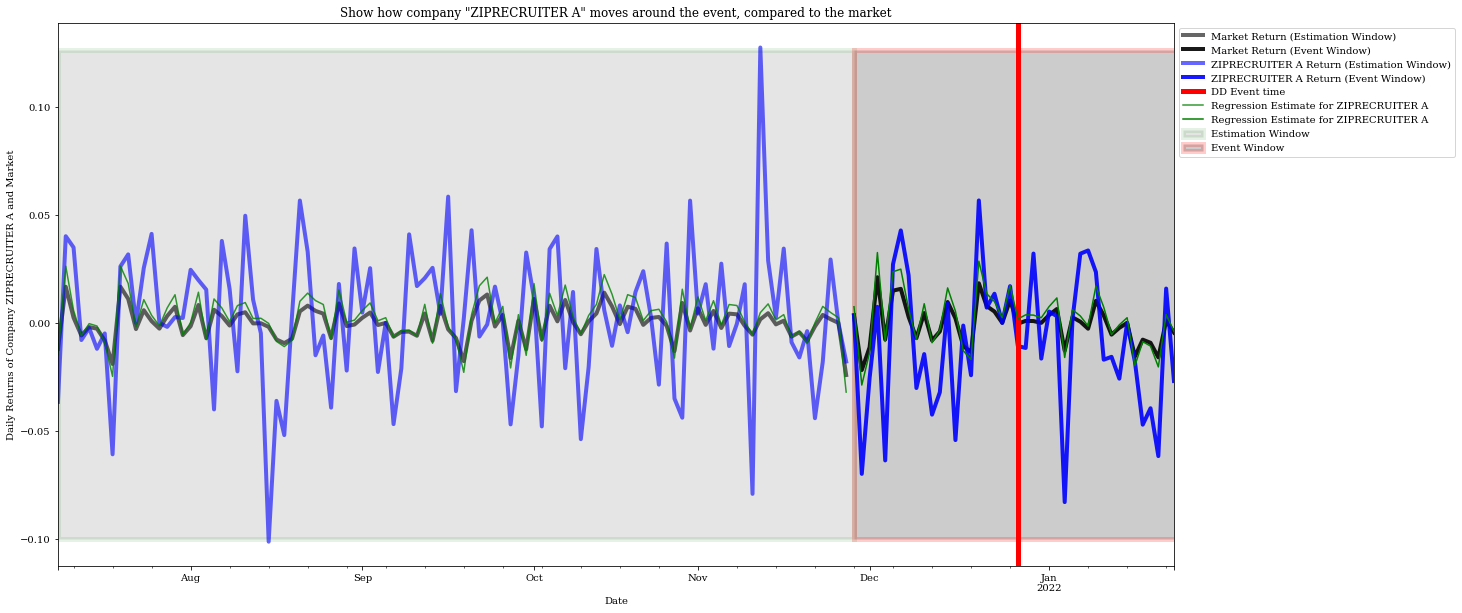

I'm impressed! It looks like a five-year-old drew this plot in paint


In [17]:
Company_name = company.name

# Estimations
est_estimation = estimation_window_market_return * beta + alpha
est_event = event_window_market_return * beta + alpha

plt.figure(figsize=(20,10))
estimation_window_market_return.plot(color = 'black', alpha = 0.6, linewidth=4, label = 'Market Return (Estimation Window)')
event_window_market_return.plot(color = 'black', alpha = 0.9, linewidth=4, label = 'Market Return (Event Window)')

estimation_window_company_return.plot(color = 'blue', alpha = 0.6, linewidth = 4, label = f'{Company_name} Return (Estimation Window)')
event_window_company_return.plot(color = 'blue', alpha = 0.9, linewidth = 4, label = f'{Company_name} Return (Event Window)')

plt.axvline(x = event_timestamp, color = 'red', label = 'DD Event time', linewidth = 5)
plt.ylabel(f'Daily Returns of Company {Company_name} and Market')
est_estimation.plot(color = 'green', label = f'Regression Estimate for {Company_name}', alpha = 0.8)
est_event.plot(color = 'green', label = f'Regression Estimate for {Company_name}', alpha = 1)

plt.axvspan(T0, T1, ymin = 0.05, ymax = 0.95, facecolor='black', alpha=0.1, label = 'Estimation Window', edgecolor='g', linewidth=5)
plt.axvspan(T1, T2, ymin = 0.05, ymax = 0.95, facecolor='black', alpha=0.2, label = 'Event Window', edgecolor='r', linewidth=5)
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')

plt.title(f'Show how company "{Company_name}" moves around the event, compared to the market')
plt.show()
print("I'm impressed! It looks like a five-year-old drew this plot in paint")


# Macro Analysis

### Now that we have seen the process for one single filing, let us do the same for all filings in all companies


In [ ]:
from source.data_checks import DataSizeException
from source.determine_T0_T1_T2 import TimeSeriesMismatchException
logging.getLogger().setLevel(logging.ERROR)
multiind, data, data_errors = [], [], []

# this is the interval where filings are interesting to us
earliest_timestamp = pd.Timestamp("2018-01-01")
latest_timestamp = pd.Timestamp("2021-12-31")
n_companies = len(companies)
for j in range(len(companies)):
    company = companies[j]
    company_return = company.return_index_df
    insider_data_df = pd.read_csv(_insider_location + company.ticker + '.csv', index_col=0, parse_dates=['FilingDate', 'TradeDate'])
    
    
    n_filings = len(insider_data_df)
    for i in insider_data_df.FilingDate.index:
        
        
        filing_date = insider_data_df.FilingDate[i]
        
        event_timestamp = filing_date.floor("d")

        # if the timestamp is too early or too late we skip
        if event_timestamp < earliest_timestamp or event_timestamp > latest_timestamp:
            #print("skipping, filing is too early or too late")
            continue
            
            
        print(f"working on company {j}/{n_companies} named {company.name}, filing {i}/{n_filings}")

        # do the process for one filing
 
        checks = data_checks.run(L1_length, L2_length, event_timestamp, company_return, market_timeseries)
        if checks:
            print(checks[1])
            data_errors.append(checks[0])
            continue
   
        T0_, T1_, T0, T1, T2, ERRORS, msg = determine_T0_T1_T2.run(L1_length, L2_length, event_timestamp, company_return, market_timeseries)
        if ERRORS:
            print(msg)
            data_errors.append(ERRORS)
            continue
            
        
        windows = cut_timeseries.run(company_return, market_timeseries, T0_, T1, T1_, T2)
        estimation_window_market_return, estimation_window_company_return, event_window_market_return, event_window_company_return = windows
        alpha, beta = calculate_coefficients.run(estimation_window_market_return, estimation_window_company_return)

        abnormal_return = event_window_company_return - alpha - beta*event_window_market_return
        
        multiind.append((company.ticker, i, insider_data_df.TradeType[i]))
        data.append(abnormal_return)


working on company 0/2171 named SCHLUMBERGER, filing 59/1079
working on company 0/2171 named SCHLUMBERGER, filing 60/1079
working on company 0/2171 named SCHLUMBERGER, filing 61/1079
working on company 0/2171 named SCHLUMBERGER, filing 62/1079
working on company 0/2171 named SCHLUMBERGER, filing 63/1079
working on company 0/2171 named SCHLUMBERGER, filing 64/1079
working on company 0/2171 named SCHLUMBERGER, filing 65/1079
working on company 0/2171 named SCHLUMBERGER, filing 66/1079
working on company 0/2171 named SCHLUMBERGER, filing 67/1079
working on company 0/2171 named SCHLUMBERGER, filing 68/1079
working on company 0/2171 named SCHLUMBERGER, filing 69/1079
working on company 0/2171 named SCHLUMBERGER, filing 70/1079
working on company 0/2171 named SCHLUMBERGER, filing 71/1079
working on company 0/2171 named SCHLUMBERGER, filing 72/1079
working on company 0/2171 named SCHLUMBERGER, filing 73/1079
working on company 0/2171 named SCHLUMBERGER, filing 74/1079
working on company 0/217

working on company 0/2171 named SCHLUMBERGER, filing 199/1079
working on company 0/2171 named SCHLUMBERGER, filing 200/1079
working on company 0/2171 named SCHLUMBERGER, filing 201/1079
working on company 0/2171 named SCHLUMBERGER, filing 202/1079
working on company 0/2171 named SCHLUMBERGER, filing 203/1079
working on company 0/2171 named SCHLUMBERGER, filing 204/1079
working on company 0/2171 named SCHLUMBERGER, filing 205/1079
working on company 0/2171 named SCHLUMBERGER, filing 206/1079
working on company 0/2171 named SCHLUMBERGER, filing 207/1079
working on company 0/2171 named SCHLUMBERGER, filing 208/1079
working on company 0/2171 named SCHLUMBERGER, filing 209/1079
working on company 0/2171 named SCHLUMBERGER, filing 210/1079
working on company 0/2171 named SCHLUMBERGER, filing 211/1079
working on company 0/2171 named SCHLUMBERGER, filing 212/1079
working on company 0/2171 named SCHLUMBERGER, filing 213/1079
working on company 0/2171 named SCHLUMBERGER, filing 214/1079
working 

working on company 0/2171 named SCHLUMBERGER, filing 347/1079
working on company 0/2171 named SCHLUMBERGER, filing 348/1079
working on company 0/2171 named SCHLUMBERGER, filing 349/1079
working on company 0/2171 named SCHLUMBERGER, filing 350/1079
working on company 0/2171 named SCHLUMBERGER, filing 351/1079
working on company 0/2171 named SCHLUMBERGER, filing 352/1079
working on company 0/2171 named SCHLUMBERGER, filing 353/1079
working on company 0/2171 named SCHLUMBERGER, filing 354/1079
working on company 0/2171 named SCHLUMBERGER, filing 355/1079
working on company 0/2171 named SCHLUMBERGER, filing 356/1079
working on company 0/2171 named SCHLUMBERGER, filing 357/1079
working on company 0/2171 named SCHLUMBERGER, filing 358/1079
working on company 0/2171 named SCHLUMBERGER, filing 359/1079
working on company 0/2171 named SCHLUMBERGER, filing 360/1079
working on company 0/2171 named SCHLUMBERGER, filing 361/1079
working on company 0/2171 named SCHLUMBERGER, filing 362/1079
working 

working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 85/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 86/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 87/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 88/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 89/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 90/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 91/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 92/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 93/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 94/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 95/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 96/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 97/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 98/643
working on company 2/2171 named AR

working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 208/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 209/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 210/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 211/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 212/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 213/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 214/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 215/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 216/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 217/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 218/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 219/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 220/643
working on company 2/2171 named ARGO GP.INTL.HOLDINGS, filing 221/643
working on company 2

working on company 3/2171 named ASPEN IN.HDG. DEAD - DELIST.16/02/19, filing 29/611
working on company 3/2171 named ASPEN IN.HDG. DEAD - DELIST.16/02/19, filing 30/611
working on company 3/2171 named ASPEN IN.HDG. DEAD - DELIST.16/02/19, filing 31/611
working on company 3/2171 named ASPEN IN.HDG. DEAD - DELIST.16/02/19, filing 32/611
working on company 3/2171 named ASPEN IN.HDG. DEAD - DELIST.16/02/19, filing 33/611
working on company 3/2171 named ASPEN IN.HDG. DEAD - DELIST.16/02/19, filing 34/611
working on company 3/2171 named ASPEN IN.HDG. DEAD - DELIST.16/02/19, filing 35/611
working on company 3/2171 named ASPEN IN.HDG. DEAD - DELIST.16/02/19, filing 36/611
working on company 3/2171 named ASPEN IN.HDG. DEAD - DELIST.16/02/19, filing 37/611
working on company 3/2171 named ASPEN IN.HDG. DEAD - DELIST.16/02/19, filing 38/611
working on company 3/2171 named ASPEN IN.HDG. DEAD - DELIST.16/02/19, filing 39/611
working on company 3/2171 named ASPEN IN.HDG. DEAD - DELIST.16/02/19, filing

working on company 4/2171 named ASSURED GUARANTY, filing 65/1472
working on company 4/2171 named ASSURED GUARANTY, filing 66/1472
working on company 4/2171 named ASSURED GUARANTY, filing 67/1472
working on company 4/2171 named ASSURED GUARANTY, filing 68/1472
working on company 4/2171 named ASSURED GUARANTY, filing 69/1472
working on company 4/2171 named ASSURED GUARANTY, filing 70/1472
working on company 4/2171 named ASSURED GUARANTY, filing 71/1472
working on company 4/2171 named ASSURED GUARANTY, filing 72/1472
working on company 4/2171 named ASSURED GUARANTY, filing 73/1472
working on company 4/2171 named ASSURED GUARANTY, filing 74/1472
working on company 4/2171 named ASSURED GUARANTY, filing 75/1472
working on company 4/2171 named ASSURED GUARANTY, filing 76/1472
working on company 4/2171 named ASSURED GUARANTY, filing 77/1472
working on company 4/2171 named ASSURED GUARANTY, filing 78/1472
working on company 4/2171 named ASSURED GUARANTY, filing 79/1472
working on company 4/2171

working on company 4/2171 named ASSURED GUARANTY, filing 193/1472
working on company 4/2171 named ASSURED GUARANTY, filing 194/1472
working on company 4/2171 named ASSURED GUARANTY, filing 195/1472
working on company 4/2171 named ASSURED GUARANTY, filing 196/1472
working on company 4/2171 named ASSURED GUARANTY, filing 197/1472
working on company 4/2171 named ASSURED GUARANTY, filing 198/1472
working on company 4/2171 named ASSURED GUARANTY, filing 199/1472
working on company 4/2171 named ASSURED GUARANTY, filing 200/1472
working on company 4/2171 named ASSURED GUARANTY, filing 201/1472
working on company 4/2171 named ASSURED GUARANTY, filing 202/1472
working on company 4/2171 named ASSURED GUARANTY, filing 203/1472
working on company 4/2171 named ASSURED GUARANTY, filing 204/1472
working on company 4/2171 named ASSURED GUARANTY, filing 205/1472
working on company 4/2171 named ASSURED GUARANTY, filing 206/1472
working on company 4/2171 named ASSURED GUARANTY, filing 207/1472
working on

working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 34/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 35/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 36/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 37/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 38/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 39/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 40/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 41/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 42/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 43/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 44/290
working on company 5/2171 named ATHENE HOLD

working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 137/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 138/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 139/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 140/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 141/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 142/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 143/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 144/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 145/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 146/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 147/290
working on company 5/2171 named 

working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 243/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 244/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 245/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 246/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 247/290
working on company 5/2171 named ATHENE HOLDING A DEAD - DELIST.03/01/22, filing 248/290
working on company 6/2171 named AXIS CAPITAL HDG., filing 26/832
working on company 6/2171 named AXIS CAPITAL HDG., filing 27/832
working on company 6/2171 named AXIS CAPITAL HDG., filing 28/832
working on company 6/2171 named AXIS CAPITAL HDG., filing 29/832
working on company 6/2171 named AXIS CAPITAL HDG., filing 30/832
working on company 6/2171 named AXIS CAPITAL HDG., filing 31/832
working on company 6/2171 named AXIS CAPITAL HDG., filing 32/832
working on compan

working on company 6/2171 named AXIS CAPITAL HDG., filing 164/832
working on company 6/2171 named AXIS CAPITAL HDG., filing 165/832
working on company 6/2171 named AXIS CAPITAL HDG., filing 166/832
working on company 6/2171 named AXIS CAPITAL HDG., filing 167/832
working on company 6/2171 named AXIS CAPITAL HDG., filing 168/832
working on company 6/2171 named AXIS CAPITAL HDG., filing 169/832
working on company 6/2171 named AXIS CAPITAL HDG., filing 170/832
working on company 6/2171 named AXIS CAPITAL HDG., filing 171/832
working on company 6/2171 named AXIS CAPITAL HDG., filing 172/832
working on company 6/2171 named AXIS CAPITAL HDG., filing 173/832
working on company 6/2171 named AXIS CAPITAL HDG., filing 174/832
working on company 6/2171 named AXIS CAPITAL HDG., filing 175/832
working on company 6/2171 named AXIS CAPITAL HDG., filing 176/832
working on company 6/2171 named AXIS CAPITAL HDG., filing 177/832
working on company 6/2171 named AXIS CAPITAL HDG., filing 178/832
working on

working on company 7/2171 named AXALTA COATING SYSTEMS, filing 132/477
working on company 7/2171 named AXALTA COATING SYSTEMS, filing 133/477
working on company 7/2171 named AXALTA COATING SYSTEMS, filing 134/477
working on company 7/2171 named AXALTA COATING SYSTEMS, filing 135/477
working on company 7/2171 named AXALTA COATING SYSTEMS, filing 136/477
working on company 7/2171 named AXALTA COATING SYSTEMS, filing 137/477
working on company 7/2171 named AXALTA COATING SYSTEMS, filing 138/477
working on company 7/2171 named AXALTA COATING SYSTEMS, filing 139/477
working on company 7/2171 named AXALTA COATING SYSTEMS, filing 140/477
working on company 7/2171 named AXALTA COATING SYSTEMS, filing 141/477
working on company 7/2171 named AXALTA COATING SYSTEMS, filing 142/477
working on company 7/2171 named AXALTA COATING SYSTEMS, filing 143/477
working on company 7/2171 named AXALTA COATING SYSTEMS, filing 144/477
working on company 7/2171 named AXALTA COATING SYSTEMS, filing 145/477
workin

working on company 7/2171 named AXALTA COATING SYSTEMS, filing 260/477
working on company 7/2171 named AXALTA COATING SYSTEMS, filing 261/477
working on company 7/2171 named AXALTA COATING SYSTEMS, filing 262/477
working on company 7/2171 named AXALTA COATING SYSTEMS, filing 263/477
working on company 7/2171 named AXALTA COATING SYSTEMS, filing 264/477
working on company 7/2171 named AXALTA COATING SYSTEMS, filing 265/477
working on company 7/2171 named AXALTA COATING SYSTEMS, filing 266/477
working on company 7/2171 named AXALTA COATING SYSTEMS, filing 267/477
working on company 7/2171 named AXALTA COATING SYSTEMS, filing 268/477
working on company 12/2171 named BUNGE, filing 45/1638
working on company 12/2171 named BUNGE, filing 46/1638
working on company 12/2171 named BUNGE, filing 47/1638
working on company 12/2171 named BUNGE, filing 48/1638
working on company 12/2171 named BUNGE, filing 49/1638
working on company 12/2171 named BUNGE, filing 50/1638
working on company 12/2171 name

working on company 12/2171 named BUNGE, filing 184/1638
working on company 12/2171 named BUNGE, filing 185/1638
working on company 12/2171 named BUNGE, filing 186/1638
working on company 12/2171 named BUNGE, filing 187/1638
working on company 12/2171 named BUNGE, filing 188/1638
working on company 12/2171 named BUNGE, filing 189/1638
working on company 12/2171 named BUNGE, filing 190/1638
working on company 12/2171 named BUNGE, filing 191/1638
working on company 12/2171 named BUNGE, filing 192/1638
working on company 12/2171 named BUNGE, filing 193/1638
working on company 12/2171 named BUNGE, filing 194/1638
working on company 12/2171 named BUNGE, filing 195/1638
working on company 12/2171 named BUNGE, filing 196/1638
working on company 12/2171 named BUNGE, filing 197/1638
working on company 12/2171 named BUNGE, filing 198/1638
working on company 12/2171 named BUNGE, filing 199/1638
working on company 12/2171 named BUNGE, filing 200/1638
working on company 12/2171 named BUNGE, filing 2

working on company 12/2171 named BUNGE, filing 334/1638
working on company 12/2171 named BUNGE, filing 335/1638
working on company 12/2171 named BUNGE, filing 336/1638
working on company 12/2171 named BUNGE, filing 337/1638
working on company 12/2171 named BUNGE, filing 338/1638
working on company 12/2171 named BUNGE, filing 339/1638
working on company 12/2171 named BUNGE, filing 340/1638
working on company 12/2171 named BUNGE, filing 341/1638
working on company 12/2171 named BUNGE, filing 342/1638
working on company 12/2171 named BUNGE, filing 343/1638
working on company 12/2171 named BUNGE, filing 344/1638
working on company 12/2171 named BUNGE, filing 345/1638
working on company 12/2171 named BUNGE, filing 346/1638
working on company 12/2171 named BUNGE, filing 347/1638
working on company 12/2171 named BUNGE, filing 348/1638
working on company 12/2171 named BUNGE, filing 349/1638
working on company 12/2171 named BUNGE, filing 350/1638
working on company 12/2171 named BUNGE, filing 3

working on company 12/2171 named BUNGE, filing 483/1638
working on company 12/2171 named BUNGE, filing 484/1638
working on company 12/2171 named BUNGE, filing 485/1638
working on company 12/2171 named BUNGE, filing 486/1638
working on company 12/2171 named BUNGE, filing 487/1638
working on company 12/2171 named BUNGE, filing 488/1638
working on company 12/2171 named BUNGE, filing 489/1638
working on company 12/2171 named BUNGE, filing 490/1638
working on company 12/2171 named BUNGE, filing 491/1638
working on company 12/2171 named BUNGE, filing 492/1638
working on company 12/2171 named BUNGE, filing 493/1638
working on company 12/2171 named BUNGE, filing 494/1638
working on company 12/2171 named BUNGE, filing 495/1638
working on company 12/2171 named BUNGE, filing 496/1638
working on company 12/2171 named BUNGE, filing 497/1638
working on company 12/2171 named BUNGE, filing 498/1638
working on company 12/2171 named BUNGE, filing 499/1638
working on company 12/2171 named BUNGE, filing 5

working on company 15/2171 named ESSENT GROUP, filing 124/367
working on company 15/2171 named ESSENT GROUP, filing 125/367
working on company 15/2171 named ESSENT GROUP, filing 126/367
working on company 15/2171 named ESSENT GROUP, filing 127/367
working on company 15/2171 named ESSENT GROUP, filing 128/367
working on company 15/2171 named ESSENT GROUP, filing 129/367
working on company 15/2171 named ESSENT GROUP, filing 130/367
working on company 15/2171 named ESSENT GROUP, filing 131/367
working on company 15/2171 named ESSENT GROUP, filing 132/367
working on company 15/2171 named ESSENT GROUP, filing 133/367
working on company 15/2171 named ESSENT GROUP, filing 134/367
working on company 15/2171 named ESSENT GROUP, filing 135/367
working on company 15/2171 named ESSENT GROUP, filing 136/367
working on company 15/2171 named ESSENT GROUP, filing 137/367
working on company 15/2171 named ESSENT GROUP, filing 138/367
working on company 15/2171 named ESSENT GROUP, filing 139/367
working 

working on company 16/2171 named EVEREST RE GP., filing 94/780
working on company 16/2171 named EVEREST RE GP., filing 95/780
working on company 16/2171 named EVEREST RE GP., filing 96/780
working on company 16/2171 named EVEREST RE GP., filing 97/780
working on company 16/2171 named EVEREST RE GP., filing 98/780
working on company 16/2171 named EVEREST RE GP., filing 99/780
working on company 16/2171 named EVEREST RE GP., filing 100/780
working on company 16/2171 named EVEREST RE GP., filing 101/780
working on company 16/2171 named EVEREST RE GP., filing 102/780
working on company 16/2171 named EVEREST RE GP., filing 103/780
working on company 16/2171 named EVEREST RE GP., filing 104/780
working on company 16/2171 named EVEREST RE GP., filing 105/780
working on company 16/2171 named EVEREST RE GP., filing 106/780
working on company 16/2171 named EVEREST RE GP., filing 107/780
working on company 16/2171 named EVEREST RE GP., filing 108/780
working on company 16/2171 named EVEREST RE GP

working on company 21/2171 named GENPACT, filing 79/815
working on company 21/2171 named GENPACT, filing 80/815
working on company 21/2171 named GENPACT, filing 81/815
working on company 21/2171 named GENPACT, filing 82/815
working on company 21/2171 named GENPACT, filing 83/815
working on company 21/2171 named GENPACT, filing 84/815
working on company 21/2171 named GENPACT, filing 85/815
working on company 21/2171 named GENPACT, filing 86/815
working on company 21/2171 named GENPACT, filing 87/815
working on company 21/2171 named GENPACT, filing 88/815
working on company 21/2171 named GENPACT, filing 89/815
working on company 21/2171 named GENPACT, filing 90/815
working on company 21/2171 named GENPACT, filing 91/815
working on company 21/2171 named GENPACT, filing 92/815
working on company 21/2171 named GENPACT, filing 93/815
working on company 21/2171 named GENPACT, filing 94/815
working on company 21/2171 named GENPACT, filing 95/815
working on company 21/2171 named GENPACT, filing

working on company 23/2171 named INVESCO, filing 67/1044
working on company 23/2171 named INVESCO, filing 68/1044
working on company 23/2171 named INVESCO, filing 69/1044
working on company 23/2171 named INVESCO, filing 70/1044
working on company 23/2171 named INVESCO, filing 71/1044
working on company 23/2171 named INVESCO, filing 72/1044
working on company 23/2171 named INVESCO, filing 73/1044
working on company 23/2171 named INVESCO, filing 74/1044
working on company 23/2171 named INVESCO, filing 75/1044
working on company 23/2171 named INVESCO, filing 76/1044
working on company 23/2171 named INVESCO, filing 77/1044
working on company 23/2171 named INVESCO, filing 78/1044
working on company 23/2171 named INVESCO, filing 79/1044
working on company 23/2171 named INVESCO, filing 80/1044
working on company 23/2171 named INVESCO, filing 81/1044
working on company 23/2171 named INVESCO, filing 82/1044
working on company 23/2171 named INVESCO, filing 83/1044
working on company 23/2171 name

working on company 23/2171 named INVESCO, filing 227/1044
working on company 23/2171 named INVESCO, filing 228/1044
working on company 23/2171 named INVESCO, filing 229/1044
working on company 23/2171 named INVESCO, filing 230/1044
working on company 23/2171 named INVESCO, filing 231/1044
working on company 23/2171 named INVESCO, filing 232/1044
working on company 23/2171 named INVESCO, filing 233/1044
working on company 23/2171 named INVESCO, filing 234/1044
working on company 23/2171 named INVESCO, filing 235/1044
working on company 23/2171 named INVESCO, filing 236/1044
working on company 23/2171 named INVESCO, filing 237/1044
working on company 23/2171 named INVESCO, filing 238/1044
working on company 23/2171 named INVESCO, filing 239/1044
working on company 23/2171 named INVESCO, filing 240/1044
working on company 23/2171 named INVESCO, filing 241/1044
working on company 23/2171 named INVESCO, filing 242/1044
working on company 23/2171 named INVESCO, filing 243/1044
working on com

working on company 24/2171 named LAZARD 'A', filing 99/427
working on company 24/2171 named LAZARD 'A', filing 100/427
working on company 24/2171 named LAZARD 'A', filing 101/427
working on company 24/2171 named LAZARD 'A', filing 102/427
working on company 24/2171 named LAZARD 'A', filing 103/427
working on company 24/2171 named LAZARD 'A', filing 104/427
working on company 24/2171 named LAZARD 'A', filing 105/427
working on company 24/2171 named LAZARD 'A', filing 106/427
working on company 24/2171 named LAZARD 'A', filing 107/427
working on company 24/2171 named LAZARD 'A', filing 108/427
working on company 24/2171 named LAZARD 'A', filing 109/427
working on company 24/2171 named LAZARD 'A', filing 110/427
working on company 24/2171 named LAZARD 'A', filing 111/427
working on company 24/2171 named LAZARD 'A', filing 112/427
working on company 24/2171 named LAZARD 'A', filing 113/427
working on company 24/2171 named LAZARD 'A', filing 114/427
working on company 24/2171 named LAZARD '

working on company 26/2171 named MYOVANT SCIENCES, filing 26/183
working on company 26/2171 named MYOVANT SCIENCES, filing 27/183
working on company 26/2171 named MYOVANT SCIENCES, filing 28/183
working on company 26/2171 named MYOVANT SCIENCES, filing 29/183
working on company 26/2171 named MYOVANT SCIENCES, filing 30/183
working on company 26/2171 named MYOVANT SCIENCES, filing 31/183
working on company 26/2171 named MYOVANT SCIENCES, filing 32/183
working on company 26/2171 named MYOVANT SCIENCES, filing 33/183
working on company 26/2171 named MYOVANT SCIENCES, filing 34/183
working on company 26/2171 named MYOVANT SCIENCES, filing 35/183
working on company 26/2171 named MYOVANT SCIENCES, filing 36/183
working on company 26/2171 named MYOVANT SCIENCES, filing 37/183
working on company 26/2171 named MYOVANT SCIENCES, filing 38/183
working on company 26/2171 named MYOVANT SCIENCES, filing 39/183
working on company 26/2171 named MYOVANT SCIENCES, filing 40/183
working on company 26/217

working on company 26/2171 named MYOVANT SCIENCES, filing 166/183
working on company 26/2171 named MYOVANT SCIENCES, filing 167/183
working on company 26/2171 named MYOVANT SCIENCES, filing 168/183
working on company 26/2171 named MYOVANT SCIENCES, filing 169/183
working on company 26/2171 named MYOVANT SCIENCES, filing 170/183
working on company 26/2171 named MYOVANT SCIENCES, filing 171/183
working on company 26/2171 named MYOVANT SCIENCES, filing 172/183
working on company 26/2171 named MYOVANT SCIENCES, filing 173/183
working on company 26/2171 named MYOVANT SCIENCES, filing 174/183
working on company 26/2171 named MYOVANT SCIENCES, filing 175/183
working on company 26/2171 named MYOVANT SCIENCES, filing 176/183
working on company 28/2171 named NORWEGIAN CRUISE LINE HDG., filing 29/345
working on company 28/2171 named NORWEGIAN CRUISE LINE HDG., filing 30/345
working on company 28/2171 named NORWEGIAN CRUISE LINE HDG., filing 31/345
working on company 28/2171 named NORWEGIAN CRUISE

working on company 28/2171 named NORWEGIAN CRUISE LINE HDG., filing 142/345
working on company 28/2171 named NORWEGIAN CRUISE LINE HDG., filing 143/345
working on company 28/2171 named NORWEGIAN CRUISE LINE HDG., filing 144/345
working on company 28/2171 named NORWEGIAN CRUISE LINE HDG., filing 145/345
working on company 28/2171 named NORWEGIAN CRUISE LINE HDG., filing 146/345
working on company 28/2171 named NORWEGIAN CRUISE LINE HDG., filing 147/345
working on company 28/2171 named NORWEGIAN CRUISE LINE HDG., filing 148/345
working on company 28/2171 named NORWEGIAN CRUISE LINE HDG., filing 149/345
working on company 28/2171 named NORWEGIAN CRUISE LINE HDG., filing 150/345
working on company 28/2171 named NORWEGIAN CRUISE LINE HDG., filing 151/345
working on company 28/2171 named NORWEGIAN CRUISE LINE HDG., filing 152/345
working on company 28/2171 named NORWEGIAN CRUISE LINE HDG., filing 153/345
working on company 28/2171 named NORWEGIAN CRUISE LINE HDG., filing 154/345
working on c

working on company 30/2171 named RENAISSANCERE HDG., filing 70/1442
working on company 30/2171 named RENAISSANCERE HDG., filing 71/1442
working on company 30/2171 named RENAISSANCERE HDG., filing 72/1442
working on company 30/2171 named RENAISSANCERE HDG., filing 73/1442
working on company 30/2171 named RENAISSANCERE HDG., filing 74/1442
working on company 30/2171 named RENAISSANCERE HDG., filing 75/1442
working on company 30/2171 named RENAISSANCERE HDG., filing 76/1442
working on company 30/2171 named RENAISSANCERE HDG., filing 77/1442
working on company 30/2171 named RENAISSANCERE HDG., filing 78/1442
working on company 30/2171 named RENAISSANCERE HDG., filing 79/1442
working on company 30/2171 named RENAISSANCERE HDG., filing 80/1442
working on company 30/2171 named RENAISSANCERE HDG., filing 81/1442
working on company 30/2171 named RENAISSANCERE HDG., filing 82/1442
working on company 30/2171 named RENAISSANCERE HDG., filing 83/1442
working on company 30/2171 named RENAISSANCERE H

working on company 30/2171 named RENAISSANCERE HDG., filing 209/1442
working on company 32/2171 named SIGNET JEWELERS, filing 2/826
working on company 32/2171 named SIGNET JEWELERS, filing 3/826
working on company 32/2171 named SIGNET JEWELERS, filing 4/826
working on company 32/2171 named SIGNET JEWELERS, filing 5/826
working on company 32/2171 named SIGNET JEWELERS, filing 6/826
working on company 32/2171 named SIGNET JEWELERS, filing 7/826
working on company 32/2171 named SIGNET JEWELERS, filing 8/826
working on company 32/2171 named SIGNET JEWELERS, filing 9/826
working on company 32/2171 named SIGNET JEWELERS, filing 10/826
working on company 32/2171 named SIGNET JEWELERS, filing 11/826
working on company 32/2171 named SIGNET JEWELERS, filing 12/826
working on company 32/2171 named SIGNET JEWELERS, filing 13/826
working on company 32/2171 named SIGNET JEWELERS, filing 14/826
working on company 32/2171 named SIGNET JEWELERS, filing 15/826
working on company 32/2171 named SIGNET JEW

working on company 32/2171 named SIGNET JEWELERS, filing 131/826
working on company 32/2171 named SIGNET JEWELERS, filing 132/826
working on company 32/2171 named SIGNET JEWELERS, filing 133/826
working on company 32/2171 named SIGNET JEWELERS, filing 134/826
working on company 32/2171 named SIGNET JEWELERS, filing 135/826
working on company 32/2171 named SIGNET JEWELERS, filing 136/826
working on company 32/2171 named SIGNET JEWELERS, filing 137/826
working on company 32/2171 named SIGNET JEWELERS, filing 138/826
working on company 32/2171 named SIGNET JEWELERS, filing 139/826
working on company 32/2171 named SIGNET JEWELERS, filing 140/826
working on company 32/2171 named SIGNET JEWELERS, filing 141/826
working on company 32/2171 named SIGNET JEWELERS, filing 142/826
working on company 32/2171 named SIGNET JEWELERS, filing 143/826
working on company 32/2171 named SIGNET JEWELERS, filing 144/826
working on company 32/2171 named SIGNET JEWELERS, filing 145/826
working on company 32/217

working on company 32/2171 named SIGNET JEWELERS, filing 268/826
working on company 32/2171 named SIGNET JEWELERS, filing 269/826
working on company 32/2171 named SIGNET JEWELERS, filing 270/826
working on company 32/2171 named SIGNET JEWELERS, filing 271/826
working on company 32/2171 named SIGNET JEWELERS, filing 272/826
working on company 32/2171 named SIGNET JEWELERS, filing 273/826
working on company 32/2171 named SIGNET JEWELERS, filing 274/826
working on company 32/2171 named SIGNET JEWELERS, filing 275/826
working on company 32/2171 named SIGNET JEWELERS, filing 276/826
working on company 32/2171 named SIGNET JEWELERS, filing 277/826
working on company 32/2171 named SIGNET JEWELERS, filing 278/826
working on company 32/2171 named SIGNET JEWELERS, filing 279/826
working on company 32/2171 named SIGNET JEWELERS, filing 280/826
working on company 32/2171 named SIGNET JEWELERS, filing 281/826
working on company 32/2171 named SIGNET JEWELERS, filing 282/826
working on company 32/217

working on company 33/2171 named SIRIUSPOINT, filing 95/236
working on company 33/2171 named SIRIUSPOINT, filing 96/236
working on company 33/2171 named SIRIUSPOINT, filing 97/236
working on company 33/2171 named SIRIUSPOINT, filing 98/236
working on company 33/2171 named SIRIUSPOINT, filing 99/236
working on company 33/2171 named SIRIUSPOINT, filing 100/236
working on company 33/2171 named SIRIUSPOINT, filing 101/236
working on company 33/2171 named SIRIUSPOINT, filing 102/236
working on company 33/2171 named SIRIUSPOINT, filing 103/236
working on company 33/2171 named SIRIUSPOINT, filing 104/236
working on company 33/2171 named SIRIUSPOINT, filing 105/236
working on company 33/2171 named SIRIUSPOINT, filing 106/236
working on company 33/2171 named SIRIUSPOINT, filing 107/236
working on company 33/2171 named SIRIUSPOINT, filing 108/236
working on company 33/2171 named SIRIUSPOINT, filing 109/236
working on company 33/2171 named SIRIUSPOINT, filing 110/236
working on company 33/2171 na

working on company 35/2171 named TRAVELPORT WORLDWIDE DEAD - DELIST.31/05/19, filing 39/174
working on company 35/2171 named TRAVELPORT WORLDWIDE DEAD - DELIST.31/05/19, filing 40/174
working on company 35/2171 named TRAVELPORT WORLDWIDE DEAD - DELIST.31/05/19, filing 41/174
working on company 35/2171 named TRAVELPORT WORLDWIDE DEAD - DELIST.31/05/19, filing 42/174
working on company 35/2171 named TRAVELPORT WORLDWIDE DEAD - DELIST.31/05/19, filing 43/174
working on company 35/2171 named TRAVELPORT WORLDWIDE DEAD - DELIST.31/05/19, filing 44/174
working on company 35/2171 named TRAVELPORT WORLDWIDE DEAD - DELIST.31/05/19, filing 45/174
working on company 35/2171 named TRAVELPORT WORLDWIDE DEAD - DELIST.31/05/19, filing 46/174
working on company 35/2171 named TRAVELPORT WORLDWIDE DEAD - DELIST.31/05/19, filing 47/174
working on company 35/2171 named TRAVELPORT WORLDWIDE DEAD - DELIST.31/05/19, filing 48/174
working on company 35/2171 named TRAVELPORT WORLDWIDE DEAD - DELIST.31/05/19, fi

working on company 36/2171 named TRITON INTERNATIONAL, filing 116/226
working on company 36/2171 named TRITON INTERNATIONAL, filing 117/226
working on company 36/2171 named TRITON INTERNATIONAL, filing 118/226
working on company 36/2171 named TRITON INTERNATIONAL, filing 119/226
working on company 36/2171 named TRITON INTERNATIONAL, filing 120/226
working on company 36/2171 named TRITON INTERNATIONAL, filing 121/226
working on company 36/2171 named TRITON INTERNATIONAL, filing 122/226
working on company 36/2171 named TRITON INTERNATIONAL, filing 123/226
working on company 36/2171 named TRITON INTERNATIONAL, filing 124/226
working on company 36/2171 named TRITON INTERNATIONAL, filing 125/226
working on company 36/2171 named TRITON INTERNATIONAL, filing 126/226
working on company 36/2171 named TRITON INTERNATIONAL, filing 127/226
working on company 36/2171 named TRITON INTERNATIONAL, filing 128/226
working on company 36/2171 named TRITON INTERNATIONAL, filing 129/226
working on company 3

working on company 37/2171 named TSAKOS ENERGY NAV., filing 65/398
working on company 37/2171 named TSAKOS ENERGY NAV., filing 66/398
working on company 37/2171 named TSAKOS ENERGY NAV., filing 67/398
working on company 37/2171 named TSAKOS ENERGY NAV., filing 68/398
working on company 37/2171 named TSAKOS ENERGY NAV., filing 69/398
working on company 37/2171 named TSAKOS ENERGY NAV., filing 70/398
working on company 37/2171 named TSAKOS ENERGY NAV., filing 71/398
working on company 37/2171 named TSAKOS ENERGY NAV., filing 72/398
working on company 37/2171 named TSAKOS ENERGY NAV., filing 73/398
working on company 37/2171 named TSAKOS ENERGY NAV., filing 74/398
working on company 37/2171 named TSAKOS ENERGY NAV., filing 75/398
working on company 37/2171 named TSAKOS ENERGY NAV., filing 76/398
working on company 37/2171 named TSAKOS ENERGY NAV., filing 77/398
working on company 37/2171 named TSAKOS ENERGY NAV., filing 78/398
working on company 37/2171 named TSAKOS ENERGY NAV., filing 79

working on company 39/2171 named WHITE MOUNTAINS IN.GP., filing 59/488
working on company 39/2171 named WHITE MOUNTAINS IN.GP., filing 60/488
working on company 39/2171 named WHITE MOUNTAINS IN.GP., filing 61/488
working on company 39/2171 named WHITE MOUNTAINS IN.GP., filing 62/488
working on company 39/2171 named WHITE MOUNTAINS IN.GP., filing 63/488
working on company 39/2171 named WHITE MOUNTAINS IN.GP., filing 64/488
working on company 39/2171 named WHITE MOUNTAINS IN.GP., filing 65/488
working on company 39/2171 named WHITE MOUNTAINS IN.GP., filing 66/488
working on company 39/2171 named WHITE MOUNTAINS IN.GP., filing 67/488
working on company 39/2171 named WHITE MOUNTAINS IN.GP., filing 68/488
working on company 39/2171 named WHITE MOUNTAINS IN.GP., filing 69/488
working on company 39/2171 named WHITE MOUNTAINS IN.GP., filing 70/488
working on company 39/2171 named WHITE MOUNTAINS IN.GP., filing 71/488
working on company 39/2171 named WHITE MOUNTAINS IN.GP., filing 72/488
workin

working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 86/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 87/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 88/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 89/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 90/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 91/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 92/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 93/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 94/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 95/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 96/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 97/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, 

working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 190/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 191/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 192/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 193/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 194/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 195/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 196/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 197/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 198/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 199/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 200/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 201/883
working on company 48/2171 named BAUSCH HEALTH (NYS)

working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 295/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 296/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 297/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 298/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 299/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 300/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 301/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 302/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 303/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 304/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 305/883
working on company 48/2171 named BAUSCH HEALTH (NYS) COMPANIES, filing 306/883
working on company 48/2171 named BAUSCH HEALTH (NYS)

working on company 49/2171 named BLACKBERRY (NYS), filing 73/93
working on company 49/2171 named BLACKBERRY (NYS), filing 74/93
working on company 49/2171 named BLACKBERRY (NYS), filing 75/93
working on company 49/2171 named BLACKBERRY (NYS), filing 76/93
working on company 49/2171 named BLACKBERRY (NYS), filing 77/93
working on company 49/2171 named BLACKBERRY (NYS), filing 78/93
working on company 49/2171 named BLACKBERRY (NYS), filing 79/93
working on company 49/2171 named BLACKBERRY (NYS), filing 80/93
working on company 49/2171 named BLACKBERRY (NYS), filing 81/93
working on company 49/2171 named BLACKBERRY (NYS), filing 82/93
working on company 49/2171 named BLACKBERRY (NYS), filing 83/93
working on company 49/2171 named BLACKBERRY (NYS), filing 84/93
working on company 49/2171 named BLACKBERRY (NYS), filing 85/93
working on company 49/2171 named BLACKBERRY (NYS), filing 86/93
working on company 49/2171 named BLACKBERRY (NYS), filing 87/93
 2020-04-10 00:00:00 cannot be found in 

working on company 56/2171 named CAMECO (NYS), filing 108/254
working on company 56/2171 named CAMECO (NYS), filing 109/254
working on company 56/2171 named CAMECO (NYS), filing 110/254
working on company 56/2171 named CAMECO (NYS), filing 111/254
working on company 56/2171 named CAMECO (NYS), filing 112/254
working on company 56/2171 named CAMECO (NYS), filing 113/254
working on company 56/2171 named CAMECO (NYS), filing 114/254
working on company 56/2171 named CAMECO (NYS), filing 115/254
working on company 56/2171 named CAMECO (NYS), filing 116/254
working on company 56/2171 named CAMECO (NYS), filing 117/254
working on company 56/2171 named CAMECO (NYS), filing 118/254
working on company 56/2171 named CAMECO (NYS), filing 119/254
working on company 56/2171 named CAMECO (NYS), filing 120/254
working on company 56/2171 named CAMECO (NYS), filing 121/254
working on company 56/2171 named CAMECO (NYS), filing 122/254
working on company 56/2171 named CAMECO (NYS), filing 123/254
working 

working on company 59/2171 named CANADIAN NAT.RY. (NYS), filing 113/824
working on company 59/2171 named CANADIAN NAT.RY. (NYS), filing 114/824
working on company 59/2171 named CANADIAN NAT.RY. (NYS), filing 115/824
working on company 59/2171 named CANADIAN NAT.RY. (NYS), filing 116/824
working on company 59/2171 named CANADIAN NAT.RY. (NYS), filing 117/824
working on company 59/2171 named CANADIAN NAT.RY. (NYS), filing 118/824
working on company 59/2171 named CANADIAN NAT.RY. (NYS), filing 119/824
working on company 59/2171 named CANADIAN NAT.RY. (NYS), filing 120/824
working on company 59/2171 named CANADIAN NAT.RY. (NYS), filing 121/824
working on company 59/2171 named CANADIAN NAT.RY. (NYS), filing 122/824
working on company 59/2171 named CANADIAN NAT.RY. (NYS), filing 123/824
working on company 59/2171 named CANADIAN NAT.RY. (NYS), filing 124/824
working on company 59/2171 named CANADIAN NAT.RY. (NYS), filing 125/824
working on company 59/2171 named CANADIAN NAT.RY. (NYS), filing 

working on company 64/2171 named CENTERRA GOLD (NYS), filing 68/229
working on company 64/2171 named CENTERRA GOLD (NYS), filing 69/229
working on company 64/2171 named CENTERRA GOLD (NYS), filing 70/229
working on company 64/2171 named CENTERRA GOLD (NYS), filing 71/229
working on company 64/2171 named CENTERRA GOLD (NYS), filing 72/229
working on company 64/2171 named CENTERRA GOLD (NYS), filing 73/229
working on company 64/2171 named CENTERRA GOLD (NYS), filing 74/229
working on company 64/2171 named CENTERRA GOLD (NYS), filing 75/229
working on company 64/2171 named CENTERRA GOLD (NYS), filing 76/229
working on company 64/2171 named CENTERRA GOLD (NYS), filing 77/229
working on company 64/2171 named CENTERRA GOLD (NYS), filing 78/229
working on company 64/2171 named CENTERRA GOLD (NYS), filing 79/229
working on company 64/2171 named CENTERRA GOLD (NYS), filing 80/229
working on company 64/2171 named CENTERRA GOLD (NYS), filing 81/229
working on company 64/2171 named CENTERRA GOLD (

working on company 65/2171 named CIVEO, filing 108/406
working on company 65/2171 named CIVEO, filing 109/406
working on company 65/2171 named CIVEO, filing 110/406
working on company 65/2171 named CIVEO, filing 111/406
working on company 65/2171 named CIVEO, filing 112/406
working on company 65/2171 named CIVEO, filing 113/406
working on company 65/2171 named CIVEO, filing 114/406
working on company 65/2171 named CIVEO, filing 115/406
working on company 65/2171 named CIVEO, filing 116/406
working on company 65/2171 named CIVEO, filing 117/406
working on company 65/2171 named CIVEO, filing 118/406
working on company 65/2171 named CIVEO, filing 119/406
working on company 65/2171 named CIVEO, filing 120/406
working on company 65/2171 named CIVEO, filing 121/406
working on company 65/2171 named CIVEO, filing 122/406
working on company 65/2171 named CIVEO, filing 123/406
working on company 65/2171 named CIVEO, filing 124/406
working on company 65/2171 named CIVEO, filing 125/406
working on

working on company 65/2171 named CIVEO, filing 258/406
working on company 65/2171 named CIVEO, filing 259/406
working on company 65/2171 named CIVEO, filing 260/406
working on company 65/2171 named CIVEO, filing 261/406
working on company 65/2171 named CIVEO, filing 262/406
working on company 65/2171 named CIVEO, filing 263/406
working on company 68/2171 named ENBRIDGE (NYS), filing 0/94
working on company 68/2171 named ENBRIDGE (NYS), filing 1/94
working on company 68/2171 named ENBRIDGE (NYS), filing 2/94
working on company 68/2171 named ENBRIDGE (NYS), filing 3/94
working on company 68/2171 named ENBRIDGE (NYS), filing 4/94
working on company 68/2171 named ENBRIDGE (NYS), filing 5/94
working on company 68/2171 named ENBRIDGE (NYS), filing 6/94
working on company 68/2171 named ENBRIDGE (NYS), filing 7/94
working on company 68/2171 named ENBRIDGE (NYS), filing 8/94
working on company 68/2171 named ENBRIDGE (NYS), filing 9/94
working on company 68/2171 named ENBRIDGE (NYS), filing 10/9

working on company 72/2171 named FIRST MAJESTIC (NYS) SILVER, filing 26/807
working on company 72/2171 named FIRST MAJESTIC (NYS) SILVER, filing 27/807
working on company 72/2171 named FIRST MAJESTIC (NYS) SILVER, filing 28/807
working on company 72/2171 named FIRST MAJESTIC (NYS) SILVER, filing 29/807
working on company 72/2171 named FIRST MAJESTIC (NYS) SILVER, filing 30/807
working on company 72/2171 named FIRST MAJESTIC (NYS) SILVER, filing 31/807
working on company 72/2171 named FIRST MAJESTIC (NYS) SILVER, filing 32/807
working on company 72/2171 named FIRST MAJESTIC (NYS) SILVER, filing 33/807
working on company 72/2171 named FIRST MAJESTIC (NYS) SILVER, filing 34/807
working on company 72/2171 named FIRST MAJESTIC (NYS) SILVER, filing 35/807
working on company 72/2171 named FIRST MAJESTIC (NYS) SILVER, filing 36/807
working on company 72/2171 named FIRST MAJESTIC (NYS) SILVER, filing 37/807
working on company 72/2171 named FIRST MAJESTIC (NYS) SILVER, filing 38/807
working on c

working on company 80/2171 named IMAX (NYS), filing 60/1018
working on company 80/2171 named IMAX (NYS), filing 61/1018
working on company 80/2171 named IMAX (NYS), filing 62/1018
working on company 80/2171 named IMAX (NYS), filing 63/1018
working on company 80/2171 named IMAX (NYS), filing 64/1018
working on company 80/2171 named IMAX (NYS), filing 65/1018
working on company 80/2171 named IMAX (NYS), filing 66/1018
working on company 80/2171 named IMAX (NYS), filing 67/1018
working on company 80/2171 named IMAX (NYS), filing 68/1018
working on company 80/2171 named IMAX (NYS), filing 69/1018
working on company 80/2171 named IMAX (NYS), filing 70/1018
working on company 80/2171 named IMAX (NYS), filing 71/1018
working on company 80/2171 named IMAX (NYS), filing 72/1018
working on company 80/2171 named IMAX (NYS), filing 73/1018
working on company 80/2171 named IMAX (NYS), filing 74/1018
working on company 80/2171 named IMAX (NYS), filing 75/1018
working on company 80/2171 named IMAX (N

working on company 81/2171 named KINROSS GOLD (NYS), filing 37/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 38/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 39/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 40/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 41/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 42/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 43/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 44/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 45/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 46/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 47/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 48/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 49/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 50/1667
working on company 81/2171 named KINROSS GOLD (N

working on company 81/2171 named KINROSS GOLD (NYS), filing 167/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 168/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 169/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 170/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 171/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 172/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 173/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 174/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 175/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 176/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 177/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 178/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 179/1667
working on company 81/2171 named KINROSS GOLD (NYS), filing 180/1667
working on company 81/2171 named K

working on company 83/2171 named LIONS GATE ENTM.'A', filing 24/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 25/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 26/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 27/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 28/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 29/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 30/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 31/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 32/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 33/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 34/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 35/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 36/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 37/1188
working on company 83/2171 named L

working on company 83/2171 named LIONS GATE ENTM.'A', filing 147/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 148/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 149/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 150/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 151/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 152/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 153/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 154/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 155/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 156/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 157/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 158/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 159/1188
working on company 83/2171 named LIONS GATE ENTM.'A', filing 160/1188
working on company 8

working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., filing 50/1188
working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., filing 51/1188
working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., filing 52/1188
working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., filing 53/1188
working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., filing 54/1188
working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., filing 55/1188
working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., filing 56/1188
working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., filing 57/1188
working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., filing 58/1188
working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., filing 59/1188
working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., filing 60/1188
working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., filing 61/1188
working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., f

working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., filing 175/1188
working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., filing 176/1188
working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., filing 177/1188
working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., filing 178/1188
working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., filing 179/1188
working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., filing 180/1188
working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., filing 181/1188
working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., filing 182/1188
working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., filing 183/1188
working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., filing 184/1188
working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., filing 185/1188
working on company 84/2171 named LIONS GATE ENTM.'B' NV. SHS., filing 186/1188
working on company 84/2171 named LIONS GATE ENTM.'B'

working on company 87/2171 named MAGNA INTL. (NYS), filing 93/515
working on company 87/2171 named MAGNA INTL. (NYS), filing 94/515
working on company 87/2171 named MAGNA INTL. (NYS), filing 95/515
working on company 87/2171 named MAGNA INTL. (NYS), filing 96/515
working on company 87/2171 named MAGNA INTL. (NYS), filing 97/515
working on company 87/2171 named MAGNA INTL. (NYS), filing 98/515
working on company 87/2171 named MAGNA INTL. (NYS), filing 99/515
working on company 87/2171 named MAGNA INTL. (NYS), filing 100/515
working on company 87/2171 named MAGNA INTL. (NYS), filing 101/515
working on company 87/2171 named MAGNA INTL. (NYS), filing 102/515
working on company 87/2171 named MAGNA INTL. (NYS), filing 103/515
working on company 87/2171 named MAGNA INTL. (NYS), filing 104/515
working on company 87/2171 named MAGNA INTL. (NYS), filing 105/515
working on company 87/2171 named MAGNA INTL. (NYS), filing 106/515
working on company 87/2171 named MAGNA INTL. (NYS), filing 107/515
wo

working on company 89/2171 named MASONITE INTERNATIONAL, filing 29/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 30/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 31/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 32/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 33/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 34/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 35/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 36/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 37/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 38/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 39/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 40/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 41/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 42/547
workin

working on company 89/2171 named MASONITE INTERNATIONAL, filing 156/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 157/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 158/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 159/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 160/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 161/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 162/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 163/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 164/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 165/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 166/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 167/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 168/547
working on company 89/2171 named MASONITE INTERNATIONAL, filing 

working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 45/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 46/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 47/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 48/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 49/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 50/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 51/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 52/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 53/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 54/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 55/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 56/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 57/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 58/835
workin

working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 169/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 170/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 171/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 172/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 173/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 174/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 175/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 176/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 177/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 178/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 179/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 180/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 181/835
working on company 95/2171 named PEMBINA PIPELINE (NYS), filing 

working on company 96/2171 named PRECISION DRILLING (NYS), filing 117/251
working on company 96/2171 named PRECISION DRILLING (NYS), filing 118/251
working on company 96/2171 named PRECISION DRILLING (NYS), filing 119/251
working on company 96/2171 named PRECISION DRILLING (NYS), filing 120/251
working on company 96/2171 named PRECISION DRILLING (NYS), filing 121/251
working on company 96/2171 named PRECISION DRILLING (NYS), filing 122/251
working on company 96/2171 named PRECISION DRILLING (NYS), filing 123/251
working on company 96/2171 named PRECISION DRILLING (NYS), filing 124/251
working on company 96/2171 named PRECISION DRILLING (NYS), filing 125/251
working on company 96/2171 named PRECISION DRILLING (NYS), filing 126/251
working on company 96/2171 named PRECISION DRILLING (NYS), filing 127/251
working on company 96/2171 named PRECISION DRILLING (NYS), filing 128/251
working on company 96/2171 named PRECISION DRILLING (NYS), filing 129/251
working on company 96/2171 named PRECI

working on company 96/2171 named PRECISION DRILLING (NYS), filing 242/251
working on company 96/2171 named PRECISION DRILLING (NYS), filing 243/251
working on company 96/2171 named PRECISION DRILLING (NYS), filing 244/251
working on company 96/2171 named PRECISION DRILLING (NYS), filing 245/251
working on company 96/2171 named PRECISION DRILLING (NYS), filing 246/251
working on company 96/2171 named PRECISION DRILLING (NYS), filing 247/251
working on company 96/2171 named PRECISION DRILLING (NYS), filing 248/251
working on company 96/2171 named PRECISION DRILLING (NYS), filing 249/251
working on company 96/2171 named PRECISION DRILLING (NYS), filing 250/251
working on company 97/2171 named PRIMO WATER, filing 18/937
working on company 97/2171 named PRIMO WATER, filing 19/937
working on company 97/2171 named PRIMO WATER, filing 20/937
working on company 97/2171 named PRIMO WATER, filing 21/937
working on company 97/2171 named PRIMO WATER, filing 22/937
working on company 97/2171 named P

working on company 97/2171 named PRIMO WATER, filing 157/937
working on company 97/2171 named PRIMO WATER, filing 158/937
working on company 97/2171 named PRIMO WATER, filing 159/937
working on company 97/2171 named PRIMO WATER, filing 160/937
working on company 97/2171 named PRIMO WATER, filing 161/937
working on company 97/2171 named PRIMO WATER, filing 162/937
working on company 97/2171 named PRIMO WATER, filing 163/937
working on company 97/2171 named PRIMO WATER, filing 164/937
working on company 97/2171 named PRIMO WATER, filing 165/937
working on company 97/2171 named PRIMO WATER, filing 166/937
working on company 97/2171 named PRIMO WATER, filing 167/937
working on company 97/2171 named PRIMO WATER, filing 168/937
working on company 97/2171 named PRIMO WATER, filing 169/937
working on company 97/2171 named PRIMO WATER, filing 170/937
working on company 97/2171 named PRIMO WATER, filing 171/937
working on company 97/2171 named PRIMO WATER, filing 172/937
working on company 97/21

working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., filing 32/338
working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., filing 33/338
working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., filing 34/338
working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., filing 35/338
working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., filing 36/338
working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., filing 37/338
working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., filing 38/338
working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., filing 39/338
working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., filing 40/338
working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., filing 41/338
working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., filing 42/338
working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., filing 43/338
working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., 

working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., filing 155/338
working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., filing 156/338
working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., filing 157/338
working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., filing 158/338
working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., filing 159/338
working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., filing 160/338
working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., filing 161/338
working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., filing 162/338
working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., filing 163/338
working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., filing 164/338
working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., filing 165/338
working on company 98/2171 named RESTAURANT BRANDS (NYS) INTL., filing 166/338
working on company 98/2171 named RESTAURANT BRANDS (

working on company 99/2171 named RITCHIE BROS (NYS) AUCTIONEERS, filing 62/238
working on company 99/2171 named RITCHIE BROS (NYS) AUCTIONEERS, filing 63/238
working on company 99/2171 named RITCHIE BROS (NYS) AUCTIONEERS, filing 64/238
working on company 99/2171 named RITCHIE BROS (NYS) AUCTIONEERS, filing 65/238
working on company 99/2171 named RITCHIE BROS (NYS) AUCTIONEERS, filing 66/238
working on company 99/2171 named RITCHIE BROS (NYS) AUCTIONEERS, filing 67/238
working on company 99/2171 named RITCHIE BROS (NYS) AUCTIONEERS, filing 68/238
working on company 99/2171 named RITCHIE BROS (NYS) AUCTIONEERS, filing 69/238
working on company 99/2171 named RITCHIE BROS (NYS) AUCTIONEERS, filing 70/238
working on company 99/2171 named RITCHIE BROS (NYS) AUCTIONEERS, filing 71/238
working on company 99/2171 named RITCHIE BROS (NYS) AUCTIONEERS, filing 72/238
working on company 99/2171 named RITCHIE BROS (NYS) AUCTIONEERS, filing 73/238
working on company 99/2171 named RITCHIE BROS (NYS) 

working on company 99/2171 named RITCHIE BROS (NYS) AUCTIONEERS, filing 165/238
working on company 99/2171 named RITCHIE BROS (NYS) AUCTIONEERS, filing 166/238
working on company 99/2171 named RITCHIE BROS (NYS) AUCTIONEERS, filing 167/238
working on company 99/2171 named RITCHIE BROS (NYS) AUCTIONEERS, filing 168/238
working on company 99/2171 named RITCHIE BROS (NYS) AUCTIONEERS, filing 169/238
working on company 99/2171 named RITCHIE BROS (NYS) AUCTIONEERS, filing 170/238
working on company 99/2171 named RITCHIE BROS (NYS) AUCTIONEERS, filing 171/238
working on company 99/2171 named RITCHIE BROS (NYS) AUCTIONEERS, filing 172/238
working on company 99/2171 named RITCHIE BROS (NYS) AUCTIONEERS, filing 173/238
working on company 99/2171 named RITCHIE BROS (NYS) AUCTIONEERS, filing 174/238
working on company 99/2171 named RITCHIE BROS (NYS) AUCTIONEERS, filing 175/238
working on company 99/2171 named RITCHIE BROS (NYS) AUCTIONEERS, filing 176/238
working on company 99/2171 named RITCHIE

working on company 114/2171 named TELUS (NYS), filing 190/4387
working on company 114/2171 named TELUS (NYS), filing 191/4387
working on company 114/2171 named TELUS (NYS), filing 192/4387
working on company 114/2171 named TELUS (NYS), filing 193/4387
working on company 114/2171 named TELUS (NYS), filing 194/4387
working on company 114/2171 named TELUS (NYS), filing 195/4387
working on company 114/2171 named TELUS (NYS), filing 196/4387
working on company 114/2171 named TELUS (NYS), filing 197/4387
working on company 114/2171 named TELUS (NYS), filing 198/4387
working on company 114/2171 named TELUS (NYS), filing 199/4387
working on company 114/2171 named TELUS (NYS), filing 200/4387
working on company 114/2171 named TELUS (NYS), filing 201/4387
working on company 114/2171 named TELUS (NYS), filing 202/4387
working on company 114/2171 named TELUS (NYS), filing 203/4387
working on company 114/2171 named TELUS (NYS), filing 204/4387
working on company 114/2171 named TELUS (NYS), filing 2

working on company 114/2171 named TELUS (NYS), filing 341/4387
working on company 114/2171 named TELUS (NYS), filing 342/4387
working on company 114/2171 named TELUS (NYS), filing 343/4387
working on company 114/2171 named TELUS (NYS), filing 344/4387
working on company 114/2171 named TELUS (NYS), filing 345/4387
working on company 114/2171 named TELUS (NYS), filing 346/4387
working on company 114/2171 named TELUS (NYS), filing 347/4387
working on company 114/2171 named TELUS (NYS), filing 348/4387
working on company 114/2171 named TELUS (NYS), filing 349/4387
working on company 114/2171 named TELUS (NYS), filing 350/4387
working on company 114/2171 named TELUS (NYS), filing 351/4387
working on company 114/2171 named TELUS (NYS), filing 352/4387
working on company 114/2171 named TELUS (NYS), filing 353/4387
working on company 114/2171 named TELUS (NYS), filing 354/4387
working on company 114/2171 named TELUS (NYS), filing 355/4387
working on company 114/2171 named TELUS (NYS), filing 3

working on company 114/2171 named TELUS (NYS), filing 488/4387
working on company 114/2171 named TELUS (NYS), filing 489/4387
working on company 114/2171 named TELUS (NYS), filing 490/4387
working on company 114/2171 named TELUS (NYS), filing 491/4387
working on company 114/2171 named TELUS (NYS), filing 492/4387
working on company 114/2171 named TELUS (NYS), filing 493/4387
working on company 114/2171 named TELUS (NYS), filing 494/4387
working on company 114/2171 named TELUS (NYS), filing 495/4387
working on company 114/2171 named TELUS (NYS), filing 496/4387
working on company 114/2171 named TELUS (NYS), filing 497/4387
working on company 114/2171 named TELUS (NYS), filing 498/4387
working on company 114/2171 named TELUS (NYS), filing 499/4387
working on company 114/2171 named TELUS (NYS), filing 500/4387
working on company 114/2171 named TELUS (NYS), filing 501/4387
working on company 114/2171 named TELUS (NYS), filing 502/4387
working on company 114/2171 named TELUS (NYS), filing 5

working on company 114/2171 named TELUS (NYS), filing 634/4387
working on company 114/2171 named TELUS (NYS), filing 635/4387
working on company 114/2171 named TELUS (NYS), filing 636/4387
working on company 114/2171 named TELUS (NYS), filing 637/4387
working on company 114/2171 named TELUS (NYS), filing 638/4387
working on company 114/2171 named TELUS (NYS), filing 639/4387
working on company 114/2171 named TELUS (NYS), filing 640/4387
working on company 114/2171 named TELUS (NYS), filing 641/4387
working on company 114/2171 named TELUS (NYS), filing 642/4387
working on company 114/2171 named TELUS (NYS), filing 643/4387
working on company 114/2171 named TELUS (NYS), filing 644/4387
working on company 114/2171 named TELUS (NYS), filing 645/4387
working on company 114/2171 named TELUS (NYS), filing 646/4387
working on company 114/2171 named TELUS (NYS), filing 647/4387
working on company 114/2171 named TELUS (NYS), filing 648/4387
working on company 114/2171 named TELUS (NYS), filing 6

working on company 114/2171 named TELUS (NYS), filing 783/4387
working on company 114/2171 named TELUS (NYS), filing 784/4387
working on company 114/2171 named TELUS (NYS), filing 785/4387
working on company 114/2171 named TELUS (NYS), filing 786/4387
working on company 114/2171 named TELUS (NYS), filing 787/4387
working on company 114/2171 named TELUS (NYS), filing 788/4387
working on company 114/2171 named TELUS (NYS), filing 789/4387
working on company 114/2171 named TELUS (NYS), filing 790/4387
working on company 114/2171 named TELUS (NYS), filing 791/4387
working on company 114/2171 named TELUS (NYS), filing 792/4387
working on company 114/2171 named TELUS (NYS), filing 793/4387
working on company 114/2171 named TELUS (NYS), filing 794/4387
working on company 114/2171 named TELUS (NYS), filing 795/4387
working on company 114/2171 named TELUS (NYS), filing 796/4387
working on company 114/2171 named TELUS (NYS), filing 797/4387
working on company 114/2171 named TELUS (NYS), filing 7

working on company 118/2171 named TRANSALTA (NYS), filing 70/256
working on company 118/2171 named TRANSALTA (NYS), filing 71/256
working on company 118/2171 named TRANSALTA (NYS), filing 72/256
working on company 118/2171 named TRANSALTA (NYS), filing 73/256
working on company 118/2171 named TRANSALTA (NYS), filing 74/256
working on company 118/2171 named TRANSALTA (NYS), filing 75/256
working on company 118/2171 named TRANSALTA (NYS), filing 76/256
working on company 118/2171 named TRANSALTA (NYS), filing 77/256
working on company 118/2171 named TRANSALTA (NYS), filing 78/256
working on company 118/2171 named TRANSALTA (NYS), filing 79/256
working on company 118/2171 named TRANSALTA (NYS), filing 80/256
working on company 118/2171 named TRANSALTA (NYS), filing 81/256
working on company 118/2171 named TRANSALTA (NYS), filing 82/256
working on company 118/2171 named TRANSALTA (NYS), filing 83/256
working on company 118/2171 named TRANSALTA (NYS), filing 84/256
working on company 118/21

working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 175/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 176/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 177/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 178/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 179/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 180/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 181/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 182/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 183/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 184/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 185/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 186/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 187/471
working on company 122/2171 named WAST

working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 289/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 290/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 291/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 292/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 293/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 294/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 295/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 296/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 297/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 298/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 299/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 300/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 301/471
working on company 122/2171 named WAST

working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 404/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 405/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 406/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 407/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 408/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 409/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 410/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 411/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 412/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 413/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 414/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 415/471
working on company 122/2171 named WASTE CONNECTIONS (NYS), filing 416/471
working on company 122/2171 named WAST

working on company 127/2171 named CHUBB, filing 74/1472
working on company 127/2171 named CHUBB, filing 75/1472
working on company 127/2171 named CHUBB, filing 76/1472
working on company 127/2171 named CHUBB, filing 77/1472
working on company 127/2171 named CHUBB, filing 78/1472
working on company 127/2171 named CHUBB, filing 79/1472
working on company 127/2171 named CHUBB, filing 80/1472
working on company 127/2171 named CHUBB, filing 81/1472
working on company 127/2171 named CHUBB, filing 82/1472
working on company 127/2171 named CHUBB, filing 83/1472
working on company 127/2171 named CHUBB, filing 84/1472
working on company 127/2171 named CHUBB, filing 85/1472
working on company 127/2171 named CHUBB, filing 86/1472
working on company 127/2171 named CHUBB, filing 87/1472
working on company 127/2171 named CHUBB, filing 88/1472
working on company 127/2171 named CHUBB, filing 89/1472
working on company 127/2171 named CHUBB, filing 90/1472
working on company 127/2171 named CHUBB, filing 

working on company 127/2171 named CHUBB, filing 234/1472
working on company 127/2171 named CHUBB, filing 235/1472
working on company 127/2171 named CHUBB, filing 236/1472
working on company 127/2171 named CHUBB, filing 237/1472
working on company 127/2171 named CHUBB, filing 238/1472
working on company 127/2171 named CHUBB, filing 239/1472
working on company 127/2171 named CHUBB, filing 240/1472
working on company 127/2171 named CHUBB, filing 241/1472
working on company 127/2171 named CHUBB, filing 242/1472
working on company 127/2171 named CHUBB, filing 243/1472
working on company 127/2171 named CHUBB, filing 244/1472
working on company 127/2171 named CHUBB, filing 245/1472
working on company 127/2171 named CHUBB, filing 246/1472
working on company 127/2171 named CHUBB, filing 247/1472
working on company 127/2171 named CHUBB, filing 248/1472
working on company 127/2171 named CHUBB, filing 249/1472
working on company 127/2171 named CHUBB, filing 250/1472
working on company 127/2171 nam

working on company 127/2171 named CHUBB, filing 391/1472
working on company 127/2171 named CHUBB, filing 392/1472
working on company 127/2171 named CHUBB, filing 393/1472
working on company 127/2171 named CHUBB, filing 394/1472
working on company 127/2171 named CHUBB, filing 395/1472
working on company 127/2171 named CHUBB, filing 396/1472
working on company 127/2171 named CHUBB, filing 397/1472
working on company 127/2171 named CHUBB, filing 398/1472
working on company 127/2171 named CHUBB, filing 399/1472
working on company 127/2171 named CHUBB, filing 400/1472
working on company 127/2171 named CHUBB, filing 401/1472
working on company 127/2171 named CHUBB, filing 402/1472
working on company 127/2171 named CHUBB, filing 403/1472
working on company 127/2171 named CHUBB, filing 404/1472
working on company 127/2171 named CHUBB, filing 405/1472
working on company 127/2171 named CHUBB, filing 406/1472
working on company 127/2171 named CHUBB, filing 407/1472
working on company 127/2171 nam

working on company 128/2171 named TRANSOCEAN, filing 134/386
working on company 128/2171 named TRANSOCEAN, filing 135/386
working on company 128/2171 named TRANSOCEAN, filing 136/386
working on company 128/2171 named TRANSOCEAN, filing 137/386
working on company 128/2171 named TRANSOCEAN, filing 138/386
working on company 128/2171 named TRANSOCEAN, filing 139/386
working on company 128/2171 named TRANSOCEAN, filing 140/386
working on company 128/2171 named TRANSOCEAN, filing 141/386
working on company 128/2171 named TRANSOCEAN, filing 142/386
working on company 128/2171 named TRANSOCEAN, filing 143/386
working on company 128/2171 named TRANSOCEAN, filing 144/386
working on company 128/2171 named TRANSOCEAN, filing 145/386
working on company 128/2171 named TRANSOCEAN, filing 146/386
working on company 128/2171 named TRANSOCEAN, filing 147/386
working on company 128/2171 named TRANSOCEAN, filing 148/386
working on company 128/2171 named TRANSOCEAN, filing 149/386
working on company 128/2

working on company 129/2171 named TE CONNECTIVITY, filing 94/1738
working on company 129/2171 named TE CONNECTIVITY, filing 95/1738
working on company 129/2171 named TE CONNECTIVITY, filing 96/1738
working on company 129/2171 named TE CONNECTIVITY, filing 97/1738
working on company 129/2171 named TE CONNECTIVITY, filing 98/1738
working on company 129/2171 named TE CONNECTIVITY, filing 99/1738
working on company 129/2171 named TE CONNECTIVITY, filing 100/1738
working on company 129/2171 named TE CONNECTIVITY, filing 101/1738
working on company 129/2171 named TE CONNECTIVITY, filing 102/1738
working on company 129/2171 named TE CONNECTIVITY, filing 103/1738
working on company 129/2171 named TE CONNECTIVITY, filing 104/1738
working on company 129/2171 named TE CONNECTIVITY, filing 105/1738
working on company 129/2171 named TE CONNECTIVITY, filing 106/1738
working on company 129/2171 named TE CONNECTIVITY, filing 107/1738
working on company 129/2171 named TE CONNECTIVITY, filing 108/1738
w

working on company 129/2171 named TE CONNECTIVITY, filing 229/1738
working on company 129/2171 named TE CONNECTIVITY, filing 230/1738
working on company 129/2171 named TE CONNECTIVITY, filing 231/1738
working on company 129/2171 named TE CONNECTIVITY, filing 232/1738
working on company 129/2171 named TE CONNECTIVITY, filing 233/1738
working on company 129/2171 named TE CONNECTIVITY, filing 234/1738
working on company 129/2171 named TE CONNECTIVITY, filing 235/1738
working on company 129/2171 named TE CONNECTIVITY, filing 236/1738
working on company 129/2171 named TE CONNECTIVITY, filing 237/1738
working on company 129/2171 named TE CONNECTIVITY, filing 238/1738
working on company 129/2171 named TE CONNECTIVITY, filing 239/1738
working on company 129/2171 named TE CONNECTIVITY, filing 240/1738
working on company 129/2171 named TE CONNECTIVITY, filing 241/1738
working on company 129/2171 named TE CONNECTIVITY, filing 242/1738
working on company 129/2171 named TE CONNECTIVITY, filing 243/

working on company 129/2171 named TE CONNECTIVITY, filing 362/1738
working on company 129/2171 named TE CONNECTIVITY, filing 363/1738
working on company 129/2171 named TE CONNECTIVITY, filing 364/1738
working on company 129/2171 named TE CONNECTIVITY, filing 365/1738
working on company 129/2171 named TE CONNECTIVITY, filing 366/1738
working on company 129/2171 named TE CONNECTIVITY, filing 367/1738
working on company 129/2171 named TE CONNECTIVITY, filing 368/1738
working on company 129/2171 named TE CONNECTIVITY, filing 369/1738
working on company 129/2171 named TE CONNECTIVITY, filing 370/1738
working on company 129/2171 named TE CONNECTIVITY, filing 371/1738
working on company 129/2171 named TE CONNECTIVITY, filing 372/1738
working on company 130/2171 named GARMIN, filing 22/1194
working on company 130/2171 named GARMIN, filing 23/1194
working on company 130/2171 named GARMIN, filing 24/1194
working on company 130/2171 named GARMIN, filing 25/1194
working on company 130/2171 named G

working on company 130/2171 named GARMIN, filing 160/1194
working on company 130/2171 named GARMIN, filing 161/1194
working on company 130/2171 named GARMIN, filing 162/1194
working on company 130/2171 named GARMIN, filing 163/1194
working on company 130/2171 named GARMIN, filing 164/1194
working on company 130/2171 named GARMIN, filing 165/1194
working on company 130/2171 named GARMIN, filing 166/1194
working on company 130/2171 named GARMIN, filing 167/1194
working on company 130/2171 named GARMIN, filing 168/1194
working on company 130/2171 named GARMIN, filing 169/1194
working on company 130/2171 named GARMIN, filing 170/1194
working on company 130/2171 named GARMIN, filing 171/1194
working on company 130/2171 named GARMIN, filing 172/1194
working on company 130/2171 named GARMIN, filing 173/1194
working on company 130/2171 named GARMIN, filing 174/1194
working on company 130/2171 named GARMIN, filing 175/1194
working on company 130/2171 named GARMIN, filing 176/1194
working on com

working on company 130/2171 named GARMIN, filing 318/1194
working on company 130/2171 named GARMIN, filing 319/1194
working on company 130/2171 named GARMIN, filing 320/1194
working on company 130/2171 named GARMIN, filing 321/1194
working on company 130/2171 named GARMIN, filing 322/1194
working on company 130/2171 named GARMIN, filing 323/1194
working on company 130/2171 named GARMIN, filing 324/1194
working on company 130/2171 named GARMIN, filing 325/1194
working on company 130/2171 named GARMIN, filing 326/1194
working on company 130/2171 named GARMIN, filing 327/1194
working on company 130/2171 named GARMIN, filing 328/1194
working on company 130/2171 named GARMIN, filing 329/1194
working on company 130/2171 named GARMIN, filing 330/1194
working on company 130/2171 named GARMIN, filing 331/1194
working on company 130/2171 named GARMIN, filing 332/1194
working on company 130/2171 named GARMIN, filing 333/1194
working on company 130/2171 named GARMIN, filing 334/1194
working on com

working on company 132/2171 named ALCON ORD SHS, filing 84/105
working on company 132/2171 named ALCON ORD SHS, filing 85/105
working on company 132/2171 named ALCON ORD SHS, filing 86/105
working on company 132/2171 named ALCON ORD SHS, filing 87/105
working on company 132/2171 named ALCON ORD SHS, filing 88/105
working on company 132/2171 named ALCON ORD SHS, filing 89/105
working on company 132/2171 named ALCON ORD SHS, filing 90/105
working on company 132/2171 named ALCON ORD SHS, filing 91/105
working on company 132/2171 named ALCON ORD SHS, filing 92/105
working on company 132/2171 named ALCON ORD SHS, filing 93/105
working on company 132/2171 named ALCON ORD SHS, filing 94/105
working on company 132/2171 named ALCON ORD SHS, filing 95/105
working on company 132/2171 named ALCON ORD SHS, filing 96/105
working on company 132/2171 named ALCON ORD SHS, filing 97/105
working on company 132/2171 named ALCON ORD SHS, filing 98/105
Analysis can't be done. Requires at least 120.0 trading

working on company 137/2171 named ROWAN COMPANIES CL.A DEAD - DELIST.11/04/19, filing 42/698
working on company 137/2171 named ROWAN COMPANIES CL.A DEAD - DELIST.11/04/19, filing 43/698
working on company 137/2171 named ROWAN COMPANIES CL.A DEAD - DELIST.11/04/19, filing 44/698
working on company 137/2171 named ROWAN COMPANIES CL.A DEAD - DELIST.11/04/19, filing 45/698
working on company 137/2171 named ROWAN COMPANIES CL.A DEAD - DELIST.11/04/19, filing 46/698
working on company 137/2171 named ROWAN COMPANIES CL.A DEAD - DELIST.11/04/19, filing 47/698
working on company 137/2171 named ROWAN COMPANIES CL.A DEAD - DELIST.11/04/19, filing 48/698
working on company 137/2171 named ROWAN COMPANIES CL.A DEAD - DELIST.11/04/19, filing 49/698
working on company 137/2171 named ROWAN COMPANIES CL.A DEAD - DELIST.11/04/19, filing 50/698
working on company 137/2171 named ROWAN COMPANIES CL.A DEAD - DELIST.11/04/19, filing 51/698
working on company 137/2171 named ROWAN COMPANIES CL.A DEAD - DELIST.1

working on company 138/2171 named GATES INDUSTRIAL, filing 121/147
working on company 138/2171 named GATES INDUSTRIAL, filing 122/147
working on company 138/2171 named GATES INDUSTRIAL, filing 123/147
working on company 138/2171 named GATES INDUSTRIAL, filing 124/147
working on company 138/2171 named GATES INDUSTRIAL, filing 125/147
working on company 138/2171 named GATES INDUSTRIAL, filing 126/147
working on company 138/2171 named GATES INDUSTRIAL, filing 127/147
working on company 138/2171 named GATES INDUSTRIAL, filing 128/147
working on company 138/2171 named GATES INDUSTRIAL, filing 129/147
working on company 138/2171 named GATES INDUSTRIAL, filing 130/147
working on company 138/2171 named GATES INDUSTRIAL, filing 131/147
working on company 138/2171 named GATES INDUSTRIAL, filing 132/147
working on company 138/2171 named GATES INDUSTRIAL, filing 133/147
working on company 138/2171 named GATES INDUSTRIAL, filing 134/147
working on company 138/2171 named GATES INDUSTRIAL, filing 135

working on company 139/2171 named TECHNIPFMC, filing 77/196
working on company 139/2171 named TECHNIPFMC, filing 78/196
working on company 139/2171 named TECHNIPFMC, filing 79/196
working on company 139/2171 named TECHNIPFMC, filing 80/196
working on company 139/2171 named TECHNIPFMC, filing 81/196
working on company 139/2171 named TECHNIPFMC, filing 82/196
working on company 139/2171 named TECHNIPFMC, filing 83/196
working on company 139/2171 named TECHNIPFMC, filing 84/196
working on company 139/2171 named TECHNIPFMC, filing 85/196
working on company 139/2171 named TECHNIPFMC, filing 86/196
working on company 139/2171 named TECHNIPFMC, filing 87/196
working on company 139/2171 named TECHNIPFMC, filing 88/196
working on company 139/2171 named TECHNIPFMC, filing 89/196
working on company 139/2171 named TECHNIPFMC, filing 90/196
working on company 139/2171 named TECHNIPFMC, filing 91/196
working on company 139/2171 named TECHNIPFMC, filing 92/196
working on company 139/2171 named TECHNI

working on company 140/2171 named VENATOR MATERIALS, filing 72/120
working on company 140/2171 named VENATOR MATERIALS, filing 73/120
working on company 140/2171 named VENATOR MATERIALS, filing 74/120
working on company 140/2171 named VENATOR MATERIALS, filing 75/120
working on company 140/2171 named VENATOR MATERIALS, filing 76/120
working on company 140/2171 named VENATOR MATERIALS, filing 77/120
working on company 140/2171 named VENATOR MATERIALS, filing 78/120
working on company 140/2171 named VENATOR MATERIALS, filing 79/120
working on company 140/2171 named VENATOR MATERIALS, filing 80/120
working on company 140/2171 named VENATOR MATERIALS, filing 81/120
working on company 140/2171 named VENATOR MATERIALS, filing 82/120
working on company 140/2171 named VENATOR MATERIALS, filing 83/120
working on company 140/2171 named VENATOR MATERIALS, filing 84/120
working on company 140/2171 named VENATOR MATERIALS, filing 85/120
working on company 140/2171 named VENATOR MATERIALS, filing 86

working on company 141/2171 named SENSATA TECHS.HLDG., filing 73/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 74/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 75/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 76/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 77/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 78/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 79/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 80/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 81/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 82/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 83/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 84/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 85/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 86/671
working on company 141/2171 named 

working on company 141/2171 named SENSATA TECHS.HLDG., filing 191/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 192/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 193/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 194/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 195/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 196/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 197/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 198/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 199/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 200/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 201/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 202/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 203/671
working on company 141/2171 named SENSATA TECHS.HLDG., filing 204/671
working on company 1

working on company 142/2171 named CUSHMAN AND WAKEFIELD, filing 123/183
working on company 142/2171 named CUSHMAN AND WAKEFIELD, filing 124/183
working on company 142/2171 named CUSHMAN AND WAKEFIELD, filing 125/183
working on company 142/2171 named CUSHMAN AND WAKEFIELD, filing 126/183
working on company 142/2171 named CUSHMAN AND WAKEFIELD, filing 127/183
working on company 142/2171 named CUSHMAN AND WAKEFIELD, filing 128/183
working on company 142/2171 named CUSHMAN AND WAKEFIELD, filing 129/183
working on company 142/2171 named CUSHMAN AND WAKEFIELD, filing 130/183
working on company 142/2171 named CUSHMAN AND WAKEFIELD, filing 131/183
working on company 142/2171 named CUSHMAN AND WAKEFIELD, filing 132/183
working on company 142/2171 named CUSHMAN AND WAKEFIELD, filing 133/183
working on company 142/2171 named CUSHMAN AND WAKEFIELD, filing 134/183
working on company 142/2171 named CUSHMAN AND WAKEFIELD, filing 135/183
working on company 142/2171 named CUSHMAN AND WAKEFIELD, filing 

working on company 143/2171 named TRONOX HOLDINGS, filing 75/410
working on company 143/2171 named TRONOX HOLDINGS, filing 76/410
working on company 143/2171 named TRONOX HOLDINGS, filing 77/410
working on company 143/2171 named TRONOX HOLDINGS, filing 78/410
working on company 143/2171 named TRONOX HOLDINGS, filing 79/410
working on company 143/2171 named TRONOX HOLDINGS, filing 80/410
working on company 143/2171 named TRONOX HOLDINGS, filing 81/410
working on company 143/2171 named TRONOX HOLDINGS, filing 82/410
working on company 143/2171 named TRONOX HOLDINGS, filing 83/410
working on company 143/2171 named TRONOX HOLDINGS, filing 84/410
working on company 143/2171 named TRONOX HOLDINGS, filing 85/410
working on company 143/2171 named TRONOX HOLDINGS, filing 86/410
working on company 143/2171 named TRONOX HOLDINGS, filing 87/410
working on company 143/2171 named TRONOX HOLDINGS, filing 88/410
working on company 143/2171 named TRONOX HOLDINGS, filing 89/410
working on company 143/21

working on company 143/2171 named TRONOX HOLDINGS, filing 210/410
working on company 143/2171 named TRONOX HOLDINGS, filing 211/410
working on company 143/2171 named TRONOX HOLDINGS, filing 212/410
working on company 144/2171 named LUXFER HOLDINGS, filing 29/216
working on company 144/2171 named LUXFER HOLDINGS, filing 30/216
working on company 144/2171 named LUXFER HOLDINGS, filing 31/216
working on company 144/2171 named LUXFER HOLDINGS, filing 32/216
working on company 144/2171 named LUXFER HOLDINGS, filing 33/216
working on company 144/2171 named LUXFER HOLDINGS, filing 34/216
working on company 144/2171 named LUXFER HOLDINGS, filing 35/216
working on company 144/2171 named LUXFER HOLDINGS, filing 36/216
working on company 144/2171 named LUXFER HOLDINGS, filing 37/216
working on company 144/2171 named LUXFER HOLDINGS, filing 38/216
working on company 144/2171 named LUXFER HOLDINGS, filing 39/216
working on company 144/2171 named LUXFER HOLDINGS, filing 40/216
working on company 144

working on company 144/2171 named LUXFER HOLDINGS, filing 163/216
working on company 144/2171 named LUXFER HOLDINGS, filing 164/216
working on company 144/2171 named LUXFER HOLDINGS, filing 165/216
working on company 144/2171 named LUXFER HOLDINGS, filing 166/216
working on company 144/2171 named LUXFER HOLDINGS, filing 167/216
working on company 144/2171 named LUXFER HOLDINGS, filing 168/216
working on company 144/2171 named LUXFER HOLDINGS, filing 169/216
working on company 144/2171 named LUXFER HOLDINGS, filing 170/216
working on company 144/2171 named LUXFER HOLDINGS, filing 171/216
working on company 144/2171 named LUXFER HOLDINGS, filing 172/216
working on company 144/2171 named LUXFER HOLDINGS, filing 173/216
working on company 144/2171 named LUXFER HOLDINGS, filing 174/216
working on company 144/2171 named LUXFER HOLDINGS, filing 175/216
working on company 144/2171 named LUXFER HOLDINGS, filing 176/216
working on company 144/2171 named LUXFER HOLDINGS, filing 177/216
working on

working on company 146/2171 named NIELSEN, filing 106/1504
working on company 146/2171 named NIELSEN, filing 107/1504
working on company 146/2171 named NIELSEN, filing 108/1504
working on company 146/2171 named NIELSEN, filing 109/1504
working on company 146/2171 named NIELSEN, filing 110/1504
working on company 146/2171 named NIELSEN, filing 111/1504
working on company 146/2171 named NIELSEN, filing 112/1504
working on company 146/2171 named NIELSEN, filing 113/1504
working on company 146/2171 named NIELSEN, filing 114/1504
working on company 146/2171 named NIELSEN, filing 115/1504
working on company 146/2171 named NIELSEN, filing 116/1504
working on company 146/2171 named NIELSEN, filing 117/1504
working on company 146/2171 named NIELSEN, filing 118/1504
working on company 146/2171 named NIELSEN, filing 119/1504
working on company 146/2171 named NIELSEN, filing 120/1504
working on company 146/2171 named NIELSEN, filing 121/1504
working on company 146/2171 named NIELSEN, filing 122/15

working on company 146/2171 named NIELSEN, filing 263/1504
working on company 146/2171 named NIELSEN, filing 264/1504
working on company 146/2171 named NIELSEN, filing 265/1504
working on company 146/2171 named NIELSEN, filing 266/1504
working on company 146/2171 named NIELSEN, filing 267/1504
working on company 146/2171 named NIELSEN, filing 268/1504
working on company 146/2171 named NIELSEN, filing 269/1504
working on company 146/2171 named NIELSEN, filing 270/1504
working on company 146/2171 named NIELSEN, filing 271/1504
working on company 146/2171 named NIELSEN, filing 272/1504
working on company 146/2171 named NIELSEN, filing 273/1504
working on company 146/2171 named NIELSEN, filing 274/1504
working on company 146/2171 named NIELSEN, filing 275/1504
working on company 146/2171 named NIELSEN, filing 276/1504
working on company 146/2171 named NIELSEN, filing 277/1504
working on company 146/2171 named NIELSEN, filing 278/1504
working on company 146/2171 named NIELSEN, filing 279/15

working on company 146/2171 named NIELSEN, filing 404/1504
working on company 146/2171 named NIELSEN, filing 405/1504
working on company 146/2171 named NIELSEN, filing 406/1504
working on company 146/2171 named NIELSEN, filing 407/1504
working on company 146/2171 named NIELSEN, filing 408/1504
working on company 146/2171 named NIELSEN, filing 409/1504
working on company 146/2171 named NIELSEN, filing 410/1504
working on company 146/2171 named NIELSEN, filing 411/1504
working on company 146/2171 named NIELSEN, filing 412/1504
working on company 146/2171 named NIELSEN, filing 413/1504
working on company 146/2171 named NIELSEN, filing 414/1504
working on company 146/2171 named NIELSEN, filing 415/1504
working on company 146/2171 named NIELSEN, filing 416/1504
working on company 146/2171 named NIELSEN, filing 417/1504
working on company 146/2171 named NIELSEN, filing 418/1504
working on company 146/2171 named NIELSEN, filing 419/1504
working on company 146/2171 named NIELSEN, filing 420/15

working on company 149/2171 named TRINSEO, filing 130/409
working on company 149/2171 named TRINSEO, filing 131/409
working on company 149/2171 named TRINSEO, filing 132/409
working on company 149/2171 named TRINSEO, filing 133/409
working on company 149/2171 named TRINSEO, filing 134/409
working on company 149/2171 named TRINSEO, filing 135/409
working on company 149/2171 named TRINSEO, filing 136/409
working on company 149/2171 named TRINSEO, filing 137/409
working on company 149/2171 named TRINSEO, filing 138/409
working on company 149/2171 named TRINSEO, filing 139/409
working on company 149/2171 named TRINSEO, filing 140/409
working on company 149/2171 named TRINSEO, filing 141/409
working on company 149/2171 named TRINSEO, filing 142/409
working on company 149/2171 named TRINSEO, filing 143/409
working on company 149/2171 named TRINSEO, filing 144/409
working on company 149/2171 named TRINSEO, filing 145/409
working on company 149/2171 named TRINSEO, filing 146/409
working on com

working on company 151/2171 named ACCENTURE CLASS A, filing 117/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 118/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 119/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 120/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 121/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 122/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 123/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 124/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 125/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 126/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 127/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 128/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 129/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 130/3712
working on company 151/2171 named 

working on company 151/2171 named ACCENTURE CLASS A, filing 252/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 253/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 254/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 255/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 256/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 257/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 258/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 259/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 260/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 261/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 262/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 263/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 264/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 265/3712
working on company 151/2171 named 

working on company 151/2171 named ACCENTURE CLASS A, filing 393/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 394/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 395/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 396/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 397/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 398/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 399/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 400/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 401/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 402/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 403/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 404/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 405/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 406/3712
working on company 151/2171 named 

working on company 151/2171 named ACCENTURE CLASS A, filing 531/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 532/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 533/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 534/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 535/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 536/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 537/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 538/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 539/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 540/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 541/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 542/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 543/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 544/3712
working on company 151/2171 named 

working on company 151/2171 named ACCENTURE CLASS A, filing 662/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 663/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 664/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 665/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 666/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 667/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 668/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 669/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 670/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 671/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 672/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 673/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 674/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 675/3712
working on company 151/2171 named 

working on company 151/2171 named ACCENTURE CLASS A, filing 797/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 798/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 799/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 800/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 801/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 802/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 803/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 804/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 805/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 806/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 807/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 808/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 809/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 810/3712
working on company 151/2171 named 

working on company 151/2171 named ACCENTURE CLASS A, filing 934/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 935/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 936/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 937/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 938/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 939/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 940/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 941/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 942/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 943/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 944/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 945/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 946/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 947/3712
working on company 151/2171 named 

working on company 151/2171 named ACCENTURE CLASS A, filing 1070/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1071/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1072/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1073/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1074/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1075/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1076/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1077/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1078/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1079/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1080/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1081/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1082/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1083/3712
working on company 1

working on company 151/2171 named ACCENTURE CLASS A, filing 1209/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1210/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1211/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1212/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1213/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1214/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1215/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1216/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1217/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1218/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1219/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1220/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1221/3712
working on company 151/2171 named ACCENTURE CLASS A, filing 1222/3712
working on company 1

working on company 152/2171 named EATON, filing 88/721
working on company 152/2171 named EATON, filing 89/721
working on company 152/2171 named EATON, filing 90/721
working on company 152/2171 named EATON, filing 91/721
working on company 152/2171 named EATON, filing 92/721
working on company 152/2171 named EATON, filing 93/721
working on company 152/2171 named EATON, filing 94/721
working on company 152/2171 named EATON, filing 95/721
working on company 152/2171 named EATON, filing 96/721
working on company 152/2171 named EATON, filing 97/721
working on company 152/2171 named EATON, filing 98/721
working on company 152/2171 named EATON, filing 99/721
working on company 152/2171 named EATON, filing 100/721
working on company 152/2171 named EATON, filing 101/721
working on company 152/2171 named EATON, filing 102/721
working on company 152/2171 named EATON, filing 103/721
working on company 152/2171 named EATON, filing 104/721
working on company 152/2171 named EATON, filing 105/721
work

working on company 152/2171 named EATON, filing 252/721
working on company 152/2171 named EATON, filing 253/721
working on company 152/2171 named EATON, filing 254/721
working on company 152/2171 named EATON, filing 255/721
working on company 152/2171 named EATON, filing 256/721
working on company 152/2171 named EATON, filing 257/721
working on company 152/2171 named EATON, filing 258/721
working on company 152/2171 named EATON, filing 259/721
working on company 152/2171 named EATON, filing 260/721
working on company 152/2171 named EATON, filing 261/721
working on company 152/2171 named EATON, filing 262/721
working on company 152/2171 named EATON, filing 263/721
working on company 152/2171 named EATON, filing 264/721
working on company 152/2171 named EATON, filing 265/721
working on company 152/2171 named EATON, filing 266/721
working on company 152/2171 named EATON, filing 267/721
working on company 152/2171 named EATON, filing 268/721
working on company 152/2171 named EATON, filing 

working on company 153/2171 named ADIENT, filing 40/262
working on company 153/2171 named ADIENT, filing 41/262
working on company 153/2171 named ADIENT, filing 42/262
working on company 153/2171 named ADIENT, filing 43/262
working on company 153/2171 named ADIENT, filing 44/262
working on company 153/2171 named ADIENT, filing 45/262
working on company 153/2171 named ADIENT, filing 46/262
working on company 153/2171 named ADIENT, filing 47/262
working on company 153/2171 named ADIENT, filing 48/262
working on company 153/2171 named ADIENT, filing 49/262
working on company 153/2171 named ADIENT, filing 50/262
working on company 153/2171 named ADIENT, filing 51/262
working on company 153/2171 named ADIENT, filing 52/262
working on company 153/2171 named ADIENT, filing 53/262
working on company 153/2171 named ADIENT, filing 54/262
working on company 153/2171 named ADIENT, filing 55/262
working on company 153/2171 named ADIENT, filing 56/262
working on company 153/2171 named ADIENT, filing

working on company 153/2171 named ADIENT, filing 186/262
working on company 153/2171 named ADIENT, filing 187/262
working on company 153/2171 named ADIENT, filing 188/262
working on company 153/2171 named ADIENT, filing 189/262
working on company 153/2171 named ADIENT, filing 190/262
working on company 153/2171 named ADIENT, filing 191/262
working on company 153/2171 named ADIENT, filing 192/262
working on company 153/2171 named ADIENT, filing 193/262
working on company 153/2171 named ADIENT, filing 194/262
working on company 153/2171 named ADIENT, filing 195/262
working on company 153/2171 named ADIENT, filing 196/262
working on company 153/2171 named ADIENT, filing 197/262
working on company 153/2171 named ADIENT, filing 198/262
working on company 153/2171 named ADIENT, filing 199/262
working on company 154/2171 named NVENT ELECTRIC, filing 67/273
working on company 154/2171 named NVENT ELECTRIC, filing 68/273
working on company 154/2171 named NVENT ELECTRIC, filing 69/273
working on

working on company 154/2171 named NVENT ELECTRIC, filing 190/273
working on company 154/2171 named NVENT ELECTRIC, filing 191/273
working on company 154/2171 named NVENT ELECTRIC, filing 192/273
working on company 154/2171 named NVENT ELECTRIC, filing 193/273
working on company 154/2171 named NVENT ELECTRIC, filing 194/273
working on company 154/2171 named NVENT ELECTRIC, filing 195/273
working on company 154/2171 named NVENT ELECTRIC, filing 196/273
working on company 154/2171 named NVENT ELECTRIC, filing 197/273
working on company 154/2171 named NVENT ELECTRIC, filing 198/273
working on company 154/2171 named NVENT ELECTRIC, filing 199/273
working on company 154/2171 named NVENT ELECTRIC, filing 200/273
working on company 154/2171 named NVENT ELECTRIC, filing 201/273
working on company 154/2171 named NVENT ELECTRIC, filing 202/273
working on company 154/2171 named NVENT ELECTRIC, filing 203/273
working on company 154/2171 named NVENT ELECTRIC, filing 204/273
working on company 154/21

working on company 155/2171 named ALLEGION, filing 49/746
working on company 155/2171 named ALLEGION, filing 50/746
working on company 155/2171 named ALLEGION, filing 51/746
working on company 155/2171 named ALLEGION, filing 52/746
working on company 155/2171 named ALLEGION, filing 53/746
working on company 155/2171 named ALLEGION, filing 54/746
working on company 155/2171 named ALLEGION, filing 55/746
working on company 155/2171 named ALLEGION, filing 56/746
working on company 155/2171 named ALLEGION, filing 57/746
working on company 155/2171 named ALLEGION, filing 58/746
working on company 155/2171 named ALLEGION, filing 59/746
working on company 155/2171 named ALLEGION, filing 60/746
working on company 155/2171 named ALLEGION, filing 61/746
working on company 155/2171 named ALLEGION, filing 62/746
working on company 155/2171 named ALLEGION, filing 63/746
working on company 155/2171 named ALLEGION, filing 64/746
working on company 155/2171 named ALLEGION, filing 65/746
working on com

working on company 155/2171 named ALLEGION, filing 208/746
working on company 155/2171 named ALLEGION, filing 209/746
working on company 155/2171 named ALLEGION, filing 210/746
working on company 155/2171 named ALLEGION, filing 211/746
working on company 155/2171 named ALLEGION, filing 212/746
working on company 155/2171 named ALLEGION, filing 213/746
working on company 155/2171 named ALLEGION, filing 214/746
working on company 155/2171 named ALLEGION, filing 215/746
working on company 155/2171 named ALLEGION, filing 216/746
working on company 155/2171 named ALLEGION, filing 217/746
working on company 155/2171 named ALLEGION, filing 218/746
working on company 155/2171 named ALLEGION, filing 219/746
working on company 155/2171 named ALLEGION, filing 220/746
working on company 155/2171 named ALLEGION, filing 221/746
working on company 155/2171 named ALLEGION, filing 222/746
working on company 155/2171 named ALLEGION, filing 223/746
working on company 155/2171 named ALLEGION, filing 224/7

working on company 155/2171 named ALLEGION, filing 365/746
working on company 155/2171 named ALLEGION, filing 366/746
working on company 155/2171 named ALLEGION, filing 367/746
working on company 155/2171 named ALLEGION, filing 368/746
working on company 155/2171 named ALLEGION, filing 369/746
working on company 155/2171 named ALLEGION, filing 370/746
working on company 155/2171 named ALLEGION, filing 371/746
working on company 155/2171 named ALLEGION, filing 372/746
working on company 155/2171 named ALLEGION, filing 373/746
working on company 155/2171 named ALLEGION, filing 374/746
working on company 155/2171 named ALLEGION, filing 375/746
working on company 155/2171 named ALLEGION, filing 376/746
working on company 155/2171 named ALLEGION, filing 377/746
working on company 155/2171 named ALLEGION, filing 378/746
working on company 155/2171 named ALLEGION, filing 379/746
working on company 155/2171 named ALLEGION, filing 380/746
working on company 155/2171 named ALLEGION, filing 381/7

working on company 156/2171 named STERIS, filing 89/217
working on company 156/2171 named STERIS, filing 90/217
working on company 156/2171 named STERIS, filing 91/217
working on company 156/2171 named STERIS, filing 92/217
working on company 156/2171 named STERIS, filing 93/217
working on company 156/2171 named STERIS, filing 94/217
working on company 156/2171 named STERIS, filing 95/217
working on company 156/2171 named STERIS, filing 96/217
working on company 156/2171 named STERIS, filing 97/217
working on company 156/2171 named STERIS, filing 98/217
working on company 156/2171 named STERIS, filing 99/217
working on company 156/2171 named STERIS, filing 100/217
working on company 156/2171 named STERIS, filing 101/217
working on company 156/2171 named STERIS, filing 102/217
working on company 156/2171 named STERIS, filing 103/217
working on company 156/2171 named STERIS, filing 104/217
working on company 156/2171 named STERIS, filing 105/217
working on company 156/2171 named STERIS, 

working on company 157/2171 named PERRIGO, filing 50/622
working on company 157/2171 named PERRIGO, filing 51/622
working on company 157/2171 named PERRIGO, filing 52/622
working on company 157/2171 named PERRIGO, filing 53/622
working on company 157/2171 named PERRIGO, filing 54/622
working on company 157/2171 named PERRIGO, filing 55/622
working on company 157/2171 named PERRIGO, filing 56/622
working on company 157/2171 named PERRIGO, filing 57/622
working on company 157/2171 named PERRIGO, filing 58/622
working on company 157/2171 named PERRIGO, filing 59/622
working on company 157/2171 named PERRIGO, filing 60/622
working on company 157/2171 named PERRIGO, filing 61/622
working on company 157/2171 named PERRIGO, filing 62/622
working on company 157/2171 named PERRIGO, filing 63/622
working on company 157/2171 named PERRIGO, filing 64/622
working on company 157/2171 named PERRIGO, filing 65/622
working on company 157/2171 named PERRIGO, filing 66/622
working on company 157/2171 nam

working on company 157/2171 named PERRIGO, filing 212/622
working on company 157/2171 named PERRIGO, filing 213/622
working on company 157/2171 named PERRIGO, filing 214/622
working on company 157/2171 named PERRIGO, filing 215/622
working on company 157/2171 named PERRIGO, filing 216/622
working on company 157/2171 named PERRIGO, filing 217/622
working on company 157/2171 named PERRIGO, filing 218/622
working on company 157/2171 named PERRIGO, filing 219/622
working on company 157/2171 named PERRIGO, filing 220/622
working on company 157/2171 named PERRIGO, filing 221/622
working on company 157/2171 named PERRIGO, filing 222/622
working on company 157/2171 named PERRIGO, filing 223/622
working on company 157/2171 named PERRIGO, filing 224/622
working on company 157/2171 named PERRIGO, filing 225/622
working on company 157/2171 named PERRIGO, filing 226/622
working on company 157/2171 named PERRIGO, filing 227/622
working on company 157/2171 named PERRIGO, filing 228/622
working on com

working on company 158/2171 named TRANE TECHNOLOGIES, filing 109/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 110/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 111/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 112/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 113/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 114/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 115/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 116/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 117/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 118/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 119/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 120/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 121/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 122/1308
working on company 1

working on company 158/2171 named TRANE TECHNOLOGIES, filing 247/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 248/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 249/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 250/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 251/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 252/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 253/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 254/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 255/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 256/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 257/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 258/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 259/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 260/1308
working on company 1

working on company 158/2171 named TRANE TECHNOLOGIES, filing 384/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 385/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 386/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 387/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 388/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 389/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 390/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 391/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 392/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 393/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 394/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 395/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 396/1308
working on company 158/2171 named TRANE TECHNOLOGIES, filing 397/1308
working on company 1

working on company 159/2171 named AON CLASS A, filing 91/1507
working on company 159/2171 named AON CLASS A, filing 92/1507
working on company 159/2171 named AON CLASS A, filing 93/1507
working on company 159/2171 named AON CLASS A, filing 94/1507
working on company 159/2171 named AON CLASS A, filing 95/1507
working on company 159/2171 named AON CLASS A, filing 96/1507
working on company 159/2171 named AON CLASS A, filing 97/1507
working on company 159/2171 named AON CLASS A, filing 98/1507
working on company 159/2171 named AON CLASS A, filing 99/1507
working on company 159/2171 named AON CLASS A, filing 100/1507
working on company 159/2171 named AON CLASS A, filing 101/1507
working on company 159/2171 named AON CLASS A, filing 102/1507
working on company 159/2171 named AON CLASS A, filing 103/1507
working on company 159/2171 named AON CLASS A, filing 104/1507
working on company 159/2171 named AON CLASS A, filing 105/1507
working on company 159/2171 named AON CLASS A, filing 106/1507
w

working on company 159/2171 named AON CLASS A, filing 228/1507
working on company 159/2171 named AON CLASS A, filing 229/1507
working on company 159/2171 named AON CLASS A, filing 230/1507
working on company 159/2171 named AON CLASS A, filing 231/1507
working on company 159/2171 named AON CLASS A, filing 232/1507
working on company 159/2171 named AON CLASS A, filing 233/1507
working on company 159/2171 named AON CLASS A, filing 234/1507
working on company 159/2171 named AON CLASS A, filing 235/1507
working on company 159/2171 named AON CLASS A, filing 236/1507
working on company 159/2171 named AON CLASS A, filing 237/1507
working on company 159/2171 named AON CLASS A, filing 238/1507
working on company 159/2171 named AON CLASS A, filing 239/1507
working on company 159/2171 named AON CLASS A, filing 240/1507
working on company 159/2171 named AON CLASS A, filing 241/1507
working on company 159/2171 named AON CLASS A, filing 242/1507
working on company 159/2171 named AON CLASS A, filing 2

working on company 160/2171 named PENTAIR, filing 46/1505
working on company 160/2171 named PENTAIR, filing 47/1505
working on company 160/2171 named PENTAIR, filing 48/1505
working on company 160/2171 named PENTAIR, filing 49/1505
working on company 160/2171 named PENTAIR, filing 50/1505
working on company 160/2171 named PENTAIR, filing 51/1505
working on company 160/2171 named PENTAIR, filing 52/1505
working on company 160/2171 named PENTAIR, filing 53/1505
working on company 160/2171 named PENTAIR, filing 54/1505
working on company 160/2171 named PENTAIR, filing 55/1505
working on company 160/2171 named PENTAIR, filing 56/1505
working on company 160/2171 named PENTAIR, filing 57/1505
working on company 160/2171 named PENTAIR, filing 58/1505
working on company 160/2171 named PENTAIR, filing 59/1505
working on company 160/2171 named PENTAIR, filing 60/1505
working on company 160/2171 named PENTAIR, filing 61/1505
working on company 160/2171 named PENTAIR, filing 62/1505
working on com

working on company 160/2171 named PENTAIR, filing 198/1505
working on company 160/2171 named PENTAIR, filing 199/1505
working on company 160/2171 named PENTAIR, filing 200/1505
working on company 160/2171 named PENTAIR, filing 201/1505
working on company 160/2171 named PENTAIR, filing 202/1505
working on company 160/2171 named PENTAIR, filing 203/1505
working on company 160/2171 named PENTAIR, filing 204/1505
working on company 160/2171 named PENTAIR, filing 205/1505
working on company 160/2171 named PENTAIR, filing 206/1505
working on company 160/2171 named PENTAIR, filing 207/1505
working on company 160/2171 named PENTAIR, filing 208/1505
working on company 160/2171 named PENTAIR, filing 209/1505
working on company 160/2171 named PENTAIR, filing 210/1505
working on company 160/2171 named PENTAIR, filing 211/1505
working on company 160/2171 named PENTAIR, filing 212/1505
working on company 160/2171 named PENTAIR, filing 213/1505
working on company 160/2171 named PENTAIR, filing 214/15

working on company 161/2171 named MEDTRONIC, filing 87/555
working on company 161/2171 named MEDTRONIC, filing 88/555
working on company 161/2171 named MEDTRONIC, filing 89/555
working on company 161/2171 named MEDTRONIC, filing 90/555
working on company 161/2171 named MEDTRONIC, filing 91/555
working on company 161/2171 named MEDTRONIC, filing 92/555
working on company 161/2171 named MEDTRONIC, filing 93/555
working on company 161/2171 named MEDTRONIC, filing 94/555
working on company 161/2171 named MEDTRONIC, filing 95/555
working on company 161/2171 named MEDTRONIC, filing 96/555
working on company 161/2171 named MEDTRONIC, filing 97/555
working on company 161/2171 named MEDTRONIC, filing 98/555
working on company 161/2171 named MEDTRONIC, filing 99/555
working on company 161/2171 named MEDTRONIC, filing 100/555
working on company 161/2171 named MEDTRONIC, filing 101/555
working on company 161/2171 named MEDTRONIC, filing 102/555
working on company 161/2171 named MEDTRONIC, filing 1

working on company 161/2171 named MEDTRONIC, filing 230/555
working on company 161/2171 named MEDTRONIC, filing 231/555
working on company 161/2171 named MEDTRONIC, filing 232/555
working on company 161/2171 named MEDTRONIC, filing 233/555
working on company 161/2171 named MEDTRONIC, filing 234/555
working on company 161/2171 named MEDTRONIC, filing 235/555
working on company 161/2171 named MEDTRONIC, filing 236/555
working on company 161/2171 named MEDTRONIC, filing 237/555
working on company 161/2171 named MEDTRONIC, filing 238/555
working on company 161/2171 named MEDTRONIC, filing 239/555
working on company 161/2171 named MEDTRONIC, filing 240/555
working on company 161/2171 named MEDTRONIC, filing 241/555
working on company 161/2171 named MEDTRONIC, filing 242/555
working on company 161/2171 named MEDTRONIC, filing 243/555
working on company 161/2171 named MEDTRONIC, filing 244/555
working on company 161/2171 named MEDTRONIC, filing 245/555
working on company 161/2171 named MEDTRO

working on company 162/2171 named JOHNSON CONTROLS INTL., filing 63/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 64/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 65/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 66/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 67/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 68/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 69/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 70/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 71/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 72/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 73/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 74/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 75/1406
working on company 162/2171 named JOHNSON CONTROLS 

working on company 162/2171 named JOHNSON CONTROLS INTL., filing 178/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 179/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 180/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 181/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 182/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 183/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 184/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 185/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 186/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 187/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 188/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 189/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 190/1406
working on company 162/2171 named JOHN

working on company 162/2171 named JOHNSON CONTROLS INTL., filing 292/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 293/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 294/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 295/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 296/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 297/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 298/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 299/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 300/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 301/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 302/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 303/1406
working on company 162/2171 named JOHNSON CONTROLS INTL., filing 304/1406
working on company 162/2171 named JOHN

working on company 163/2171 named ALLERGAN DEAD - DELIST.11/05/20, filing 13/420
working on company 163/2171 named ALLERGAN DEAD - DELIST.11/05/20, filing 14/420
working on company 163/2171 named ALLERGAN DEAD - DELIST.11/05/20, filing 15/420
working on company 163/2171 named ALLERGAN DEAD - DELIST.11/05/20, filing 16/420
working on company 163/2171 named ALLERGAN DEAD - DELIST.11/05/20, filing 17/420
working on company 163/2171 named ALLERGAN DEAD - DELIST.11/05/20, filing 18/420
working on company 163/2171 named ALLERGAN DEAD - DELIST.11/05/20, filing 19/420
working on company 163/2171 named ALLERGAN DEAD - DELIST.11/05/20, filing 20/420
working on company 163/2171 named ALLERGAN DEAD - DELIST.11/05/20, filing 21/420
working on company 163/2171 named ALLERGAN DEAD - DELIST.11/05/20, filing 22/420
working on company 163/2171 named ALLERGAN DEAD - DELIST.11/05/20, filing 23/420
working on company 163/2171 named ALLERGAN DEAD - DELIST.11/05/20, filing 24/420
working on company 163/2171 

working on company 163/2171 named ALLERGAN DEAD - DELIST.11/05/20, filing 124/420
working on company 163/2171 named ALLERGAN DEAD - DELIST.11/05/20, filing 125/420
working on company 163/2171 named ALLERGAN DEAD - DELIST.11/05/20, filing 126/420
working on company 163/2171 named ALLERGAN DEAD - DELIST.11/05/20, filing 127/420
working on company 163/2171 named ALLERGAN DEAD - DELIST.11/05/20, filing 128/420
working on company 163/2171 named ALLERGAN DEAD - DELIST.11/05/20, filing 129/420
working on company 163/2171 named ALLERGAN DEAD - DELIST.11/05/20, filing 130/420
working on company 163/2171 named ALLERGAN DEAD - DELIST.11/05/20, filing 131/420
working on company 163/2171 named ALLERGAN DEAD - DELIST.11/05/20, filing 132/420
working on company 163/2171 named ALLERGAN DEAD - DELIST.11/05/20, filing 133/420
working on company 163/2171 named ALLERGAN DEAD - DELIST.11/05/20, filing 134/420
working on company 163/2171 named ALLERGAN DEAD - DELIST.11/05/20, filing 135/420
working on compa

working on company 164/2171 named LINDE, filing 174/202
working on company 164/2171 named LINDE, filing 175/202
working on company 164/2171 named LINDE, filing 176/202
working on company 164/2171 named LINDE, filing 177/202
working on company 164/2171 named LINDE, filing 178/202
working on company 164/2171 named LINDE, filing 179/202
working on company 164/2171 named LINDE, filing 180/202
working on company 164/2171 named LINDE, filing 181/202
working on company 164/2171 named LINDE, filing 182/202
working on company 164/2171 named LINDE, filing 183/202
working on company 164/2171 named LINDE, filing 184/202
working on company 164/2171 named LINDE, filing 185/202
working on company 164/2171 named LINDE, filing 186/202
working on company 164/2171 named LINDE, filing 187/202
working on company 164/2171 named LINDE, filing 188/202
working on company 164/2171 named LINDE, filing 189/202
working on company 164/2171 named LINDE, filing 190/202
working on company 164/2171 named LINDE, filing 

working on company 175/2171 named APTIV, filing 153/858
working on company 175/2171 named APTIV, filing 154/858
working on company 175/2171 named APTIV, filing 155/858
working on company 175/2171 named APTIV, filing 156/858
working on company 175/2171 named APTIV, filing 157/858
working on company 175/2171 named APTIV, filing 158/858
working on company 175/2171 named APTIV, filing 159/858
working on company 175/2171 named APTIV, filing 160/858
working on company 175/2171 named APTIV, filing 161/858
working on company 175/2171 named APTIV, filing 162/858
working on company 175/2171 named APTIV, filing 163/858
working on company 175/2171 named APTIV, filing 164/858
working on company 175/2171 named APTIV, filing 165/858
working on company 175/2171 named APTIV, filing 166/858
working on company 175/2171 named APTIV, filing 167/858
working on company 175/2171 named APTIV, filing 168/858
working on company 175/2171 named APTIV, filing 169/858
working on company 175/2171 named APTIV, filing 

working on company 176/2171 named DELPHI TECHNOLOGIES DEAD - DELIST.02/10/20, filing 7/161
working on company 176/2171 named DELPHI TECHNOLOGIES DEAD - DELIST.02/10/20, filing 8/161
working on company 176/2171 named DELPHI TECHNOLOGIES DEAD - DELIST.02/10/20, filing 9/161
working on company 176/2171 named DELPHI TECHNOLOGIES DEAD - DELIST.02/10/20, filing 10/161
working on company 176/2171 named DELPHI TECHNOLOGIES DEAD - DELIST.02/10/20, filing 11/161
working on company 176/2171 named DELPHI TECHNOLOGIES DEAD - DELIST.02/10/20, filing 12/161
working on company 176/2171 named DELPHI TECHNOLOGIES DEAD - DELIST.02/10/20, filing 13/161
working on company 176/2171 named DELPHI TECHNOLOGIES DEAD - DELIST.02/10/20, filing 14/161
working on company 176/2171 named DELPHI TECHNOLOGIES DEAD - DELIST.02/10/20, filing 15/161
working on company 176/2171 named DELPHI TECHNOLOGIES DEAD - DELIST.02/10/20, filing 16/161
working on company 176/2171 named DELPHI TECHNOLOGIES DEAD - DELIST.02/10/20, filin

working on company 177/2171 named AMCOR, filing 0/95
working on company 177/2171 named AMCOR, filing 1/95
working on company 177/2171 named AMCOR, filing 2/95
working on company 177/2171 named AMCOR, filing 3/95
working on company 177/2171 named AMCOR, filing 4/95
working on company 177/2171 named AMCOR, filing 5/95
working on company 177/2171 named AMCOR, filing 6/95
working on company 177/2171 named AMCOR, filing 7/95
working on company 177/2171 named AMCOR, filing 8/95
working on company 177/2171 named AMCOR, filing 9/95
working on company 177/2171 named AMCOR, filing 10/95
working on company 177/2171 named AMCOR, filing 11/95
working on company 177/2171 named AMCOR, filing 12/95
working on company 177/2171 named AMCOR, filing 13/95
working on company 177/2171 named AMCOR, filing 14/95
working on company 177/2171 named AMCOR, filing 15/95
working on company 177/2171 named AMCOR, filing 16/95
working on company 177/2171 named AMCOR, filing 17/95
working on company 177/2171 named AMCO

working on company 178/2171 named CLARIVATE, filing 81/153
working on company 178/2171 named CLARIVATE, filing 82/153
working on company 178/2171 named CLARIVATE, filing 83/153
working on company 178/2171 named CLARIVATE, filing 84/153
working on company 178/2171 named CLARIVATE, filing 85/153
working on company 178/2171 named CLARIVATE, filing 86/153
working on company 178/2171 named CLARIVATE, filing 87/153
working on company 178/2171 named CLARIVATE, filing 88/153
working on company 178/2171 named CLARIVATE, filing 89/153
working on company 178/2171 named CLARIVATE, filing 90/153
working on company 178/2171 named CLARIVATE, filing 91/153
working on company 178/2171 named CLARIVATE, filing 92/153
working on company 178/2171 named CLARIVATE, filing 93/153
working on company 178/2171 named CLARIVATE, filing 94/153
working on company 178/2171 named CLARIVATE, filing 95/153
working on company 178/2171 named CLARIVATE, filing 96/153
working on company 178/2171 named CLARIVATE, filing 97/1

working on company 183/2171 named CISION DEAD - DELIST.31/01/20, filing 42/52
working on company 183/2171 named CISION DEAD - DELIST.31/01/20, filing 43/52
working on company 183/2171 named CISION DEAD - DELIST.31/01/20, filing 44/52
working on company 183/2171 named CISION DEAD - DELIST.31/01/20, filing 45/52
working on company 183/2171 named CISION DEAD - DELIST.31/01/20, filing 46/52
working on company 183/2171 named CISION DEAD - DELIST.31/01/20, filing 47/52
working on company 186/2171 named FABRINET, filing 4/412
working on company 186/2171 named FABRINET, filing 5/412
working on company 186/2171 named FABRINET, filing 6/412
working on company 186/2171 named FABRINET, filing 7/412
working on company 186/2171 named FABRINET, filing 8/412
working on company 186/2171 named FABRINET, filing 9/412
working on company 186/2171 named FABRINET, filing 10/412
working on company 186/2171 named FABRINET, filing 11/412
working on company 186/2171 named FABRINET, filing 12/412
working on compa

working on company 186/2171 named FABRINET, filing 155/412
working on company 186/2171 named FABRINET, filing 156/412
working on company 186/2171 named FABRINET, filing 157/412
working on company 186/2171 named FABRINET, filing 158/412
working on company 186/2171 named FABRINET, filing 159/412
working on company 186/2171 named FABRINET, filing 160/412
working on company 186/2171 named FABRINET, filing 161/412
working on company 186/2171 named FABRINET, filing 162/412
working on company 186/2171 named FABRINET, filing 163/412
working on company 186/2171 named FABRINET, filing 164/412
working on company 186/2171 named FABRINET, filing 165/412
working on company 186/2171 named FABRINET, filing 166/412
working on company 186/2171 named FABRINET, filing 167/412
working on company 186/2171 named FABRINET, filing 168/412
working on company 186/2171 named FABRINET, filing 169/412
working on company 186/2171 named FABRINET, filing 170/412
working on company 186/2171 named FABRINET, filing 171/4

working on company 187/2171 named FGL HOLDINGS DEAD - DELIST.02/06/20, filing 42/88
working on company 187/2171 named FGL HOLDINGS DEAD - DELIST.02/06/20, filing 43/88
working on company 187/2171 named FGL HOLDINGS DEAD - DELIST.02/06/20, filing 44/88
working on company 187/2171 named FGL HOLDINGS DEAD - DELIST.02/06/20, filing 45/88
working on company 187/2171 named FGL HOLDINGS DEAD - DELIST.02/06/20, filing 46/88
working on company 187/2171 named FGL HOLDINGS DEAD - DELIST.02/06/20, filing 47/88
working on company 187/2171 named FGL HOLDINGS DEAD - DELIST.02/06/20, filing 48/88
working on company 187/2171 named FGL HOLDINGS DEAD - DELIST.02/06/20, filing 49/88
working on company 187/2171 named FGL HOLDINGS DEAD - DELIST.02/06/20, filing 50/88
working on company 187/2171 named FGL HOLDINGS DEAD - DELIST.02/06/20, filing 51/88
working on company 187/2171 named FGL HOLDINGS DEAD - DELIST.02/06/20, filing 52/88
working on company 187/2171 named FGL HOLDINGS DEAD - DELIST.02/06/20, filin

working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 120/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 121/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 122/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 123/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 124/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 125/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 126/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 127/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 128/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 129/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 130/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 131/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 132/1281
working on company 188/21

working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 233/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 234/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 235/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 236/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 237/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 238/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 239/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 240/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 241/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 242/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 243/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 244/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 245/1281
working on company 188/21

working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 347/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 348/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 349/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 350/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 351/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 352/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 353/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 354/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 355/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 356/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 357/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 358/1281
working on company 188/2171 named FRESH DEL MONTE PRODUCE, filing 359/1281
working on company 188/21

working on company 190/2171 named HERBALIFE NUTRITION, filing 80/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 81/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 82/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 83/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 84/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 85/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 86/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 87/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 88/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 89/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 90/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 91/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 92/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 93/1605
working on company 1

working on company 190/2171 named HERBALIFE NUTRITION, filing 214/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 215/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 216/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 217/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 218/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 219/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 220/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 221/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 222/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 223/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 224/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 225/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 226/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 227/1605
workin

working on company 190/2171 named HERBALIFE NUTRITION, filing 347/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 348/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 349/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 350/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 351/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 352/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 353/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 354/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 355/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 356/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 357/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 358/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 359/1605
working on company 190/2171 named HERBALIFE NUTRITION, filing 360/1605
workin

working on company 200/2171 named ROCKLEY PHOTONICS HOLDINGS, filing 2/6
working on company 200/2171 named ROCKLEY PHOTONICS HOLDINGS, filing 3/6
working on company 200/2171 named ROCKLEY PHOTONICS HOLDINGS, filing 4/6
working on company 200/2171 named ROCKLEY PHOTONICS HOLDINGS, filing 5/6
working on company 203/2171 named ROYAL CARIBBEAN GROUP, filing 37/1261
working on company 203/2171 named ROYAL CARIBBEAN GROUP, filing 38/1261
working on company 203/2171 named ROYAL CARIBBEAN GROUP, filing 39/1261
working on company 203/2171 named ROYAL CARIBBEAN GROUP, filing 40/1261
working on company 203/2171 named ROYAL CARIBBEAN GROUP, filing 41/1261
working on company 203/2171 named ROYAL CARIBBEAN GROUP, filing 42/1261
working on company 203/2171 named ROYAL CARIBBEAN GROUP, filing 43/1261
working on company 203/2171 named ROYAL CARIBBEAN GROUP, filing 44/1261
working on company 203/2171 named ROYAL CARIBBEAN GROUP, filing 45/1261
working on company 203/2171 named ROYAL CARIBBEAN GROUP, fil

working on company 203/2171 named ROYAL CARIBBEAN GROUP, filing 164/1261
working on company 203/2171 named ROYAL CARIBBEAN GROUP, filing 165/1261
working on company 203/2171 named ROYAL CARIBBEAN GROUP, filing 166/1261
working on company 203/2171 named ROYAL CARIBBEAN GROUP, filing 167/1261
working on company 203/2171 named ROYAL CARIBBEAN GROUP, filing 168/1261
working on company 203/2171 named ROYAL CARIBBEAN GROUP, filing 169/1261
working on company 203/2171 named ROYAL CARIBBEAN GROUP, filing 170/1261
working on company 203/2171 named ROYAL CARIBBEAN GROUP, filing 171/1261
working on company 203/2171 named ROYAL CARIBBEAN GROUP, filing 172/1261
working on company 203/2171 named ROYAL CARIBBEAN GROUP, filing 173/1261
working on company 203/2171 named ROYAL CARIBBEAN GROUP, filing 174/1261
working on company 203/2171 named ROYAL CARIBBEAN GROUP, filing 175/1261
working on company 203/2171 named ROYAL CARIBBEAN GROUP, filing 176/1261
working on company 203/2171 named ROYAL CARIBBEAN G

working on company 206/2171 named ORION ENGINEERED CARBONS, filing 5/57
working on company 206/2171 named ORION ENGINEERED CARBONS, filing 6/57
working on company 206/2171 named ORION ENGINEERED CARBONS, filing 7/57
working on company 206/2171 named ORION ENGINEERED CARBONS, filing 8/57
working on company 206/2171 named ORION ENGINEERED CARBONS, filing 9/57
working on company 206/2171 named ORION ENGINEERED CARBONS, filing 10/57
working on company 206/2171 named ORION ENGINEERED CARBONS, filing 11/57
working on company 206/2171 named ORION ENGINEERED CARBONS, filing 12/57
working on company 206/2171 named ORION ENGINEERED CARBONS, filing 13/57
working on company 206/2171 named ORION ENGINEERED CARBONS, filing 14/57
working on company 206/2171 named ORION ENGINEERED CARBONS, filing 15/57
working on company 206/2171 named ORION ENGINEERED CARBONS, filing 16/57
working on company 206/2171 named ORION ENGINEERED CARBONS, filing 17/57
working on company 206/2171 named ORION ENGINEERED CARBO

working on company 221/2171 named DIAMOND S SHIPPING DEAD - DELIST.16/07/21, filing 3/48
working on company 221/2171 named DIAMOND S SHIPPING DEAD - DELIST.16/07/21, filing 4/48
working on company 221/2171 named DIAMOND S SHIPPING DEAD - DELIST.16/07/21, filing 5/48
working on company 221/2171 named DIAMOND S SHIPPING DEAD - DELIST.16/07/21, filing 6/48
working on company 221/2171 named DIAMOND S SHIPPING DEAD - DELIST.16/07/21, filing 7/48
working on company 221/2171 named DIAMOND S SHIPPING DEAD - DELIST.16/07/21, filing 8/48
working on company 221/2171 named DIAMOND S SHIPPING DEAD - DELIST.16/07/21, filing 9/48
working on company 221/2171 named DIAMOND S SHIPPING DEAD - DELIST.16/07/21, filing 10/48
working on company 221/2171 named DIAMOND S SHIPPING DEAD - DELIST.16/07/21, filing 11/48
working on company 221/2171 named DIAMOND S SHIPPING DEAD - DELIST.16/07/21, filing 12/48
working on company 221/2171 named DIAMOND S SHIPPING DEAD - DELIST.16/07/21, filing 13/48
working on compan

working on company 222/2171 named DORIAN LPG, filing 44/254
working on company 222/2171 named DORIAN LPG, filing 45/254
working on company 222/2171 named DORIAN LPG, filing 46/254
working on company 222/2171 named DORIAN LPG, filing 47/254
working on company 222/2171 named DORIAN LPG, filing 48/254
working on company 222/2171 named DORIAN LPG, filing 49/254
working on company 222/2171 named DORIAN LPG, filing 50/254
working on company 222/2171 named DORIAN LPG, filing 51/254
working on company 222/2171 named DORIAN LPG, filing 52/254
working on company 222/2171 named DORIAN LPG, filing 53/254
working on company 222/2171 named DORIAN LPG, filing 54/254
working on company 222/2171 named DORIAN LPG, filing 55/254
working on company 222/2171 named DORIAN LPG, filing 56/254
working on company 222/2171 named DORIAN LPG, filing 57/254
working on company 222/2171 named DORIAN LPG, filing 58/254
working on company 222/2171 named DORIAN LPG, filing 59/254
working on company 222/2171 named DORIAN

working on company 224/2171 named GENCO SHIP.& TRDG., filing 52/160
working on company 224/2171 named GENCO SHIP.& TRDG., filing 53/160
working on company 224/2171 named GENCO SHIP.& TRDG., filing 54/160
working on company 224/2171 named GENCO SHIP.& TRDG., filing 55/160
working on company 224/2171 named GENCO SHIP.& TRDG., filing 56/160
working on company 224/2171 named GENCO SHIP.& TRDG., filing 57/160
working on company 224/2171 named GENCO SHIP.& TRDG., filing 58/160
working on company 224/2171 named GENCO SHIP.& TRDG., filing 59/160
working on company 224/2171 named GENCO SHIP.& TRDG., filing 60/160
working on company 224/2171 named GENCO SHIP.& TRDG., filing 61/160
working on company 224/2171 named GENCO SHIP.& TRDG., filing 62/160
working on company 224/2171 named GENCO SHIP.& TRDG., filing 63/160
working on company 224/2171 named GENCO SHIP.& TRDG., filing 64/160
working on company 224/2171 named GENCO SHIP.& TRDG., filing 65/160
working on company 224/2171 named GENCO SHIP.& T

working on company 227/2171 named INTERNATIONAL SEAWAYS, filing 79/173
working on company 227/2171 named INTERNATIONAL SEAWAYS, filing 80/173
working on company 227/2171 named INTERNATIONAL SEAWAYS, filing 81/173
working on company 227/2171 named INTERNATIONAL SEAWAYS, filing 82/173
working on company 227/2171 named INTERNATIONAL SEAWAYS, filing 83/173
working on company 227/2171 named INTERNATIONAL SEAWAYS, filing 84/173
working on company 227/2171 named INTERNATIONAL SEAWAYS, filing 85/173
working on company 227/2171 named INTERNATIONAL SEAWAYS, filing 86/173
working on company 227/2171 named INTERNATIONAL SEAWAYS, filing 87/173
working on company 227/2171 named INTERNATIONAL SEAWAYS, filing 88/173
working on company 227/2171 named INTERNATIONAL SEAWAYS, filing 89/173
working on company 227/2171 named INTERNATIONAL SEAWAYS, filing 90/173
working on company 227/2171 named INTERNATIONAL SEAWAYS, filing 91/173
working on company 227/2171 named INTERNATIONAL SEAWAYS, filing 92/173
workin

working on company 231/2171 named NAVIOS MARITIME HDG., filing 53/1066
working on company 231/2171 named NAVIOS MARITIME HDG., filing 54/1066
working on company 231/2171 named NAVIOS MARITIME HDG., filing 55/1066
working on company 231/2171 named NAVIOS MARITIME HDG., filing 56/1066
working on company 231/2171 named NAVIOS MARITIME HDG., filing 57/1066
working on company 231/2171 named NAVIOS MARITIME HDG., filing 58/1066
working on company 231/2171 named NAVIOS MARITIME HDG., filing 59/1066
working on company 231/2171 named NAVIOS MARITIME HDG., filing 60/1066
working on company 231/2171 named NAVIOS MARITIME HDG., filing 61/1066
working on company 231/2171 named NAVIOS MARITIME HDG., filing 62/1066
working on company 231/2171 named NAVIOS MARITIME HDG., filing 63/1066
working on company 231/2171 named NAVIOS MARITIME HDG., filing 64/1066
working on company 231/2171 named NAVIOS MARITIME HDG., filing 65/1066
working on company 231/2171 named NAVIOS MARITIME HDG., filing 66/1066
workin

working on company 239/2171 named CORE LABORATORIES, filing 60/697
working on company 239/2171 named CORE LABORATORIES, filing 61/697
working on company 239/2171 named CORE LABORATORIES, filing 62/697
working on company 239/2171 named CORE LABORATORIES, filing 63/697
working on company 239/2171 named CORE LABORATORIES, filing 64/697
working on company 239/2171 named CORE LABORATORIES, filing 65/697
working on company 239/2171 named CORE LABORATORIES, filing 66/697
working on company 239/2171 named CORE LABORATORIES, filing 67/697
working on company 239/2171 named CORE LABORATORIES, filing 68/697
working on company 239/2171 named CORE LABORATORIES, filing 69/697
working on company 239/2171 named CORE LABORATORIES, filing 70/697
working on company 239/2171 named CORE LABORATORIES, filing 71/697
working on company 239/2171 named CORE LABORATORIES, filing 72/697
working on company 239/2171 named CORE LABORATORIES, filing 73/697
working on company 239/2171 named CORE LABORATORIES, filing 74

working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 62/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 63/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 64/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 65/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 66/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 67/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 68/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 69/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 70/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 71/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 72/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 73/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 74/978
working on company 241/2171 named LYON

working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 178/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 179/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 180/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 181/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 182/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 183/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 184/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 185/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 186/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 187/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 188/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 189/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 190/978
working on company 241/21

working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 297/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 298/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 299/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 300/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 301/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 302/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 303/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 304/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 305/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 306/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 307/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 308/978
working on company 241/2171 named LYONDELLBASELL INDS.CL.A, filing 309/978
working on company 241/21

working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 51/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 52/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 53/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 54/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 55/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 56/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 57/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 58/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 59/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 60/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 61/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 62/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 63/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 64/465
working on company 2

working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 189/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 190/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 191/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 192/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 193/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 194/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 195/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 196/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 197/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 198/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 199/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 200/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 201/465
working on company 244/2171 named EXPRO GROUP HOLDINGS, filing 202/465
workin

working on company 247/2171 named ELASTIC, filing 75/277
working on company 247/2171 named ELASTIC, filing 76/277
working on company 247/2171 named ELASTIC, filing 77/277
working on company 247/2171 named ELASTIC, filing 78/277
working on company 247/2171 named ELASTIC, filing 79/277
working on company 247/2171 named ELASTIC, filing 80/277
working on company 247/2171 named ELASTIC, filing 81/277
working on company 247/2171 named ELASTIC, filing 82/277
working on company 247/2171 named ELASTIC, filing 83/277
working on company 247/2171 named ELASTIC, filing 84/277
working on company 247/2171 named ELASTIC, filing 85/277
working on company 247/2171 named ELASTIC, filing 86/277
working on company 247/2171 named ELASTIC, filing 87/277
working on company 247/2171 named ELASTIC, filing 88/277
working on company 247/2171 named ELASTIC, filing 89/277
working on company 247/2171 named ELASTIC, filing 90/277
working on company 247/2171 named ELASTIC, filing 91/277
working on company 247/2171 nam

working on company 247/2171 named ELASTIC, filing 238/277
working on company 247/2171 named ELASTIC, filing 239/277
working on company 247/2171 named ELASTIC, filing 240/277
working on company 247/2171 named ELASTIC, filing 241/277
working on company 247/2171 named ELASTIC, filing 242/277
working on company 247/2171 named ELASTIC, filing 243/277
working on company 247/2171 named ELASTIC, filing 244/277
working on company 247/2171 named ELASTIC, filing 245/277
working on company 247/2171 named ELASTIC, filing 246/277
working on company 247/2171 named ELASTIC, filing 247/277
working on company 247/2171 named ELASTIC, filing 248/277
working on company 247/2171 named ELASTIC, filing 249/277
working on company 247/2171 named ELASTIC, filing 250/277
working on company 247/2171 named ELASTIC, filing 251/277
working on company 247/2171 named ELASTIC, filing 252/277
working on company 247/2171 named ELASTIC, filing 253/277
While the preliminary checks passed, the market timeseries seems to go f

working on company 249/2171 named CARNIVAL, filing 43/1638
working on company 249/2171 named CARNIVAL, filing 44/1638
working on company 249/2171 named CARNIVAL, filing 45/1638
working on company 249/2171 named CARNIVAL, filing 46/1638
working on company 249/2171 named CARNIVAL, filing 47/1638
working on company 249/2171 named CARNIVAL, filing 48/1638
working on company 249/2171 named CARNIVAL, filing 49/1638
working on company 249/2171 named CARNIVAL, filing 50/1638
working on company 249/2171 named CARNIVAL, filing 51/1638
working on company 249/2171 named CARNIVAL, filing 52/1638
working on company 249/2171 named CARNIVAL, filing 53/1638
working on company 249/2171 named CARNIVAL, filing 54/1638
working on company 249/2171 named CARNIVAL, filing 55/1638
working on company 249/2171 named CARNIVAL, filing 56/1638
working on company 249/2171 named CARNIVAL, filing 57/1638
working on company 249/2171 named CARNIVAL, filing 58/1638
working on company 249/2171 named CARNIVAL, filing 59/16

working on company 252/2171 named COPA HOLDINGS S A, filing 23/396
working on company 252/2171 named COPA HOLDINGS S A, filing 24/396
working on company 252/2171 named COPA HOLDINGS S A, filing 25/396
working on company 252/2171 named COPA HOLDINGS S A, filing 26/396
working on company 252/2171 named COPA HOLDINGS S A, filing 27/396
working on company 252/2171 named COPA HOLDINGS S A, filing 28/396
working on company 252/2171 named COPA HOLDINGS S A, filing 29/396
working on company 252/2171 named COPA HOLDINGS S A, filing 30/396
working on company 252/2171 named COPA HOLDINGS S A, filing 31/396
working on company 252/2171 named COPA HOLDINGS S A, filing 32/396
working on company 252/2171 named COPA HOLDINGS S A, filing 33/396
working on company 252/2171 named COPA HOLDINGS S A, filing 34/396
working on company 252/2171 named COPA HOLDINGS S A, filing 35/396
working on company 252/2171 named COPA HOLDINGS S A, filing 36/396
working on company 252/2171 named COPA HOLDINGS S A, filing 37

working on company 253/2171 named EVERTEC, filing 91/388
working on company 253/2171 named EVERTEC, filing 92/388
working on company 253/2171 named EVERTEC, filing 93/388
working on company 253/2171 named EVERTEC, filing 94/388
working on company 253/2171 named EVERTEC, filing 95/388
working on company 253/2171 named EVERTEC, filing 96/388
working on company 253/2171 named EVERTEC, filing 97/388
working on company 253/2171 named EVERTEC, filing 98/388
working on company 253/2171 named EVERTEC, filing 99/388
working on company 253/2171 named EVERTEC, filing 100/388
working on company 253/2171 named EVERTEC, filing 101/388
working on company 253/2171 named EVERTEC, filing 102/388
working on company 253/2171 named EVERTEC, filing 103/388
working on company 253/2171 named EVERTEC, filing 104/388
working on company 253/2171 named EVERTEC, filing 105/388
working on company 253/2171 named EVERTEC, filing 106/388
working on company 253/2171 named EVERTEC, filing 107/388
working on company 253/

working on company 254/2171 named FIRST BANCORP PRICO., filing 36/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 37/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 38/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 39/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 40/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 41/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 42/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 43/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 44/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 45/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 46/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 47/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 48/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 49/3305
workin

working on company 254/2171 named FIRST BANCORP PRICO., filing 161/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 162/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 163/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 164/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 165/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 166/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 167/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 168/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 169/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 170/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 171/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 172/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 173/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 1

working on company 254/2171 named FIRST BANCORP PRICO., filing 295/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 296/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 297/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 298/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 299/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 300/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 301/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 302/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 303/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 304/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 305/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 306/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 307/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 3

working on company 254/2171 named FIRST BANCORP PRICO., filing 411/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 412/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 413/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 414/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 415/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 416/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 417/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 418/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 419/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 420/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 421/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 422/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 423/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 4

working on company 254/2171 named FIRST BANCORP PRICO., filing 545/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 546/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 547/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 548/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 549/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 550/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 551/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 552/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 553/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 554/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 555/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 556/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 557/3305
working on company 254/2171 named FIRST BANCORP PRICO., filing 5

working on company 257/2171 named AAR, filing 58/875
working on company 257/2171 named AAR, filing 59/875
working on company 257/2171 named AAR, filing 60/875
working on company 257/2171 named AAR, filing 61/875
working on company 257/2171 named AAR, filing 62/875
working on company 257/2171 named AAR, filing 63/875
working on company 257/2171 named AAR, filing 64/875
working on company 257/2171 named AAR, filing 65/875
working on company 257/2171 named AAR, filing 66/875
working on company 257/2171 named AAR, filing 67/875
working on company 257/2171 named AAR, filing 68/875
working on company 257/2171 named AAR, filing 69/875
working on company 257/2171 named AAR, filing 70/875
working on company 257/2171 named AAR, filing 71/875
working on company 257/2171 named AAR, filing 72/875
working on company 257/2171 named AAR, filing 73/875
working on company 257/2171 named AAR, filing 74/875
working on company 257/2171 named AAR, filing 75/875
working on company 257/2171 named AAR, filing 

working on company 259/2171 named ACCO BRANDS, filing 78/625
working on company 259/2171 named ACCO BRANDS, filing 79/625
working on company 259/2171 named ACCO BRANDS, filing 80/625
working on company 259/2171 named ACCO BRANDS, filing 81/625
working on company 259/2171 named ACCO BRANDS, filing 82/625
working on company 259/2171 named ACCO BRANDS, filing 83/625
working on company 259/2171 named ACCO BRANDS, filing 84/625
working on company 259/2171 named ACCO BRANDS, filing 85/625
working on company 259/2171 named ACCO BRANDS, filing 86/625
working on company 259/2171 named ACCO BRANDS, filing 87/625
working on company 259/2171 named ACCO BRANDS, filing 88/625
working on company 259/2171 named ACCO BRANDS, filing 89/625
working on company 259/2171 named ACCO BRANDS, filing 90/625
working on company 259/2171 named ACCO BRANDS, filing 91/625
working on company 259/2171 named ACCO BRANDS, filing 92/625
working on company 259/2171 named ACCO BRANDS, filing 93/625
working on company 259/2

working on company 260/2171 named ADT, filing 40/180
working on company 260/2171 named ADT, filing 41/180
working on company 260/2171 named ADT, filing 42/180
working on company 260/2171 named ADT, filing 43/180
working on company 260/2171 named ADT, filing 44/180
working on company 260/2171 named ADT, filing 45/180
working on company 260/2171 named ADT, filing 46/180
working on company 260/2171 named ADT, filing 47/180
working on company 260/2171 named ADT, filing 48/180
working on company 260/2171 named ADT, filing 49/180
working on company 260/2171 named ADT, filing 50/180
working on company 260/2171 named ADT, filing 51/180
working on company 260/2171 named ADT, filing 52/180
working on company 260/2171 named ADT, filing 53/180
working on company 260/2171 named ADT, filing 54/180
working on company 260/2171 named ADT, filing 55/180
working on company 260/2171 named ADT, filing 56/180
working on company 260/2171 named ADT, filing 57/180
working on company 260/2171 named ADT, filing 

working on company 261/2171 named ABM INDS., filing 58/2196
working on company 261/2171 named ABM INDS., filing 59/2196
working on company 261/2171 named ABM INDS., filing 60/2196
working on company 261/2171 named ABM INDS., filing 61/2196
working on company 261/2171 named ABM INDS., filing 62/2196
working on company 261/2171 named ABM INDS., filing 63/2196
working on company 261/2171 named ABM INDS., filing 64/2196
working on company 261/2171 named ABM INDS., filing 65/2196
working on company 261/2171 named ABM INDS., filing 66/2196
working on company 261/2171 named ABM INDS., filing 67/2196
working on company 261/2171 named ABM INDS., filing 68/2196
working on company 261/2171 named ABM INDS., filing 69/2196
working on company 261/2171 named ABM INDS., filing 70/2196
working on company 261/2171 named ABM INDS., filing 71/2196
working on company 261/2171 named ABM INDS., filing 72/2196
working on company 261/2171 named ABM INDS., filing 73/2196
working on company 261/2171 named ABM IN

working on company 261/2171 named ABM INDS., filing 195/2196
working on company 261/2171 named ABM INDS., filing 196/2196
working on company 261/2171 named ABM INDS., filing 197/2196
working on company 261/2171 named ABM INDS., filing 198/2196
working on company 261/2171 named ABM INDS., filing 199/2196
working on company 261/2171 named ABM INDS., filing 200/2196
working on company 261/2171 named ABM INDS., filing 201/2196
working on company 261/2171 named ABM INDS., filing 202/2196
working on company 261/2171 named ABM INDS., filing 203/2196
working on company 261/2171 named ABM INDS., filing 204/2196
working on company 261/2171 named ABM INDS., filing 205/2196
working on company 261/2171 named ABM INDS., filing 206/2196
working on company 261/2171 named ABM INDS., filing 207/2196
working on company 261/2171 named ABM INDS., filing 208/2196
working on company 261/2171 named ABM INDS., filing 209/2196
working on company 261/2171 named ABM INDS., filing 210/2196
working on company 261/2

working on company 261/2171 named ABM INDS., filing 332/2196
working on company 261/2171 named ABM INDS., filing 333/2196
working on company 261/2171 named ABM INDS., filing 334/2196
working on company 261/2171 named ABM INDS., filing 335/2196
working on company 261/2171 named ABM INDS., filing 336/2196
working on company 261/2171 named ABM INDS., filing 337/2196
working on company 261/2171 named ABM INDS., filing 338/2196
working on company 261/2171 named ABM INDS., filing 339/2196
working on company 261/2171 named ABM INDS., filing 340/2196
working on company 261/2171 named ABM INDS., filing 341/2196
working on company 261/2171 named ABM INDS., filing 342/2196
working on company 261/2171 named ABM INDS., filing 343/2196
working on company 261/2171 named ABM INDS., filing 344/2196
working on company 261/2171 named ABM INDS., filing 345/2196
working on company 261/2171 named ABM INDS., filing 346/2196
working on company 261/2171 named ABM INDS., filing 347/2196
working on company 261/2

working on company 261/2171 named ABM INDS., filing 485/2196
working on company 261/2171 named ABM INDS., filing 486/2196
working on company 261/2171 named ABM INDS., filing 487/2196
working on company 261/2171 named ABM INDS., filing 488/2196
working on company 261/2171 named ABM INDS., filing 489/2196
working on company 261/2171 named ABM INDS., filing 490/2196
working on company 261/2171 named ABM INDS., filing 491/2196
working on company 261/2171 named ABM INDS., filing 492/2196
working on company 261/2171 named ABM INDS., filing 493/2196
working on company 261/2171 named ABM INDS., filing 494/2196
working on company 261/2171 named ABM INDS., filing 495/2196
working on company 261/2171 named ABM INDS., filing 496/2196
working on company 261/2171 named ABM INDS., filing 497/2196
working on company 261/2171 named ABM INDS., filing 498/2196
working on company 261/2171 named ABM INDS., filing 499/2196
working on company 261/2171 named ABM INDS., filing 500/2196
working on company 261/2

working on company 262/2171 named AFLAC, filing 103/1497
working on company 262/2171 named AFLAC, filing 104/1497
working on company 262/2171 named AFLAC, filing 105/1497
working on company 262/2171 named AFLAC, filing 106/1497
working on company 262/2171 named AFLAC, filing 107/1497
working on company 262/2171 named AFLAC, filing 108/1497
working on company 262/2171 named AFLAC, filing 109/1497
working on company 262/2171 named AFLAC, filing 110/1497
working on company 262/2171 named AFLAC, filing 111/1497
working on company 262/2171 named AFLAC, filing 112/1497
working on company 262/2171 named AFLAC, filing 113/1497
working on company 262/2171 named AFLAC, filing 114/1497
working on company 262/2171 named AFLAC, filing 115/1497
working on company 262/2171 named AFLAC, filing 116/1497
working on company 262/2171 named AFLAC, filing 117/1497
working on company 262/2171 named AFLAC, filing 118/1497
working on company 262/2171 named AFLAC, filing 119/1497
working on company 262/2171 nam

working on company 262/2171 named AFLAC, filing 264/1497
working on company 262/2171 named AFLAC, filing 265/1497
working on company 262/2171 named AFLAC, filing 266/1497
working on company 262/2171 named AFLAC, filing 267/1497
working on company 262/2171 named AFLAC, filing 268/1497
working on company 262/2171 named AFLAC, filing 269/1497
working on company 262/2171 named AFLAC, filing 270/1497
working on company 262/2171 named AFLAC, filing 271/1497
working on company 262/2171 named AFLAC, filing 272/1497
working on company 262/2171 named AFLAC, filing 273/1497
working on company 262/2171 named AFLAC, filing 274/1497
working on company 262/2171 named AFLAC, filing 275/1497
working on company 262/2171 named AFLAC, filing 276/1497
working on company 262/2171 named AFLAC, filing 277/1497
working on company 262/2171 named AFLAC, filing 278/1497
working on company 262/2171 named AFLAC, filing 279/1497
working on company 262/2171 named AFLAC, filing 280/1497
working on company 262/2171 nam

working on company 263/2171 named AGCO, filing 147/1283
working on company 263/2171 named AGCO, filing 148/1283
working on company 263/2171 named AGCO, filing 149/1283
working on company 263/2171 named AGCO, filing 150/1283
working on company 263/2171 named AGCO, filing 151/1283
working on company 263/2171 named AGCO, filing 152/1283
working on company 263/2171 named AGCO, filing 153/1283
working on company 263/2171 named AGCO, filing 154/1283
working on company 263/2171 named AGCO, filing 155/1283
working on company 263/2171 named AGCO, filing 156/1283
working on company 263/2171 named AGCO, filing 157/1283
working on company 263/2171 named AGCO, filing 158/1283
working on company 263/2171 named AGCO, filing 159/1283
working on company 263/2171 named AGCO, filing 160/1283
working on company 263/2171 named AGCO, filing 161/1283
working on company 263/2171 named AGCO, filing 162/1283
working on company 263/2171 named AGCO, filing 163/1283
working on company 263/2171 named AGCO, filing 1

working on company 263/2171 named AGCO, filing 304/1283
working on company 263/2171 named AGCO, filing 305/1283
working on company 263/2171 named AGCO, filing 306/1283
working on company 263/2171 named AGCO, filing 307/1283
working on company 263/2171 named AGCO, filing 308/1283
working on company 263/2171 named AGCO, filing 309/1283
working on company 263/2171 named AGCO, filing 310/1283
working on company 263/2171 named AGCO, filing 311/1283
working on company 263/2171 named AGCO, filing 312/1283
working on company 263/2171 named AGCO, filing 313/1283
working on company 263/2171 named AGCO, filing 314/1283
working on company 263/2171 named AGCO, filing 315/1283
working on company 263/2171 named AGCO, filing 316/1283
working on company 263/2171 named AGCO, filing 317/1283
working on company 263/2171 named AGCO, filing 318/1283
working on company 263/2171 named AGCO, filing 319/1283
working on company 263/2171 named AGCO, filing 320/1283
working on company 263/2171 named AGCO, filing 3

working on company 264/2171 named AG MORTGAGE INV.TRUST, filing 30/246
working on company 264/2171 named AG MORTGAGE INV.TRUST, filing 31/246
working on company 264/2171 named AG MORTGAGE INV.TRUST, filing 32/246
working on company 264/2171 named AG MORTGAGE INV.TRUST, filing 33/246
working on company 264/2171 named AG MORTGAGE INV.TRUST, filing 34/246
working on company 264/2171 named AG MORTGAGE INV.TRUST, filing 35/246
working on company 264/2171 named AG MORTGAGE INV.TRUST, filing 36/246
working on company 264/2171 named AG MORTGAGE INV.TRUST, filing 37/246
working on company 264/2171 named AG MORTGAGE INV.TRUST, filing 38/246
working on company 264/2171 named AG MORTGAGE INV.TRUST, filing 39/246
working on company 264/2171 named AG MORTGAGE INV.TRUST, filing 40/246
working on company 264/2171 named AG MORTGAGE INV.TRUST, filing 41/246
working on company 264/2171 named AG MORTGAGE INV.TRUST, filing 42/246
working on company 264/2171 named AG MORTGAGE INV.TRUST, filing 43/246
workin

working on company 265/2171 named AES, filing 105/657
working on company 265/2171 named AES, filing 106/657
working on company 265/2171 named AES, filing 107/657
working on company 265/2171 named AES, filing 108/657
working on company 265/2171 named AES, filing 109/657
working on company 265/2171 named AES, filing 110/657
working on company 265/2171 named AES, filing 111/657
working on company 265/2171 named AES, filing 112/657
working on company 265/2171 named AES, filing 113/657
working on company 265/2171 named AES, filing 114/657
working on company 265/2171 named AES, filing 115/657
working on company 265/2171 named AES, filing 116/657
working on company 265/2171 named AES, filing 117/657
working on company 265/2171 named AES, filing 118/657
working on company 265/2171 named AES, filing 119/657
working on company 265/2171 named AES, filing 120/657
working on company 265/2171 named AES, filing 121/657
working on company 265/2171 named AES, filing 122/657
working on company 265/2171 

working on company 268/2171 named AK STEEL HLDG. DEAD - DELIST.14/03/20, filing 65/1492
working on company 268/2171 named AK STEEL HLDG. DEAD - DELIST.14/03/20, filing 66/1492
working on company 268/2171 named AK STEEL HLDG. DEAD - DELIST.14/03/20, filing 67/1492
working on company 268/2171 named AK STEEL HLDG. DEAD - DELIST.14/03/20, filing 68/1492
working on company 268/2171 named AK STEEL HLDG. DEAD - DELIST.14/03/20, filing 69/1492
working on company 268/2171 named AK STEEL HLDG. DEAD - DELIST.14/03/20, filing 70/1492
working on company 268/2171 named AK STEEL HLDG. DEAD - DELIST.14/03/20, filing 71/1492
working on company 268/2171 named AK STEEL HLDG. DEAD - DELIST.14/03/20, filing 72/1492
working on company 268/2171 named AK STEEL HLDG. DEAD - DELIST.14/03/20, filing 73/1492
working on company 268/2171 named AK STEEL HLDG. DEAD - DELIST.14/03/20, filing 74/1492
working on company 268/2171 named AK STEEL HLDG. DEAD - DELIST.14/03/20, filing 75/1492
working on company 268/2171 name

working on company 268/2171 named AK STEEL HLDG. DEAD - DELIST.14/03/20, filing 177/1492
working on company 268/2171 named AK STEEL HLDG. DEAD - DELIST.14/03/20, filing 178/1492
working on company 268/2171 named AK STEEL HLDG. DEAD - DELIST.14/03/20, filing 179/1492
working on company 268/2171 named AK STEEL HLDG. DEAD - DELIST.14/03/20, filing 180/1492
working on company 268/2171 named AK STEEL HLDG. DEAD - DELIST.14/03/20, filing 181/1492
working on company 268/2171 named AK STEEL HLDG. DEAD - DELIST.14/03/20, filing 182/1492
working on company 268/2171 named AK STEEL HLDG. DEAD - DELIST.14/03/20, filing 183/1492
working on company 268/2171 named AK STEEL HLDG. DEAD - DELIST.14/03/20, filing 184/1492
working on company 268/2171 named AK STEEL HLDG. DEAD - DELIST.14/03/20, filing 185/1492
working on company 268/2171 named AK STEEL HLDG. DEAD - DELIST.14/03/20, filing 186/1492
working on company 268/2171 named AK STEEL HLDG. DEAD - DELIST.14/03/20, filing 187/1492
working on company 26

working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, filing 124/434
working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, filing 125/434
working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, filing 126/434
working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, filing 127/434
working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, filing 128/434
working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, filing 129/434
working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, filing 130/434
working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, filing 131/434
working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, filing 132/434
working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, filing 133/434
working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, filing 134/434
working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, filing 135/434
working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, f

working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, filing 239/434
working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, filing 240/434
working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, filing 241/434
working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, filing 242/434
working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, filing 243/434
working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, filing 244/434
working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, filing 245/434
working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, filing 246/434
working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, filing 247/434
working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, filing 248/434
working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, filing 249/434
working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, filing 250/434
working on company 269/2171 named AMC ENTERTAINMENT HDG. CL.A, f

working on company 270/2171 named AMN HLTHCR.SVS., filing 61/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 62/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 63/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 64/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 65/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 66/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 67/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 68/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 69/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 70/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 71/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 72/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 73/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 74/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 75/941
working on company 270/21

working on company 270/2171 named AMN HLTHCR.SVS., filing 177/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 178/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 179/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 180/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 181/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 182/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 183/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 184/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 185/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 186/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 187/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 188/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 189/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 190/941
working on company 270/2171 named AMN HLTHCR.SVS., filing 191/941
working on

working on company 271/2171 named AMTD IDEA GP.AMER. DEPY. SHS.1:1, filing 57/138
working on company 271/2171 named AMTD IDEA GP.AMER. DEPY. SHS.1:1, filing 58/138
working on company 271/2171 named AMTD IDEA GP.AMER. DEPY. SHS.1:1, filing 59/138
working on company 271/2171 named AMTD IDEA GP.AMER. DEPY. SHS.1:1, filing 60/138
working on company 271/2171 named AMTD IDEA GP.AMER. DEPY. SHS.1:1, filing 61/138
working on company 271/2171 named AMTD IDEA GP.AMER. DEPY. SHS.1:1, filing 62/138
working on company 271/2171 named AMTD IDEA GP.AMER. DEPY. SHS.1:1, filing 63/138
working on company 271/2171 named AMTD IDEA GP.AMER. DEPY. SHS.1:1, filing 64/138
working on company 271/2171 named AMTD IDEA GP.AMER. DEPY. SHS.1:1, filing 65/138
working on company 271/2171 named AMTD IDEA GP.AMER. DEPY. SHS.1:1, filing 66/138
working on company 271/2171 named AMTD IDEA GP.AMER. DEPY. SHS.1:1, filing 67/138
working on company 271/2171 named AMTD IDEA GP.AMER. DEPY. SHS.1:1, filing 68/138
working on compa

working on company 272/2171 named API GROUP, filing 25/40
working on company 272/2171 named API GROUP, filing 26/40
working on company 272/2171 named API GROUP, filing 27/40
working on company 272/2171 named API GROUP, filing 28/40
working on company 272/2171 named API GROUP, filing 29/40
working on company 272/2171 named API GROUP, filing 30/40
working on company 272/2171 named API GROUP, filing 31/40
working on company 272/2171 named API GROUP, filing 32/40
working on company 272/2171 named API GROUP, filing 33/40
working on company 272/2171 named API GROUP, filing 34/40
working on company 272/2171 named API GROUP, filing 35/40
working on company 272/2171 named API GROUP, filing 36/40
working on company 272/2171 named API GROUP, filing 37/40
working on company 272/2171 named API GROUP, filing 38/40
working on company 272/2171 named API GROUP, filing 39/40
working on company 273/2171 named ARC DOCUMENT SOLUTIONS, filing 6/323
working on company 273/2171 named ARC DOCUMENT SOLUTIONS, f

working on company 274/2171 named ASGN, filing 67/1401
working on company 274/2171 named ASGN, filing 68/1401
working on company 274/2171 named ASGN, filing 69/1401
working on company 274/2171 named ASGN, filing 70/1401
working on company 274/2171 named ASGN, filing 71/1401
working on company 274/2171 named ASGN, filing 72/1401
working on company 274/2171 named ASGN, filing 73/1401
working on company 274/2171 named ASGN, filing 74/1401
working on company 274/2171 named ASGN, filing 75/1401
working on company 274/2171 named ASGN, filing 76/1401
working on company 274/2171 named ASGN, filing 77/1401
working on company 274/2171 named ASGN, filing 78/1401
working on company 274/2171 named ASGN, filing 79/1401
working on company 274/2171 named ASGN, filing 80/1401
working on company 274/2171 named ASGN, filing 81/1401
working on company 274/2171 named ASGN, filing 82/1401
working on company 274/2171 named ASGN, filing 83/1401
working on company 274/2171 named ASGN, filing 84/1401
working on

working on company 274/2171 named ASGN, filing 232/1401
working on company 274/2171 named ASGN, filing 233/1401
working on company 274/2171 named ASGN, filing 234/1401
working on company 274/2171 named ASGN, filing 235/1401
working on company 274/2171 named ASGN, filing 236/1401
working on company 274/2171 named ASGN, filing 237/1401
working on company 274/2171 named ASGN, filing 238/1401
working on company 274/2171 named ASGN, filing 239/1401
working on company 275/2171 named AT&T, filing 88/4387
working on company 275/2171 named AT&T, filing 89/4387
working on company 275/2171 named AT&T, filing 90/4387
working on company 275/2171 named AT&T, filing 91/4387
working on company 275/2171 named AT&T, filing 92/4387
working on company 275/2171 named AT&T, filing 93/4387
working on company 275/2171 named AT&T, filing 94/4387
working on company 275/2171 named AT&T, filing 95/4387
working on company 275/2171 named AT&T, filing 96/4387
working on company 275/2171 named AT&T, filing 97/4387
wo

working on company 275/2171 named AT&T, filing 215/4387
working on company 275/2171 named AT&T, filing 216/4387
working on company 275/2171 named AT&T, filing 217/4387
working on company 275/2171 named AT&T, filing 218/4387
working on company 275/2171 named AT&T, filing 219/4387
working on company 275/2171 named AT&T, filing 220/4387
working on company 275/2171 named AT&T, filing 221/4387
working on company 275/2171 named AT&T, filing 222/4387
working on company 275/2171 named AT&T, filing 223/4387
working on company 275/2171 named AT&T, filing 224/4387
working on company 275/2171 named AT&T, filing 225/4387
working on company 275/2171 named AT&T, filing 226/4387
working on company 275/2171 named AT&T, filing 227/4387
working on company 275/2171 named AT&T, filing 228/4387
working on company 275/2171 named AT&T, filing 229/4387
working on company 275/2171 named AT&T, filing 230/4387
working on company 275/2171 named AT&T, filing 231/4387
working on company 275/2171 named AT&T, filing 2

working on company 275/2171 named AT&T, filing 374/4387
working on company 275/2171 named AT&T, filing 375/4387
working on company 275/2171 named AT&T, filing 376/4387
working on company 275/2171 named AT&T, filing 377/4387
working on company 275/2171 named AT&T, filing 378/4387
working on company 275/2171 named AT&T, filing 379/4387
working on company 275/2171 named AT&T, filing 380/4387
working on company 275/2171 named AT&T, filing 381/4387
working on company 275/2171 named AT&T, filing 382/4387
working on company 275/2171 named AT&T, filing 383/4387
working on company 275/2171 named AT&T, filing 384/4387
working on company 275/2171 named AT&T, filing 385/4387
working on company 275/2171 named AT&T, filing 386/4387
working on company 275/2171 named AT&T, filing 387/4387
working on company 275/2171 named AT&T, filing 388/4387
working on company 275/2171 named AT&T, filing 389/4387
working on company 275/2171 named AT&T, filing 390/4387
working on company 275/2171 named AT&T, filing 3

working on company 275/2171 named AT&T, filing 534/4387
working on company 275/2171 named AT&T, filing 535/4387
working on company 275/2171 named AT&T, filing 536/4387
working on company 275/2171 named AT&T, filing 537/4387
working on company 275/2171 named AT&T, filing 538/4387
working on company 275/2171 named AT&T, filing 539/4387
working on company 275/2171 named AT&T, filing 540/4387
working on company 275/2171 named AT&T, filing 541/4387
working on company 275/2171 named AT&T, filing 542/4387
working on company 275/2171 named AT&T, filing 543/4387
working on company 275/2171 named AT&T, filing 544/4387
working on company 275/2171 named AT&T, filing 545/4387
working on company 275/2171 named AT&T, filing 546/4387
working on company 275/2171 named AT&T, filing 547/4387
working on company 275/2171 named AT&T, filing 548/4387
working on company 275/2171 named AT&T, filing 549/4387
working on company 275/2171 named AT&T, filing 550/4387
working on company 275/2171 named AT&T, filing 5

working on company 275/2171 named AT&T, filing 694/4387
working on company 275/2171 named AT&T, filing 695/4387
working on company 275/2171 named AT&T, filing 696/4387
working on company 275/2171 named AT&T, filing 697/4387
working on company 275/2171 named AT&T, filing 698/4387
working on company 275/2171 named AT&T, filing 699/4387
working on company 275/2171 named AT&T, filing 700/4387
working on company 275/2171 named AT&T, filing 701/4387
working on company 275/2171 named AT&T, filing 702/4387
working on company 275/2171 named AT&T, filing 703/4387
working on company 275/2171 named AT&T, filing 704/4387
working on company 275/2171 named AT&T, filing 705/4387
working on company 275/2171 named AT&T, filing 706/4387
working on company 275/2171 named AT&T, filing 707/4387
working on company 275/2171 named AT&T, filing 708/4387
working on company 275/2171 named AT&T, filing 709/4387
working on company 275/2171 named AT&T, filing 710/4387
working on company 275/2171 named AT&T, filing 7

working on company 275/2171 named AT&T, filing 842/4387
working on company 275/2171 named AT&T, filing 843/4387
working on company 275/2171 named AT&T, filing 844/4387
working on company 275/2171 named AT&T, filing 845/4387
working on company 275/2171 named AT&T, filing 846/4387
working on company 275/2171 named AT&T, filing 847/4387
working on company 275/2171 named AT&T, filing 848/4387
working on company 275/2171 named AT&T, filing 849/4387
working on company 275/2171 named AT&T, filing 850/4387
working on company 275/2171 named AT&T, filing 851/4387
working on company 275/2171 named AT&T, filing 852/4387
working on company 275/2171 named AT&T, filing 853/4387
working on company 275/2171 named AT&T, filing 854/4387
working on company 275/2171 named AT&T, filing 855/4387
working on company 275/2171 named AT&T, filing 856/4387
working on company 275/2171 named AT&T, filing 857/4387
working on company 275/2171 named AT&T, filing 858/4387
working on company 275/2171 named AT&T, filing 8

working on company 276/2171 named A10 NETWORKS, filing 133/277
working on company 276/2171 named A10 NETWORKS, filing 134/277
working on company 276/2171 named A10 NETWORKS, filing 135/277
working on company 276/2171 named A10 NETWORKS, filing 136/277
working on company 276/2171 named A10 NETWORKS, filing 137/277
working on company 276/2171 named A10 NETWORKS, filing 138/277
working on company 276/2171 named A10 NETWORKS, filing 139/277
working on company 276/2171 named A10 NETWORKS, filing 140/277
working on company 276/2171 named A10 NETWORKS, filing 141/277
working on company 276/2171 named A10 NETWORKS, filing 142/277
working on company 276/2171 named A10 NETWORKS, filing 143/277
working on company 276/2171 named A10 NETWORKS, filing 144/277
working on company 276/2171 named A10 NETWORKS, filing 145/277
working on company 276/2171 named A10 NETWORKS, filing 146/277
working on company 276/2171 named A10 NETWORKS, filing 147/277
working on company 276/2171 named A10 NETWORKS, filing 

working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 48/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 49/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 50/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 51/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 52/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 53/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 54/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 55/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 56/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 57/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 58/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 59/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 60/3227

working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 163/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 164/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 165/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 166/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 167/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 168/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 169/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 170/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 171/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 172/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 173/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 174/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, fi

working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 276/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 277/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 278/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 279/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 280/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 281/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 282/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 283/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 284/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 285/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 286/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, filing 287/3227
working on company 279/2171 named AVX DEAD - DELIST.30/03/20, fi

working on company 280/2171 named AZZ, filing 138/1035
working on company 280/2171 named AZZ, filing 139/1035
working on company 280/2171 named AZZ, filing 140/1035
working on company 280/2171 named AZZ, filing 141/1035
working on company 280/2171 named AZZ, filing 142/1035
working on company 280/2171 named AZZ, filing 143/1035
working on company 280/2171 named AZZ, filing 144/1035
working on company 280/2171 named AZZ, filing 145/1035
working on company 280/2171 named AZZ, filing 146/1035
working on company 280/2171 named AZZ, filing 147/1035
working on company 280/2171 named AZZ, filing 148/1035
working on company 280/2171 named AZZ, filing 149/1035
working on company 280/2171 named AZZ, filing 150/1035
working on company 280/2171 named AZZ, filing 151/1035
working on company 280/2171 named AZZ, filing 152/1035
working on company 280/2171 named AZZ, filing 153/1035
working on company 280/2171 named AZZ, filing 154/1035
working on company 280/2171 named AZZ, filing 155/1035
working on

working on company 281/2171 named AARON S COMPANY, filing 15/46
working on company 281/2171 named AARON S COMPANY, filing 16/46
working on company 281/2171 named AARON S COMPANY, filing 17/46
working on company 281/2171 named AARON S COMPANY, filing 18/46
working on company 281/2171 named AARON S COMPANY, filing 19/46
working on company 281/2171 named AARON S COMPANY, filing 20/46
working on company 281/2171 named AARON S COMPANY, filing 21/46
working on company 281/2171 named AARON S COMPANY, filing 22/46
working on company 281/2171 named AARON S COMPANY, filing 23/46
Analysis can't be done. Requires at least 120.0 trading days before the event. 
                    However we only have 114 entries prior in the company data  

                    
working on company 281/2171 named AARON S COMPANY, filing 24/46
Analysis can't be done. Requires at least 120.0 trading days before the event. 
                    However we only have 114 entries prior in the company data  

               

working on company 282/2171 named ABBOTT LABORATORIES, filing 97/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 98/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 99/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 100/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 101/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 102/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 103/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 104/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 105/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 106/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 107/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 108/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 109/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 110/2714
working o

working on company 282/2171 named ABBOTT LABORATORIES, filing 213/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 214/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 215/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 216/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 217/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 218/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 219/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 220/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 221/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 222/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 223/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 224/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 225/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 226/2714
workin

working on company 282/2171 named ABBOTT LABORATORIES, filing 351/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 352/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 353/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 354/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 355/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 356/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 357/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 358/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 359/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 360/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 361/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 362/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 363/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 364/2714
workin

working on company 282/2171 named ABBOTT LABORATORIES, filing 486/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 487/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 488/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 489/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 490/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 491/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 492/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 493/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 494/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 495/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 496/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 497/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 498/2714
working on company 282/2171 named ABBOTT LABORATORIES, filing 499/2714
workin

working on company 283/2171 named ABBVIE, filing 32/561
working on company 283/2171 named ABBVIE, filing 33/561
working on company 283/2171 named ABBVIE, filing 34/561
working on company 283/2171 named ABBVIE, filing 35/561
working on company 283/2171 named ABBVIE, filing 36/561
working on company 283/2171 named ABBVIE, filing 37/561
working on company 283/2171 named ABBVIE, filing 38/561
working on company 283/2171 named ABBVIE, filing 39/561
working on company 283/2171 named ABBVIE, filing 40/561
working on company 283/2171 named ABBVIE, filing 41/561
working on company 283/2171 named ABBVIE, filing 42/561
working on company 283/2171 named ABBVIE, filing 43/561
working on company 283/2171 named ABBVIE, filing 44/561
working on company 283/2171 named ABBVIE, filing 45/561
working on company 283/2171 named ABBVIE, filing 46/561
working on company 283/2171 named ABBVIE, filing 47/561
working on company 283/2171 named ABBVIE, filing 48/561
working on company 283/2171 named ABBVIE, filing

working on company 283/2171 named ABBVIE, filing 185/561
working on company 283/2171 named ABBVIE, filing 186/561
working on company 283/2171 named ABBVIE, filing 187/561
working on company 283/2171 named ABBVIE, filing 188/561
working on company 283/2171 named ABBVIE, filing 189/561
working on company 283/2171 named ABBVIE, filing 190/561
working on company 283/2171 named ABBVIE, filing 191/561
working on company 283/2171 named ABBVIE, filing 192/561
working on company 283/2171 named ABBVIE, filing 193/561
working on company 283/2171 named ABBVIE, filing 194/561
working on company 283/2171 named ABBVIE, filing 195/561
working on company 283/2171 named ABBVIE, filing 196/561
working on company 283/2171 named ABBVIE, filing 197/561
working on company 283/2171 named ABBVIE, filing 198/561
working on company 283/2171 named ABBVIE, filing 199/561
working on company 283/2171 named ABBVIE, filing 200/561
working on company 283/2171 named ABBVIE, filing 201/561
working on company 283/2171 nam

working on company 284/2171 named ABERCROMBIE & FITCH 'A', filing 53/1156
working on company 284/2171 named ABERCROMBIE & FITCH 'A', filing 54/1156
working on company 284/2171 named ABERCROMBIE & FITCH 'A', filing 55/1156
working on company 284/2171 named ABERCROMBIE & FITCH 'A', filing 56/1156
working on company 284/2171 named ABERCROMBIE & FITCH 'A', filing 57/1156
working on company 284/2171 named ABERCROMBIE & FITCH 'A', filing 58/1156
working on company 284/2171 named ABERCROMBIE & FITCH 'A', filing 59/1156
working on company 284/2171 named ABERCROMBIE & FITCH 'A', filing 60/1156
working on company 284/2171 named ABERCROMBIE & FITCH 'A', filing 61/1156
working on company 284/2171 named ABERCROMBIE & FITCH 'A', filing 62/1156
working on company 284/2171 named ABERCROMBIE & FITCH 'A', filing 63/1156
working on company 284/2171 named ABERCROMBIE & FITCH 'A', filing 64/1156
working on company 284/2171 named ABERCROMBIE & FITCH 'A', filing 65/1156
working on company 284/2171 named ABER

working on company 284/2171 named ABERCROMBIE & FITCH 'A', filing 183/1156
working on company 284/2171 named ABERCROMBIE & FITCH 'A', filing 184/1156
working on company 284/2171 named ABERCROMBIE & FITCH 'A', filing 185/1156
working on company 284/2171 named ABERCROMBIE & FITCH 'A', filing 186/1156
working on company 284/2171 named ABERCROMBIE & FITCH 'A', filing 187/1156
working on company 284/2171 named ABERCROMBIE & FITCH 'A', filing 188/1156
working on company 284/2171 named ABERCROMBIE & FITCH 'A', filing 189/1156
working on company 284/2171 named ABERCROMBIE & FITCH 'A', filing 190/1156
working on company 284/2171 named ABERCROMBIE & FITCH 'A', filing 191/1156
working on company 284/2171 named ABERCROMBIE & FITCH 'A', filing 192/1156
working on company 284/2171 named ABERCROMBIE & FITCH 'A', filing 193/1156
working on company 285/2171 named ACADIA REAL.TST.SHRE. BEN INT, filing 7/590
working on company 285/2171 named ACADIA REAL.TST.SHRE. BEN INT, filing 8/590
working on company 

working on company 286/2171 named ACCEL ENTERTAINMENT A 1, filing 31/137
working on company 286/2171 named ACCEL ENTERTAINMENT A 1, filing 32/137
working on company 286/2171 named ACCEL ENTERTAINMENT A 1, filing 33/137
working on company 286/2171 named ACCEL ENTERTAINMENT A 1, filing 34/137
working on company 286/2171 named ACCEL ENTERTAINMENT A 1, filing 35/137
working on company 286/2171 named ACCEL ENTERTAINMENT A 1, filing 36/137
working on company 286/2171 named ACCEL ENTERTAINMENT A 1, filing 37/137
working on company 286/2171 named ACCEL ENTERTAINMENT A 1, filing 38/137
working on company 286/2171 named ACCEL ENTERTAINMENT A 1, filing 39/137
working on company 286/2171 named ACCEL ENTERTAINMENT A 1, filing 40/137
working on company 286/2171 named ACCEL ENTERTAINMENT A 1, filing 41/137
working on company 286/2171 named ACCEL ENTERTAINMENT A 1, filing 42/137
working on company 286/2171 named ACCEL ENTERTAINMENT A 1, filing 43/137
working on company 286/2171 named ACCEL ENTERTAINME

working on company 287/2171 named ACRES COMMERCIAL REALTY, filing 10/371
working on company 287/2171 named ACRES COMMERCIAL REALTY, filing 11/371
working on company 287/2171 named ACRES COMMERCIAL REALTY, filing 12/371
working on company 287/2171 named ACRES COMMERCIAL REALTY, filing 13/371
working on company 287/2171 named ACRES COMMERCIAL REALTY, filing 14/371
working on company 287/2171 named ACRES COMMERCIAL REALTY, filing 15/371
working on company 287/2171 named ACRES COMMERCIAL REALTY, filing 16/371
working on company 287/2171 named ACRES COMMERCIAL REALTY, filing 17/371
working on company 287/2171 named ACRES COMMERCIAL REALTY, filing 18/371
working on company 287/2171 named ACRES COMMERCIAL REALTY, filing 19/371
working on company 287/2171 named ACRES COMMERCIAL REALTY, filing 20/371
working on company 287/2171 named ACRES COMMERCIAL REALTY, filing 21/371
working on company 287/2171 named ACRES COMMERCIAL REALTY, filing 22/371
working on company 287/2171 named ACRES COMMERCIAL 

working on company 288/2171 named ACUITY BRANDS, filing 60/900
working on company 288/2171 named ACUITY BRANDS, filing 61/900
working on company 288/2171 named ACUITY BRANDS, filing 62/900
working on company 288/2171 named ACUITY BRANDS, filing 63/900
working on company 288/2171 named ACUITY BRANDS, filing 64/900
working on company 288/2171 named ACUITY BRANDS, filing 65/900
working on company 288/2171 named ACUITY BRANDS, filing 66/900
working on company 288/2171 named ACUITY BRANDS, filing 67/900
working on company 288/2171 named ACUITY BRANDS, filing 68/900
working on company 288/2171 named ACUITY BRANDS, filing 69/900
working on company 288/2171 named ACUITY BRANDS, filing 70/900
working on company 288/2171 named ACUITY BRANDS, filing 71/900
working on company 288/2171 named ACUITY BRANDS, filing 72/900
working on company 288/2171 named ACUITY BRANDS, filing 73/900
working on company 288/2171 named ACUITY BRANDS, filing 74/900
working on company 288/2171 named ACUITY BRANDS, filing

working on company 289/2171 named ACUSHNET HOLDINGS, filing 87/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 88/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 89/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 90/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 91/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 92/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 93/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 94/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 95/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 96/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 97/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 98/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 99/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 100/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 1

working on company 289/2171 named ACUSHNET HOLDINGS, filing 221/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 222/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 223/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 224/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 225/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 226/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 227/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 228/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 229/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 230/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 231/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 232/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 233/357
working on company 289/2171 named ACUSHNET HOLDINGS, filing 234/357
working on company 289/2171 named ACUSHNET HOLDI

working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 59/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 60/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 61/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 62/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 63/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 64/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 65/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 66/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 67/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 68/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 69/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 70/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 71/1556
working on company 290/21

working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 171/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 172/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 173/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 174/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 175/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 176/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 177/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 178/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 179/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 180/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 181/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 182/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 183/1556
working on c

working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 282/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 283/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 284/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 285/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 286/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 287/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 288/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 289/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 290/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 291/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 292/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 293/1556
working on company 290/2171 named ADTALEM GLOBAL EDUCATION, filing 294/1556
working on c

working on company 291/2171 named ADV.AUTO PARTS, filing 128/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 129/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 130/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 131/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 132/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 133/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 134/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 135/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 136/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 137/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 138/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 139/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 140/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 141/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 142/2091
working on

working on company 291/2171 named ADV.AUTO PARTS, filing 262/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 263/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 264/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 265/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 266/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 267/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 268/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 269/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 270/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 271/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 272/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 273/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 274/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 275/2091
working on company 291/2171 named ADV.AUTO PARTS, filing 276/2091
working on

working on company 292/2171 named AECOM, filing 10/1077
working on company 292/2171 named AECOM, filing 11/1077
working on company 292/2171 named AECOM, filing 12/1077
working on company 292/2171 named AECOM, filing 13/1077
working on company 292/2171 named AECOM, filing 14/1077
working on company 292/2171 named AECOM, filing 15/1077
working on company 292/2171 named AECOM, filing 16/1077
working on company 292/2171 named AECOM, filing 17/1077
working on company 292/2171 named AECOM, filing 18/1077
working on company 292/2171 named AECOM, filing 19/1077
working on company 292/2171 named AECOM, filing 20/1077
working on company 292/2171 named AECOM, filing 21/1077
working on company 292/2171 named AECOM, filing 22/1077
working on company 292/2171 named AECOM, filing 23/1077
working on company 292/2171 named AECOM, filing 24/1077
working on company 292/2171 named AECOM, filing 25/1077
working on company 292/2171 named AECOM, filing 26/1077
working on company 292/2171 named AECOM, filing 

working on company 292/2171 named AECOM, filing 173/1077
working on company 292/2171 named AECOM, filing 174/1077
working on company 292/2171 named AECOM, filing 175/1077
working on company 292/2171 named AECOM, filing 176/1077
working on company 292/2171 named AECOM, filing 177/1077
working on company 292/2171 named AECOM, filing 178/1077
working on company 292/2171 named AECOM, filing 179/1077
working on company 292/2171 named AECOM, filing 180/1077
working on company 293/2171 named ADVANSIX, filing 12/223
working on company 293/2171 named ADVANSIX, filing 13/223
working on company 293/2171 named ADVANSIX, filing 14/223
working on company 293/2171 named ADVANSIX, filing 15/223
working on company 293/2171 named ADVANSIX, filing 16/223
working on company 293/2171 named ADVANSIX, filing 17/223
working on company 293/2171 named ADVANSIX, filing 18/223
working on company 293/2171 named ADVANSIX, filing 19/223
working on company 293/2171 named ADVANSIX, filing 20/223
working on company 293

working on company 293/2171 named ADVANSIX, filing 139/223
working on company 293/2171 named ADVANSIX, filing 140/223
working on company 293/2171 named ADVANSIX, filing 141/223
working on company 293/2171 named ADVANSIX, filing 142/223
working on company 293/2171 named ADVANSIX, filing 143/223
working on company 293/2171 named ADVANSIX, filing 144/223
working on company 293/2171 named ADVANSIX, filing 145/223
working on company 293/2171 named ADVANSIX, filing 146/223
working on company 293/2171 named ADVANSIX, filing 147/223
working on company 293/2171 named ADVANSIX, filing 148/223
working on company 293/2171 named ADVANSIX, filing 149/223
working on company 293/2171 named ADVANSIX, filing 150/223
working on company 293/2171 named ADVANSIX, filing 151/223
working on company 293/2171 named ADVANSIX, filing 152/223
working on company 293/2171 named ADVANSIX, filing 153/223
working on company 293/2171 named ADVANSIX, filing 154/223
working on company 293/2171 named ADVANSIX, filing 155/2

working on company 295/2171 named AEROHIVE NETWORKS DEAD - DELIST.09/08/19, filing 60/267
working on company 295/2171 named AEROHIVE NETWORKS DEAD - DELIST.09/08/19, filing 61/267
working on company 295/2171 named AEROHIVE NETWORKS DEAD - DELIST.09/08/19, filing 62/267
working on company 295/2171 named AEROHIVE NETWORKS DEAD - DELIST.09/08/19, filing 63/267
working on company 295/2171 named AEROHIVE NETWORKS DEAD - DELIST.09/08/19, filing 64/267
working on company 295/2171 named AEROHIVE NETWORKS DEAD - DELIST.09/08/19, filing 65/267
working on company 295/2171 named AEROHIVE NETWORKS DEAD - DELIST.09/08/19, filing 66/267
working on company 295/2171 named AEROHIVE NETWORKS DEAD - DELIST.09/08/19, filing 67/267
working on company 295/2171 named AEROHIVE NETWORKS DEAD - DELIST.09/08/19, filing 68/267
working on company 295/2171 named AEROHIVE NETWORKS DEAD - DELIST.09/08/19, filing 69/267
working on company 295/2171 named AEROHIVE NETWORKS DEAD - DELIST.09/08/19, filing 70/267
working on

working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 138/914
working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 139/914
working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 140/914
working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 141/914
working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 142/914
working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 143/914
working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 144/914
working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 145/914
working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 146/914
working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 147/914
working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 148/914
working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 149/914
working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 150/914
working on company 296/2171 named AERO

working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 251/914
working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 252/914
working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 253/914
working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 254/914
working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 255/914
working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 256/914
working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 257/914
working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 258/914
working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 259/914
working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 260/914
working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 261/914
working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 262/914
working on company 296/2171 named AEROJET ROCKETDYNE HDG., filing 263/914
working on company 296/2171 named AERO

working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 87/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 88/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 89/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 90/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 91/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 92/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 93/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 94/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 95/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 96/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 97/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 98/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 99/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing

working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 203/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 204/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 205/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 206/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 207/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 208/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 209/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 210/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 211/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 212/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 213/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 214/323
working on company 297/2171 named ADVANCED DRAINAGE SYS., filing 215/323
working on company 297/2171 named ADVANCED DRAINAGE

working on company 300/2171 named AETNA DEAD - DELIST.29/11/18, filing 36/785
working on company 300/2171 named AETNA DEAD - DELIST.29/11/18, filing 37/785
working on company 300/2171 named AETNA DEAD - DELIST.29/11/18, filing 38/785
working on company 300/2171 named AETNA DEAD - DELIST.29/11/18, filing 39/785
working on company 300/2171 named AETNA DEAD - DELIST.29/11/18, filing 40/785
working on company 300/2171 named AETNA DEAD - DELIST.29/11/18, filing 41/785
working on company 300/2171 named AETNA DEAD - DELIST.29/11/18, filing 42/785
working on company 300/2171 named AETNA DEAD - DELIST.29/11/18, filing 43/785
working on company 300/2171 named AETNA DEAD - DELIST.29/11/18, filing 44/785
working on company 300/2171 named AETNA DEAD - DELIST.29/11/18, filing 45/785
working on company 300/2171 named AETNA DEAD - DELIST.29/11/18, filing 46/785
working on company 300/2171 named AETNA DEAD - DELIST.29/11/18, filing 47/785
working on company 301/2171 named AFFILIATED MANAGERS, filing 40

working on company 301/2171 named AFFILIATED MANAGERS, filing 158/607
working on company 301/2171 named AFFILIATED MANAGERS, filing 159/607
working on company 301/2171 named AFFILIATED MANAGERS, filing 160/607
working on company 301/2171 named AFFILIATED MANAGERS, filing 161/607
working on company 301/2171 named AFFILIATED MANAGERS, filing 162/607
working on company 301/2171 named AFFILIATED MANAGERS, filing 163/607
working on company 301/2171 named AFFILIATED MANAGERS, filing 164/607
working on company 301/2171 named AFFILIATED MANAGERS, filing 165/607
working on company 301/2171 named AFFILIATED MANAGERS, filing 166/607
working on company 301/2171 named AFFILIATED MANAGERS, filing 167/607
working on company 301/2171 named AFFILIATED MANAGERS, filing 168/607
working on company 301/2171 named AFFILIATED MANAGERS, filing 169/607
working on company 301/2171 named AFFILIATED MANAGERS, filing 170/607
working on company 301/2171 named AFFILIATED MANAGERS, filing 171/607
working on company 3

working on company 303/2171 named AGILENT TECHS., filing 106/1347
working on company 303/2171 named AGILENT TECHS., filing 107/1347
working on company 303/2171 named AGILENT TECHS., filing 108/1347
working on company 303/2171 named AGILENT TECHS., filing 109/1347
working on company 303/2171 named AGILENT TECHS., filing 110/1347
working on company 303/2171 named AGILENT TECHS., filing 111/1347
working on company 303/2171 named AGILENT TECHS., filing 112/1347
working on company 303/2171 named AGILENT TECHS., filing 113/1347
working on company 303/2171 named AGILENT TECHS., filing 114/1347
working on company 303/2171 named AGILENT TECHS., filing 115/1347
working on company 303/2171 named AGILENT TECHS., filing 116/1347
working on company 303/2171 named AGILENT TECHS., filing 117/1347
working on company 303/2171 named AGILENT TECHS., filing 118/1347
working on company 303/2171 named AGILENT TECHS., filing 119/1347
working on company 303/2171 named AGILENT TECHS., filing 120/1347
working on

working on company 303/2171 named AGILENT TECHS., filing 240/1347
working on company 303/2171 named AGILENT TECHS., filing 241/1347
working on company 303/2171 named AGILENT TECHS., filing 242/1347
working on company 303/2171 named AGILENT TECHS., filing 243/1347
working on company 303/2171 named AGILENT TECHS., filing 244/1347
working on company 303/2171 named AGILENT TECHS., filing 245/1347
working on company 303/2171 named AGILENT TECHS., filing 246/1347
working on company 303/2171 named AGILENT TECHS., filing 247/1347
working on company 303/2171 named AGILENT TECHS., filing 248/1347
working on company 303/2171 named AGILENT TECHS., filing 249/1347
working on company 303/2171 named AGILENT TECHS., filing 250/1347
working on company 303/2171 named AGILENT TECHS., filing 251/1347
working on company 303/2171 named AGILENT TECHS., filing 252/1347
working on company 303/2171 named AGILENT TECHS., filing 253/1347
working on company 303/2171 named AGILENT TECHS., filing 254/1347
working on

working on company 303/2171 named AGILENT TECHS., filing 372/1347
working on company 303/2171 named AGILENT TECHS., filing 373/1347
working on company 303/2171 named AGILENT TECHS., filing 374/1347
working on company 303/2171 named AGILENT TECHS., filing 375/1347
working on company 303/2171 named AGILENT TECHS., filing 376/1347
working on company 303/2171 named AGILENT TECHS., filing 377/1347
working on company 303/2171 named AGILENT TECHS., filing 378/1347
working on company 303/2171 named AGILENT TECHS., filing 379/1347
working on company 303/2171 named AGILENT TECHS., filing 380/1347
working on company 303/2171 named AGILENT TECHS., filing 381/1347
working on company 303/2171 named AGILENT TECHS., filing 382/1347
working on company 303/2171 named AGILENT TECHS., filing 383/1347
working on company 303/2171 named AGILENT TECHS., filing 384/1347
working on company 303/2171 named AGILENT TECHS., filing 385/1347
working on company 303/2171 named AGILENT TECHS., filing 386/1347
working on

working on company 305/2171 named AGREE REALTY, filing 33/299
working on company 305/2171 named AGREE REALTY, filing 34/299
working on company 305/2171 named AGREE REALTY, filing 35/299
working on company 305/2171 named AGREE REALTY, filing 36/299
working on company 305/2171 named AGREE REALTY, filing 37/299
working on company 305/2171 named AGREE REALTY, filing 38/299
working on company 305/2171 named AGREE REALTY, filing 39/299
working on company 305/2171 named AGREE REALTY, filing 40/299
working on company 305/2171 named AGREE REALTY, filing 41/299
working on company 305/2171 named AGREE REALTY, filing 42/299
working on company 305/2171 named AGREE REALTY, filing 43/299
working on company 305/2171 named AGREE REALTY, filing 44/299
working on company 305/2171 named AGREE REALTY, filing 45/299
working on company 305/2171 named AGREE REALTY, filing 46/299
working on company 305/2171 named AGREE REALTY, filing 47/299
working on company 305/2171 named AGREE REALTY, filing 48/299
working 

working on company 307/2171 named AIR LEASE, filing 64/752
working on company 307/2171 named AIR LEASE, filing 65/752
working on company 307/2171 named AIR LEASE, filing 66/752
working on company 307/2171 named AIR LEASE, filing 67/752
working on company 307/2171 named AIR LEASE, filing 68/752
working on company 307/2171 named AIR LEASE, filing 69/752
working on company 307/2171 named AIR LEASE, filing 70/752
working on company 307/2171 named AIR LEASE, filing 71/752
working on company 307/2171 named AIR LEASE, filing 72/752
working on company 307/2171 named AIR LEASE, filing 73/752
working on company 307/2171 named AIR LEASE, filing 74/752
working on company 307/2171 named AIR LEASE, filing 75/752
working on company 307/2171 named AIR LEASE, filing 76/752
working on company 307/2171 named AIR LEASE, filing 77/752
working on company 307/2171 named AIR LEASE, filing 78/752
working on company 307/2171 named AIR LEASE, filing 79/752
working on company 307/2171 named AIR LEASE, filing 80/7

working on company 307/2171 named AIR LEASE, filing 221/752
working on company 307/2171 named AIR LEASE, filing 222/752
working on company 307/2171 named AIR LEASE, filing 223/752
working on company 307/2171 named AIR LEASE, filing 224/752
working on company 307/2171 named AIR LEASE, filing 225/752
working on company 307/2171 named AIR LEASE, filing 226/752
working on company 307/2171 named AIR LEASE, filing 227/752
working on company 307/2171 named AIR LEASE, filing 228/752
working on company 307/2171 named AIR LEASE, filing 229/752
working on company 307/2171 named AIR LEASE, filing 230/752
working on company 307/2171 named AIR LEASE, filing 231/752
working on company 307/2171 named AIR LEASE, filing 232/752
working on company 307/2171 named AIR LEASE, filing 233/752
working on company 307/2171 named AIR LEASE, filing 234/752
working on company 307/2171 named AIR LEASE, filing 235/752
working on company 307/2171 named AIR LEASE, filing 236/752
working on company 307/2171 named AIR LE

working on company 307/2171 named AIR LEASE, filing 358/752
working on company 307/2171 named AIR LEASE, filing 359/752
working on company 307/2171 named AIR LEASE, filing 360/752
working on company 307/2171 named AIR LEASE, filing 361/752
working on company 307/2171 named AIR LEASE, filing 362/752
working on company 307/2171 named AIR LEASE, filing 363/752
working on company 307/2171 named AIR LEASE, filing 364/752
working on company 307/2171 named AIR LEASE, filing 365/752
working on company 307/2171 named AIR LEASE, filing 366/752
working on company 307/2171 named AIR LEASE, filing 367/752
working on company 307/2171 named AIR LEASE, filing 368/752
working on company 307/2171 named AIR LEASE, filing 369/752
working on company 307/2171 named AIR LEASE, filing 370/752
working on company 307/2171 named AIR LEASE, filing 371/752
working on company 307/2171 named AIR LEASE, filing 372/752
working on company 307/2171 named AIR LEASE, filing 373/752
working on company 307/2171 named AIR LE

working on company 309/2171 named ALAMO GROUP, filing 75/695
working on company 309/2171 named ALAMO GROUP, filing 76/695
working on company 309/2171 named ALAMO GROUP, filing 77/695
working on company 309/2171 named ALAMO GROUP, filing 78/695
working on company 309/2171 named ALAMO GROUP, filing 79/695
working on company 309/2171 named ALAMO GROUP, filing 80/695
working on company 309/2171 named ALAMO GROUP, filing 81/695
working on company 309/2171 named ALAMO GROUP, filing 82/695
working on company 309/2171 named ALAMO GROUP, filing 83/695
working on company 309/2171 named ALAMO GROUP, filing 84/695
working on company 309/2171 named ALAMO GROUP, filing 85/695
working on company 309/2171 named ALAMO GROUP, filing 86/695
working on company 309/2171 named ALAMO GROUP, filing 87/695
working on company 309/2171 named ALAMO GROUP, filing 88/695
working on company 309/2171 named ALAMO GROUP, filing 89/695
working on company 309/2171 named ALAMO GROUP, filing 90/695
working on company 309/2

working on company 310/2171 named ALASKA AIR GROUP, filing 44/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 45/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 46/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 47/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 48/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 49/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 50/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 51/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 52/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 53/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 54/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 55/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 56/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 57/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 58/

working on company 310/2171 named ALASKA AIR GROUP, filing 181/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 182/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 183/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 184/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 185/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 186/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 187/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 188/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 189/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 190/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 191/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 192/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 193/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 194/1528
working on company 310/2171 named ALASKA AIR GRO

working on company 310/2171 named ALASKA AIR GROUP, filing 318/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 319/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 320/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 321/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 322/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 323/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 324/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 325/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 326/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 327/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 328/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 329/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 330/1528
working on company 310/2171 named ALASKA AIR GROUP, filing 331/1528
working on company 310/2171 named ALASKA AIR GRO

working on company 311/2171 named ALBANY INTL.'A', filing 97/925
working on company 311/2171 named ALBANY INTL.'A', filing 98/925
working on company 311/2171 named ALBANY INTL.'A', filing 99/925
working on company 311/2171 named ALBANY INTL.'A', filing 100/925
working on company 311/2171 named ALBANY INTL.'A', filing 101/925
working on company 311/2171 named ALBANY INTL.'A', filing 102/925
working on company 311/2171 named ALBANY INTL.'A', filing 103/925
working on company 311/2171 named ALBANY INTL.'A', filing 104/925
working on company 311/2171 named ALBANY INTL.'A', filing 105/925
working on company 311/2171 named ALBANY INTL.'A', filing 106/925
working on company 311/2171 named ALBANY INTL.'A', filing 107/925
working on company 311/2171 named ALBANY INTL.'A', filing 108/925
working on company 311/2171 named ALBANY INTL.'A', filing 109/925
working on company 311/2171 named ALBANY INTL.'A', filing 110/925
working on company 311/2171 named ALBANY INTL.'A', filing 111/925
working on co

working on company 312/2171 named ALBEMARLE, filing 104/950
working on company 312/2171 named ALBEMARLE, filing 105/950
working on company 312/2171 named ALBEMARLE, filing 106/950
working on company 312/2171 named ALBEMARLE, filing 107/950
working on company 312/2171 named ALBEMARLE, filing 108/950
working on company 312/2171 named ALBEMARLE, filing 109/950
working on company 312/2171 named ALBEMARLE, filing 110/950
working on company 312/2171 named ALBEMARLE, filing 111/950
working on company 312/2171 named ALBEMARLE, filing 112/950
working on company 312/2171 named ALBEMARLE, filing 113/950
working on company 312/2171 named ALBEMARLE, filing 114/950
working on company 312/2171 named ALBEMARLE, filing 115/950
working on company 312/2171 named ALBEMARLE, filing 116/950
working on company 312/2171 named ALBEMARLE, filing 117/950
working on company 312/2171 named ALBEMARLE, filing 118/950
working on company 312/2171 named ALBEMARLE, filing 119/950
working on company 312/2171 named ALBEMA

working on company 313/2171 named ALBERTSONS COMPANY A, filing 54/121
working on company 313/2171 named ALBERTSONS COMPANY A, filing 55/121
working on company 313/2171 named ALBERTSONS COMPANY A, filing 56/121
working on company 313/2171 named ALBERTSONS COMPANY A, filing 57/121
working on company 313/2171 named ALBERTSONS COMPANY A, filing 58/121
working on company 313/2171 named ALBERTSONS COMPANY A, filing 59/121
working on company 313/2171 named ALBERTSONS COMPANY A, filing 60/121
working on company 313/2171 named ALBERTSONS COMPANY A, filing 61/121
working on company 313/2171 named ALBERTSONS COMPANY A, filing 62/121
working on company 313/2171 named ALBERTSONS COMPANY A, filing 63/121
working on company 313/2171 named ALBERTSONS COMPANY A, filing 64/121
working on company 313/2171 named ALBERTSONS COMPANY A, filing 65/121
working on company 313/2171 named ALBERTSONS COMPANY A, filing 66/121
working on company 313/2171 named ALBERTSONS COMPANY A, filing 67/121
working on company 3

working on company 314/2171 named ALCOA, filing 57/278
working on company 314/2171 named ALCOA, filing 58/278
working on company 314/2171 named ALCOA, filing 59/278
working on company 314/2171 named ALCOA, filing 60/278
working on company 314/2171 named ALCOA, filing 61/278
working on company 314/2171 named ALCOA, filing 62/278
working on company 314/2171 named ALCOA, filing 63/278
working on company 314/2171 named ALCOA, filing 64/278
working on company 314/2171 named ALCOA, filing 65/278
working on company 314/2171 named ALCOA, filing 66/278
working on company 314/2171 named ALCOA, filing 67/278
working on company 314/2171 named ALCOA, filing 68/278
working on company 314/2171 named ALCOA, filing 69/278
working on company 314/2171 named ALCOA, filing 70/278
working on company 314/2171 named ALCOA, filing 71/278
working on company 314/2171 named ALCOA, filing 72/278
working on company 314/2171 named ALCOA, filing 73/278
working on company 314/2171 named ALCOA, filing 74/278
working on

working on company 314/2171 named ALCOA, filing 211/278
working on company 314/2171 named ALCOA, filing 212/278
working on company 314/2171 named ALCOA, filing 213/278
working on company 314/2171 named ALCOA, filing 214/278
working on company 314/2171 named ALCOA, filing 215/278
working on company 314/2171 named ALCOA, filing 216/278
working on company 314/2171 named ALCOA, filing 217/278
working on company 314/2171 named ALCOA, filing 218/278
working on company 314/2171 named ALCOA, filing 219/278
working on company 314/2171 named ALCOA, filing 220/278
working on company 314/2171 named ALCOA, filing 221/278
working on company 314/2171 named ALCOA, filing 222/278
working on company 314/2171 named ALCOA, filing 223/278
working on company 314/2171 named ALCOA, filing 224/278
working on company 314/2171 named ALCOA, filing 225/278
working on company 314/2171 named ALCOA, filing 226/278
working on company 314/2171 named ALCOA, filing 227/278
working on company 314/2171 named ALCOA, filing 

working on company 316/2171 named ALEXANDER AND BALDWIN, filing 138/578
working on company 316/2171 named ALEXANDER AND BALDWIN, filing 139/578
working on company 316/2171 named ALEXANDER AND BALDWIN, filing 140/578
working on company 316/2171 named ALEXANDER AND BALDWIN, filing 141/578
working on company 316/2171 named ALEXANDER AND BALDWIN, filing 142/578
working on company 316/2171 named ALEXANDER AND BALDWIN, filing 143/578
working on company 316/2171 named ALEXANDER AND BALDWIN, filing 144/578
working on company 316/2171 named ALEXANDER AND BALDWIN, filing 145/578
working on company 316/2171 named ALEXANDER AND BALDWIN, filing 146/578
working on company 316/2171 named ALEXANDER AND BALDWIN, filing 147/578
working on company 316/2171 named ALEXANDER AND BALDWIN, filing 148/578
working on company 316/2171 named ALEXANDER AND BALDWIN, filing 149/578
working on company 316/2171 named ALEXANDER AND BALDWIN, filing 150/578
working on company 316/2171 named ALEXANDER AND BALDWIN, filing 

working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 61/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 62/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 63/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 64/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 65/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 66/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 67/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 68/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 69/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 70/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 71/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 72/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 73/1140
working on company 318/2171 named ALEX

working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 133/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 134/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 135/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 136/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 137/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 138/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 139/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 140/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 141/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 142/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 143/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 144/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 145/1140
working on company 318/21

working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 245/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 246/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 247/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 248/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 249/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 250/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 251/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 252/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 253/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 254/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 255/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 256/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 257/1140
working on company 318/21

working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 355/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 356/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 357/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 358/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 359/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 360/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 361/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 362/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 363/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 364/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 365/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 366/1140
working on company 318/2171 named ALEXANDRIA RLST.EQTIES., filing 367/1140
working on company 318/21

working on company 320/2171 named ALIGHT A, filing 45/61
working on company 320/2171 named ALIGHT A, filing 46/61
working on company 320/2171 named ALIGHT A, filing 47/61
working on company 320/2171 named ALIGHT A, filing 48/61
working on company 320/2171 named ALIGHT A, filing 49/61
working on company 320/2171 named ALIGHT A, filing 50/61
working on company 320/2171 named ALIGHT A, filing 51/61
working on company 320/2171 named ALIGHT A, filing 52/61
working on company 320/2171 named ALIGHT A, filing 53/61
working on company 320/2171 named ALIGHT A, filing 54/61
working on company 320/2171 named ALIGHT A, filing 55/61
working on company 320/2171 named ALIGHT A, filing 56/61
working on company 320/2171 named ALIGHT A, filing 57/61
working on company 320/2171 named ALIGHT A, filing 58/61
working on company 320/2171 named ALIGHT A, filing 59/61
Analysis can't be done. Requires at least 120.0 trading days before the event. 
                    However we only have 18 entries prior in the 

working on company 321/2171 named ALLEGHANY, filing 132/671
working on company 321/2171 named ALLEGHANY, filing 133/671
working on company 321/2171 named ALLEGHANY, filing 134/671
working on company 321/2171 named ALLEGHANY, filing 135/671
working on company 321/2171 named ALLEGHANY, filing 136/671
working on company 321/2171 named ALLEGHANY, filing 137/671
working on company 321/2171 named ALLEGHANY, filing 138/671
working on company 321/2171 named ALLEGHANY, filing 139/671
working on company 321/2171 named ALLEGHANY, filing 140/671
working on company 321/2171 named ALLEGHANY, filing 141/671
working on company 321/2171 named ALLEGHANY, filing 142/671
working on company 321/2171 named ALLEGHANY, filing 143/671
working on company 321/2171 named ALLEGHANY, filing 144/671
working on company 321/2171 named ALLEGHANY, filing 145/671
working on company 321/2171 named ALLEGHANY, filing 146/671
working on company 321/2171 named ALLEGHANY, filing 147/671
working on company 322/2171 named ALLEGH

working on company 322/2171 named ALLEGHENY TECHS., filing 147/907
working on company 322/2171 named ALLEGHENY TECHS., filing 148/907
working on company 322/2171 named ALLEGHENY TECHS., filing 149/907
working on company 322/2171 named ALLEGHENY TECHS., filing 150/907
working on company 322/2171 named ALLEGHENY TECHS., filing 151/907
working on company 322/2171 named ALLEGHENY TECHS., filing 152/907
working on company 322/2171 named ALLEGHENY TECHS., filing 153/907
working on company 322/2171 named ALLEGHENY TECHS., filing 154/907
working on company 322/2171 named ALLEGHENY TECHS., filing 155/907
working on company 322/2171 named ALLEGHENY TECHS., filing 156/907
working on company 322/2171 named ALLEGHENY TECHS., filing 157/907
working on company 322/2171 named ALLEGHENY TECHS., filing 158/907
working on company 322/2171 named ALLEGHENY TECHS., filing 159/907
working on company 322/2171 named ALLEGHENY TECHS., filing 160/907
working on company 322/2171 named ALLEGHENY TECHS., filing 161

working on company 323/2171 named ALLETE, filing 23/711
working on company 323/2171 named ALLETE, filing 24/711
working on company 323/2171 named ALLETE, filing 25/711
working on company 323/2171 named ALLETE, filing 26/711
working on company 323/2171 named ALLETE, filing 27/711
working on company 323/2171 named ALLETE, filing 28/711
working on company 323/2171 named ALLETE, filing 29/711
working on company 323/2171 named ALLETE, filing 30/711
working on company 323/2171 named ALLETE, filing 31/711
working on company 323/2171 named ALLETE, filing 32/711
working on company 323/2171 named ALLETE, filing 33/711
working on company 323/2171 named ALLETE, filing 34/711
working on company 323/2171 named ALLETE, filing 35/711
working on company 323/2171 named ALLETE, filing 36/711
working on company 323/2171 named ALLETE, filing 37/711
working on company 323/2171 named ALLETE, filing 38/711
working on company 323/2171 named ALLETE, filing 39/711
working on company 323/2171 named ALLETE, filing

working on company 324/2171 named ALLIANCE DATA SYSTEMS, filing 40/1076
working on company 324/2171 named ALLIANCE DATA SYSTEMS, filing 41/1076
working on company 324/2171 named ALLIANCE DATA SYSTEMS, filing 42/1076
working on company 324/2171 named ALLIANCE DATA SYSTEMS, filing 43/1076
working on company 324/2171 named ALLIANCE DATA SYSTEMS, filing 44/1076
working on company 324/2171 named ALLIANCE DATA SYSTEMS, filing 45/1076
working on company 324/2171 named ALLIANCE DATA SYSTEMS, filing 46/1076
working on company 324/2171 named ALLIANCE DATA SYSTEMS, filing 47/1076
working on company 324/2171 named ALLIANCE DATA SYSTEMS, filing 48/1076
working on company 324/2171 named ALLIANCE DATA SYSTEMS, filing 49/1076
working on company 324/2171 named ALLIANCE DATA SYSTEMS, filing 50/1076
working on company 324/2171 named ALLIANCE DATA SYSTEMS, filing 51/1076
working on company 324/2171 named ALLIANCE DATA SYSTEMS, filing 52/1076
working on company 324/2171 named ALLIANCE DATA SYSTEMS, filing 

working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 62/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 63/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 64/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 65/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 66/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 67/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 68/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 69/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 70/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 71/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 72/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 73/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 74/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 75/896
workin

working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 197/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 198/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 199/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 200/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 201/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 202/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 203/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 204/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 205/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 206/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 207/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 208/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 209/896
working on company 325/2171 named ALLISON TNSM.HOLDINGS, filing 

working on company 326/2171 named ALLSTATE ORD SHS, filing 128/1240
working on company 326/2171 named ALLSTATE ORD SHS, filing 129/1240
working on company 326/2171 named ALLSTATE ORD SHS, filing 130/1240
working on company 326/2171 named ALLSTATE ORD SHS, filing 131/1240
working on company 326/2171 named ALLSTATE ORD SHS, filing 132/1240
working on company 326/2171 named ALLSTATE ORD SHS, filing 133/1240
working on company 326/2171 named ALLSTATE ORD SHS, filing 134/1240
working on company 326/2171 named ALLSTATE ORD SHS, filing 135/1240
working on company 326/2171 named ALLSTATE ORD SHS, filing 136/1240
working on company 326/2171 named ALLSTATE ORD SHS, filing 137/1240
working on company 326/2171 named ALLSTATE ORD SHS, filing 138/1240
working on company 326/2171 named ALLSTATE ORD SHS, filing 139/1240
working on company 326/2171 named ALLSTATE ORD SHS, filing 140/1240
working on company 326/2171 named ALLSTATE ORD SHS, filing 141/1240
working on company 326/2171 named ALLSTATE ORD S

working on company 327/2171 named ALLY FINANCIAL, filing 61/1624
working on company 327/2171 named ALLY FINANCIAL, filing 62/1624
working on company 327/2171 named ALLY FINANCIAL, filing 63/1624
working on company 327/2171 named ALLY FINANCIAL, filing 64/1624
working on company 327/2171 named ALLY FINANCIAL, filing 65/1624
working on company 327/2171 named ALLY FINANCIAL, filing 66/1624
working on company 327/2171 named ALLY FINANCIAL, filing 67/1624
working on company 327/2171 named ALLY FINANCIAL, filing 68/1624
working on company 327/2171 named ALLY FINANCIAL, filing 69/1624
working on company 327/2171 named ALLY FINANCIAL, filing 70/1624
working on company 327/2171 named ALLY FINANCIAL, filing 71/1624
working on company 327/2171 named ALLY FINANCIAL, filing 72/1624
working on company 327/2171 named ALLY FINANCIAL, filing 73/1624
working on company 327/2171 named ALLY FINANCIAL, filing 74/1624
working on company 327/2171 named ALLY FINANCIAL, filing 75/1624
working on company 327/21

working on company 327/2171 named ALLY FINANCIAL, filing 197/1624
working on company 327/2171 named ALLY FINANCIAL, filing 198/1624
working on company 327/2171 named ALLY FINANCIAL, filing 199/1624
working on company 327/2171 named ALLY FINANCIAL, filing 200/1624
working on company 327/2171 named ALLY FINANCIAL, filing 201/1624
working on company 327/2171 named ALLY FINANCIAL, filing 202/1624
working on company 327/2171 named ALLY FINANCIAL, filing 203/1624
working on company 327/2171 named ALLY FINANCIAL, filing 204/1624
working on company 327/2171 named ALLY FINANCIAL, filing 205/1624
working on company 327/2171 named ALLY FINANCIAL, filing 206/1624
working on company 327/2171 named ALLY FINANCIAL, filing 207/1624
working on company 327/2171 named ALLY FINANCIAL, filing 208/1624
working on company 327/2171 named ALLY FINANCIAL, filing 209/1624
working on company 327/2171 named ALLY FINANCIAL, filing 210/1624
working on company 327/2171 named ALLY FINANCIAL, filing 211/1624
working on

working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, filing 75/215
working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, filing 76/215
working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, filing 77/215
working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, filing 78/215
working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, filing 79/215
working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, filing 80/215
working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, filing 81/215
working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, filing 82/215
working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, filing 83/215
working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, filing 84/215
working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, filing 85/215
working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, filing 86/215
working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, 

working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, filing 188/215
working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, filing 189/215
working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, filing 190/215
working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, filing 191/215
working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, filing 192/215
working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, filing 193/215
working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, filing 194/215
working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, filing 195/215
working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, filing 196/215
working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, filing 197/215
working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, filing 198/215
working on company 329/2171 named ALPHA METALLURGICAL RESOURCE, filing 199/215
working on company 329/2171 named ALPHA METALLURGICA

working on company 331/2171 named ALTA EQUIPMENT GROUP A, filing 23/58
working on company 331/2171 named ALTA EQUIPMENT GROUP A, filing 24/58
working on company 331/2171 named ALTA EQUIPMENT GROUP A, filing 25/58
working on company 331/2171 named ALTA EQUIPMENT GROUP A, filing 26/58
working on company 331/2171 named ALTA EQUIPMENT GROUP A, filing 27/58
working on company 331/2171 named ALTA EQUIPMENT GROUP A, filing 28/58
working on company 331/2171 named ALTA EQUIPMENT GROUP A, filing 29/58
working on company 331/2171 named ALTA EQUIPMENT GROUP A, filing 30/58
working on company 331/2171 named ALTA EQUIPMENT GROUP A, filing 31/58
working on company 331/2171 named ALTA EQUIPMENT GROUP A, filing 32/58
working on company 331/2171 named ALTA EQUIPMENT GROUP A, filing 33/58
working on company 331/2171 named ALTA EQUIPMENT GROUP A, filing 34/58
working on company 331/2171 named ALTA EQUIPMENT GROUP A, filing 35/58
working on company 331/2171 named ALTA EQUIPMENT GROUP A, filing 36/58
workin

working on company 332/2171 named ALTERYX 'A', filing 119/671
working on company 332/2171 named ALTERYX 'A', filing 120/671
working on company 332/2171 named ALTERYX 'A', filing 121/671
working on company 332/2171 named ALTERYX 'A', filing 122/671
working on company 332/2171 named ALTERYX 'A', filing 123/671
working on company 332/2171 named ALTERYX 'A', filing 124/671
working on company 332/2171 named ALTERYX 'A', filing 125/671
working on company 332/2171 named ALTERYX 'A', filing 126/671
working on company 332/2171 named ALTERYX 'A', filing 127/671
working on company 332/2171 named ALTERYX 'A', filing 128/671
working on company 332/2171 named ALTERYX 'A', filing 129/671
working on company 332/2171 named ALTERYX 'A', filing 130/671
working on company 332/2171 named ALTERYX 'A', filing 131/671
working on company 332/2171 named ALTERYX 'A', filing 132/671
working on company 332/2171 named ALTERYX 'A', filing 133/671
working on company 332/2171 named ALTERYX 'A', filing 134/671
working 

working on company 332/2171 named ALTERYX 'A', filing 256/671
 2020-04-10 00:00:00 cannot be found in the market timeseries. For now skip, perhaps find a better way to not drop data
working on company 332/2171 named ALTERYX 'A', filing 257/671
 2020-04-10 00:00:00 cannot be found in the market timeseries. For now skip, perhaps find a better way to not drop data
working on company 332/2171 named ALTERYX 'A', filing 258/671
working on company 332/2171 named ALTERYX 'A', filing 259/671
working on company 332/2171 named ALTERYX 'A', filing 260/671
working on company 332/2171 named ALTERYX 'A', filing 261/671
working on company 332/2171 named ALTERYX 'A', filing 262/671
working on company 332/2171 named ALTERYX 'A', filing 263/671
working on company 332/2171 named ALTERYX 'A', filing 264/671
working on company 332/2171 named ALTERYX 'A', filing 265/671
working on company 332/2171 named ALTERYX 'A', filing 266/671
working on company 332/2171 named ALTERYX 'A', filing 267/671
working on compa

working on company 332/2171 named ALTERYX 'A', filing 393/671
working on company 332/2171 named ALTERYX 'A', filing 394/671
working on company 332/2171 named ALTERYX 'A', filing 395/671
working on company 332/2171 named ALTERYX 'A', filing 396/671
working on company 332/2171 named ALTERYX 'A', filing 397/671
working on company 332/2171 named ALTERYX 'A', filing 398/671
working on company 332/2171 named ALTERYX 'A', filing 399/671
working on company 332/2171 named ALTERYX 'A', filing 400/671
working on company 332/2171 named ALTERYX 'A', filing 401/671
working on company 332/2171 named ALTERYX 'A', filing 402/671
working on company 332/2171 named ALTERYX 'A', filing 403/671
working on company 332/2171 named ALTERYX 'A', filing 404/671
working on company 332/2171 named ALTERYX 'A', filing 405/671
working on company 332/2171 named ALTERYX 'A', filing 406/671
working on company 332/2171 named ALTERYX 'A', filing 407/671
working on company 332/2171 named ALTERYX 'A', filing 408/671
working 

working on company 332/2171 named ALTERYX 'A', filing 530/671
working on company 332/2171 named ALTERYX 'A', filing 531/671
working on company 332/2171 named ALTERYX 'A', filing 532/671
working on company 332/2171 named ALTERYX 'A', filing 533/671
working on company 332/2171 named ALTERYX 'A', filing 534/671
working on company 332/2171 named ALTERYX 'A', filing 535/671
working on company 332/2171 named ALTERYX 'A', filing 536/671
working on company 332/2171 named ALTERYX 'A', filing 537/671
working on company 332/2171 named ALTERYX 'A', filing 538/671
working on company 332/2171 named ALTERYX 'A', filing 539/671
working on company 332/2171 named ALTERYX 'A', filing 540/671
working on company 332/2171 named ALTERYX 'A', filing 541/671
working on company 332/2171 named ALTERYX 'A', filing 542/671
working on company 332/2171 named ALTERYX 'A', filing 543/671
working on company 332/2171 named ALTERYX 'A', filing 544/671
working on company 332/2171 named ALTERYX 'A', filing 545/671
working 

working on company 333/2171 named ALTICE USA 'A', filing 50/121
working on company 333/2171 named ALTICE USA 'A', filing 51/121
working on company 333/2171 named ALTICE USA 'A', filing 52/121
working on company 333/2171 named ALTICE USA 'A', filing 53/121
working on company 333/2171 named ALTICE USA 'A', filing 54/121
working on company 333/2171 named ALTICE USA 'A', filing 55/121
working on company 333/2171 named ALTICE USA 'A', filing 56/121
working on company 333/2171 named ALTICE USA 'A', filing 57/121
working on company 333/2171 named ALTICE USA 'A', filing 58/121
working on company 333/2171 named ALTICE USA 'A', filing 59/121
working on company 333/2171 named ALTICE USA 'A', filing 60/121
working on company 333/2171 named ALTICE USA 'A', filing 61/121
working on company 333/2171 named ALTICE USA 'A', filing 62/121
working on company 333/2171 named ALTICE USA 'A', filing 63/121
working on company 333/2171 named ALTICE USA 'A', filing 64/121
working on company 333/2171 named ALTICE

working on company 334/2171 named ALTRIA GROUP, filing 126/978
working on company 334/2171 named ALTRIA GROUP, filing 127/978
working on company 334/2171 named ALTRIA GROUP, filing 128/978
working on company 334/2171 named ALTRIA GROUP, filing 129/978
working on company 334/2171 named ALTRIA GROUP, filing 130/978
working on company 334/2171 named ALTRIA GROUP, filing 131/978
working on company 334/2171 named ALTRIA GROUP, filing 132/978
working on company 334/2171 named ALTRIA GROUP, filing 133/978
working on company 334/2171 named ALTRIA GROUP, filing 134/978
working on company 334/2171 named ALTRIA GROUP, filing 135/978
working on company 334/2171 named ALTRIA GROUP, filing 136/978
working on company 334/2171 named ALTRIA GROUP, filing 137/978
working on company 334/2171 named ALTRIA GROUP, filing 138/978
working on company 334/2171 named ALTRIA GROUP, filing 139/978
working on company 334/2171 named ALTRIA GROUP, filing 140/978
working on company 334/2171 named ALTRIA GROUP, filing 

working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 109/318
working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 110/318
working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 111/318
working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 112/318
working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 113/318
working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 114/318
working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 115/318
working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 116/318
working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 117/318
working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 118/318
working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 119/318
working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 120/318
working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 121/318
working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 

working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 223/318
working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 224/318
working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 225/318
working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 226/318
working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 227/318
working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 228/318
working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 229/318
working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 230/318
working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 231/318
working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 232/318
working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 233/318
working on company 337/2171 named AMBAC FINANCIAL GROUP, filing 234/318
working on company 338/2171 named AMBER ROAD DEAD - DELIST.03/07/19, filing 0/181
Analysis can't be done. Requires at least 21.0 trading

working on company 340/2171 named AMEREN, filing 90/994
working on company 340/2171 named AMEREN, filing 91/994
working on company 340/2171 named AMEREN, filing 92/994
working on company 340/2171 named AMEREN, filing 93/994
working on company 340/2171 named AMEREN, filing 94/994
working on company 340/2171 named AMEREN, filing 95/994
working on company 340/2171 named AMEREN, filing 96/994
working on company 340/2171 named AMEREN, filing 97/994
working on company 340/2171 named AMEREN, filing 98/994
working on company 340/2171 named AMEREN, filing 99/994
working on company 340/2171 named AMEREN, filing 100/994
working on company 340/2171 named AMEREN, filing 101/994
working on company 340/2171 named AMEREN, filing 102/994
working on company 340/2171 named AMEREN, filing 103/994
working on company 340/2171 named AMEREN, filing 104/994
working on company 340/2171 named AMEREN, filing 105/994
working on company 340/2171 named AMEREN, filing 106/994
working on company 340/2171 named AMEREN,

working on company 340/2171 named AMEREN, filing 248/994
working on company 340/2171 named AMEREN, filing 249/994
working on company 340/2171 named AMEREN, filing 250/994
working on company 340/2171 named AMEREN, filing 251/994
working on company 340/2171 named AMEREN, filing 252/994
working on company 340/2171 named AMEREN, filing 253/994
working on company 340/2171 named AMEREN, filing 254/994
working on company 340/2171 named AMEREN, filing 255/994
working on company 340/2171 named AMEREN, filing 256/994
working on company 340/2171 named AMEREN, filing 257/994
working on company 340/2171 named AMEREN, filing 258/994
working on company 340/2171 named AMEREN, filing 259/994
working on company 340/2171 named AMEREN, filing 260/994
working on company 340/2171 named AMEREN, filing 261/994
working on company 340/2171 named AMEREN, filing 262/994
working on company 340/2171 named AMEREN, filing 263/994
working on company 340/2171 named AMEREN, filing 264/994
working on company 340/2171 nam

working on company 341/2171 named AMERESCO CLASS A, filing 78/583
working on company 341/2171 named AMERESCO CLASS A, filing 79/583
working on company 341/2171 named AMERESCO CLASS A, filing 80/583
working on company 341/2171 named AMERESCO CLASS A, filing 81/583
working on company 341/2171 named AMERESCO CLASS A, filing 82/583
working on company 341/2171 named AMERESCO CLASS A, filing 83/583
working on company 341/2171 named AMERESCO CLASS A, filing 84/583
working on company 341/2171 named AMERESCO CLASS A, filing 85/583
working on company 341/2171 named AMERESCO CLASS A, filing 86/583
working on company 341/2171 named AMERESCO CLASS A, filing 87/583
working on company 341/2171 named AMERESCO CLASS A, filing 88/583
working on company 341/2171 named AMERESCO CLASS A, filing 89/583
working on company 341/2171 named AMERESCO CLASS A, filing 90/583
working on company 341/2171 named AMERESCO CLASS A, filing 91/583
working on company 341/2171 named AMERESCO CLASS A, filing 92/583
working on

working on company 341/2171 named AMERESCO CLASS A, filing 212/583
working on company 341/2171 named AMERESCO CLASS A, filing 213/583
working on company 341/2171 named AMERESCO CLASS A, filing 214/583
working on company 341/2171 named AMERESCO CLASS A, filing 215/583
working on company 341/2171 named AMERESCO CLASS A, filing 216/583
working on company 341/2171 named AMERESCO CLASS A, filing 217/583
working on company 341/2171 named AMERESCO CLASS A, filing 218/583
working on company 341/2171 named AMERESCO CLASS A, filing 219/583
working on company 341/2171 named AMERESCO CLASS A, filing 220/583
working on company 341/2171 named AMERESCO CLASS A, filing 221/583
working on company 341/2171 named AMERESCO CLASS A, filing 222/583
working on company 341/2171 named AMERESCO CLASS A, filing 223/583
working on company 341/2171 named AMERESCO CLASS A, filing 224/583
working on company 341/2171 named AMERESCO CLASS A, filing 225/583
working on company 341/2171 named AMERESCO CLASS A, filing 226

working on company 344/2171 named AMERICAN ASSETS TRUST, filing 60/306
working on company 344/2171 named AMERICAN ASSETS TRUST, filing 61/306
working on company 344/2171 named AMERICAN ASSETS TRUST, filing 62/306
working on company 344/2171 named AMERICAN ASSETS TRUST, filing 63/306
working on company 344/2171 named AMERICAN ASSETS TRUST, filing 64/306
working on company 344/2171 named AMERICAN ASSETS TRUST, filing 65/306
working on company 344/2171 named AMERICAN ASSETS TRUST, filing 66/306
working on company 344/2171 named AMERICAN ASSETS TRUST, filing 67/306
working on company 344/2171 named AMERICAN ASSETS TRUST, filing 68/306
working on company 344/2171 named AMERICAN ASSETS TRUST, filing 69/306
working on company 344/2171 named AMERICAN ASSETS TRUST, filing 70/306
working on company 344/2171 named AMERICAN ASSETS TRUST, filing 71/306
working on company 344/2171 named AMERICAN ASSETS TRUST, filing 72/306
working on company 344/2171 named AMERICAN ASSETS TRUST, filing 73/306
workin

working on company 345/2171 named AMER.AXLE & MNFG., filing 81/697
working on company 345/2171 named AMER.AXLE & MNFG., filing 82/697
working on company 345/2171 named AMER.AXLE & MNFG., filing 83/697
working on company 345/2171 named AMER.AXLE & MNFG., filing 84/697
working on company 345/2171 named AMER.AXLE & MNFG., filing 85/697
working on company 345/2171 named AMER.AXLE & MNFG., filing 86/697
working on company 345/2171 named AMER.AXLE & MNFG., filing 87/697
working on company 345/2171 named AMER.AXLE & MNFG., filing 88/697
working on company 345/2171 named AMER.AXLE & MNFG., filing 89/697
working on company 345/2171 named AMER.AXLE & MNFG., filing 90/697
working on company 345/2171 named AMER.AXLE & MNFG., filing 91/697
working on company 345/2171 named AMER.AXLE & MNFG., filing 92/697
working on company 345/2171 named AMER.AXLE & MNFG., filing 93/697
working on company 345/2171 named AMER.AXLE & MNFG., filing 94/697
working on company 345/2171 named AMER.AXLE & MNFG., filing 95

working on company 346/2171 named AMERICAN CAMPUS COMMNS., filing 79/584
working on company 346/2171 named AMERICAN CAMPUS COMMNS., filing 80/584
working on company 346/2171 named AMERICAN CAMPUS COMMNS., filing 81/584
working on company 346/2171 named AMERICAN CAMPUS COMMNS., filing 82/584
working on company 346/2171 named AMERICAN CAMPUS COMMNS., filing 83/584
working on company 346/2171 named AMERICAN CAMPUS COMMNS., filing 84/584
working on company 346/2171 named AMERICAN CAMPUS COMMNS., filing 85/584
working on company 346/2171 named AMERICAN CAMPUS COMMNS., filing 86/584
working on company 346/2171 named AMERICAN CAMPUS COMMNS., filing 87/584
working on company 346/2171 named AMERICAN CAMPUS COMMNS., filing 88/584
working on company 346/2171 named AMERICAN CAMPUS COMMNS., filing 89/584
working on company 346/2171 named AMERICAN CAMPUS COMMNS., filing 90/584
working on company 346/2171 named AMERICAN CAMPUS COMMNS., filing 91/584
working on company 346/2171 named AMERICAN CAMPUS C

working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 65/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 66/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 67/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 68/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 69/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 70/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 71/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 72/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 73/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 74/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 75/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 76/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 77/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 78/1602
working on company 3

working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 198/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 199/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 200/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 201/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 202/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 203/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 204/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 205/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 206/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 207/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 208/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 209/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 210/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 211/1602
workin

working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 315/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 316/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 317/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 318/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 319/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 320/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 321/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 322/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 323/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 324/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 325/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 326/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 327/1602
working on company 347/2171 named AMER.EAG.OUTFITTERS, filing 328/1602
workin

working on company 348/2171 named AMERICAN EQ.INV.LF.HLDG., filing 87/586
working on company 348/2171 named AMERICAN EQ.INV.LF.HLDG., filing 88/586
working on company 348/2171 named AMERICAN EQ.INV.LF.HLDG., filing 89/586
working on company 348/2171 named AMERICAN EQ.INV.LF.HLDG., filing 90/586
working on company 348/2171 named AMERICAN EQ.INV.LF.HLDG., filing 91/586
working on company 348/2171 named AMERICAN EQ.INV.LF.HLDG., filing 92/586
working on company 348/2171 named AMERICAN EQ.INV.LF.HLDG., filing 93/586
working on company 348/2171 named AMERICAN EQ.INV.LF.HLDG., filing 94/586
working on company 348/2171 named AMERICAN EQ.INV.LF.HLDG., filing 95/586
working on company 348/2171 named AMERICAN EQ.INV.LF.HLDG., filing 96/586
working on company 348/2171 named AMERICAN EQ.INV.LF.HLDG., filing 97/586
working on company 348/2171 named AMERICAN EQ.INV.LF.HLDG., filing 98/586
working on company 348/2171 named AMERICAN EQ.INV.LF.HLDG., filing 99/586
working on company 348/2171 named AMER

working on company 349/2171 named AMERICAN EXPRESS, filing 63/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 64/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 65/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 66/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 67/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 68/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 69/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 70/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 71/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 72/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 73/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 74/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 75/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 76/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 77/

working on company 349/2171 named AMERICAN EXPRESS, filing 196/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 197/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 198/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 199/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 200/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 201/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 202/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 203/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 204/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 205/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 206/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 207/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 208/1243
working on company 349/2171 named AMERICAN EXPRESS, filing 209/1243
working on company 349/2171 named AMERICAN EXPRE

working on company 350/2171 named AMERICAN FINL.GP.OHIO, filing 63/1093
working on company 350/2171 named AMERICAN FINL.GP.OHIO, filing 64/1093
working on company 350/2171 named AMERICAN FINL.GP.OHIO, filing 65/1093
working on company 350/2171 named AMERICAN FINL.GP.OHIO, filing 66/1093
working on company 350/2171 named AMERICAN FINL.GP.OHIO, filing 67/1093
working on company 350/2171 named AMERICAN FINL.GP.OHIO, filing 68/1093
working on company 350/2171 named AMERICAN FINL.GP.OHIO, filing 69/1093
working on company 350/2171 named AMERICAN FINL.GP.OHIO, filing 70/1093
working on company 350/2171 named AMERICAN FINL.GP.OHIO, filing 71/1093
working on company 350/2171 named AMERICAN FINL.GP.OHIO, filing 72/1093
working on company 350/2171 named AMERICAN FINL.GP.OHIO, filing 73/1093
working on company 350/2171 named AMERICAN FINL.GP.OHIO, filing 74/1093
working on company 350/2171 named AMERICAN FINL.GP.OHIO, filing 75/1093
working on company 350/2171 named AMERICAN FINL.GP.OHIO, filing 

working on company 350/2171 named AMERICAN FINL.GP.OHIO, filing 197/1093
working on company 350/2171 named AMERICAN FINL.GP.OHIO, filing 198/1093
working on company 350/2171 named AMERICAN FINL.GP.OHIO, filing 199/1093
working on company 350/2171 named AMERICAN FINL.GP.OHIO, filing 200/1093
working on company 351/2171 named AMERICAN HOMES 4 RENT CL.A, filing 16/324
working on company 351/2171 named AMERICAN HOMES 4 RENT CL.A, filing 17/324
working on company 351/2171 named AMERICAN HOMES 4 RENT CL.A, filing 18/324
working on company 351/2171 named AMERICAN HOMES 4 RENT CL.A, filing 19/324
working on company 351/2171 named AMERICAN HOMES 4 RENT CL.A, filing 20/324
working on company 351/2171 named AMERICAN HOMES 4 RENT CL.A, filing 21/324
working on company 351/2171 named AMERICAN HOMES 4 RENT CL.A, filing 22/324
working on company 351/2171 named AMERICAN HOMES 4 RENT CL.A, filing 23/324
working on company 351/2171 named AMERICAN HOMES 4 RENT CL.A, filing 24/324
working on company 351/2

working on company 351/2171 named AMERICAN HOMES 4 RENT CL.A, filing 122/324
working on company 351/2171 named AMERICAN HOMES 4 RENT CL.A, filing 123/324
working on company 351/2171 named AMERICAN HOMES 4 RENT CL.A, filing 124/324
working on company 351/2171 named AMERICAN HOMES 4 RENT CL.A, filing 125/324
working on company 351/2171 named AMERICAN HOMES 4 RENT CL.A, filing 126/324
working on company 351/2171 named AMERICAN HOMES 4 RENT CL.A, filing 127/324
working on company 351/2171 named AMERICAN HOMES 4 RENT CL.A, filing 128/324
working on company 351/2171 named AMERICAN HOMES 4 RENT CL.A, filing 129/324
working on company 351/2171 named AMERICAN HOMES 4 RENT CL.A, filing 130/324
working on company 351/2171 named AMERICAN HOMES 4 RENT CL.A, filing 131/324
working on company 351/2171 named AMERICAN HOMES 4 RENT CL.A, filing 132/324
working on company 351/2171 named AMERICAN HOMES 4 RENT CL.A, filing 133/324
working on company 351/2171 named AMERICAN HOMES 4 RENT CL.A, filing 134/324

working on company 351/2171 named AMERICAN HOMES 4 RENT CL.A, filing 232/324
working on company 352/2171 named AMERICAN INTL.GP., filing 44/886
working on company 352/2171 named AMERICAN INTL.GP., filing 45/886
working on company 352/2171 named AMERICAN INTL.GP., filing 46/886
working on company 352/2171 named AMERICAN INTL.GP., filing 47/886
working on company 352/2171 named AMERICAN INTL.GP., filing 48/886
working on company 352/2171 named AMERICAN INTL.GP., filing 49/886
working on company 352/2171 named AMERICAN INTL.GP., filing 50/886
working on company 352/2171 named AMERICAN INTL.GP., filing 51/886
working on company 352/2171 named AMERICAN INTL.GP., filing 52/886
working on company 352/2171 named AMERICAN INTL.GP., filing 53/886
working on company 352/2171 named AMERICAN INTL.GP., filing 54/886
working on company 352/2171 named AMERICAN INTL.GP., filing 55/886
working on company 352/2171 named AMERICAN INTL.GP., filing 56/886
working on company 352/2171 named AMERICAN INTL.GP.,

working on company 352/2171 named AMERICAN INTL.GP., filing 173/886
working on company 352/2171 named AMERICAN INTL.GP., filing 174/886
working on company 352/2171 named AMERICAN INTL.GP., filing 175/886
working on company 352/2171 named AMERICAN INTL.GP., filing 176/886
working on company 352/2171 named AMERICAN INTL.GP., filing 177/886
working on company 352/2171 named AMERICAN INTL.GP., filing 178/886
working on company 352/2171 named AMERICAN INTL.GP., filing 179/886
working on company 352/2171 named AMERICAN INTL.GP., filing 180/886
working on company 352/2171 named AMERICAN INTL.GP., filing 181/886
working on company 352/2171 named AMERICAN INTL.GP., filing 182/886
working on company 352/2171 named AMERICAN INTL.GP., filing 183/886
working on company 352/2171 named AMERICAN INTL.GP., filing 184/886
working on company 352/2171 named AMERICAN INTL.GP., filing 185/886
working on company 352/2171 named AMERICAN INTL.GP., filing 186/886
working on company 352/2171 named AMERICAN INTL.

working on company 353/2171 named AMERICAN MIDSTREAM PTNS. DEAD - DELIST.23/07/19, filing 77/348
working on company 353/2171 named AMERICAN MIDSTREAM PTNS. DEAD - DELIST.23/07/19, filing 78/348
working on company 353/2171 named AMERICAN MIDSTREAM PTNS. DEAD - DELIST.23/07/19, filing 79/348
working on company 353/2171 named AMERICAN MIDSTREAM PTNS. DEAD - DELIST.23/07/19, filing 80/348
working on company 353/2171 named AMERICAN MIDSTREAM PTNS. DEAD - DELIST.23/07/19, filing 81/348
working on company 353/2171 named AMERICAN MIDSTREAM PTNS. DEAD - DELIST.23/07/19, filing 82/348
working on company 353/2171 named AMERICAN MIDSTREAM PTNS. DEAD - DELIST.23/07/19, filing 83/348
working on company 353/2171 named AMERICAN MIDSTREAM PTNS. DEAD - DELIST.23/07/19, filing 84/348
working on company 353/2171 named AMERICAN MIDSTREAM PTNS. DEAD - DELIST.23/07/19, filing 85/348
working on company 353/2171 named AMERICAN MIDSTREAM PTNS. DEAD - DELIST.23/07/19, filing 86/348
working on company 355/2171 na

working on company 356/2171 named AMERICAN STS.WATER, filing 108/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 109/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 110/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 111/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 112/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 113/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 114/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 115/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 116/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 117/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 118/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 119/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 120/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 121/1740
working on company 3

working on company 356/2171 named AMERICAN STS.WATER, filing 242/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 243/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 244/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 245/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 246/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 247/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 248/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 249/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 250/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 251/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 252/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 253/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 254/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 255/1740
working on company 3

working on company 356/2171 named AMERICAN STS.WATER, filing 381/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 382/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 383/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 384/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 385/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 386/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 387/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 388/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 389/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 390/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 391/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 392/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 393/1740
working on company 356/2171 named AMERICAN STS.WATER, filing 394/1740
working on company 3

working on company 357/2171 named AMERICAN TOWER, filing 89/1210
working on company 357/2171 named AMERICAN TOWER, filing 90/1210
working on company 357/2171 named AMERICAN TOWER, filing 91/1210
working on company 357/2171 named AMERICAN TOWER, filing 92/1210
working on company 357/2171 named AMERICAN TOWER, filing 93/1210
working on company 357/2171 named AMERICAN TOWER, filing 94/1210
working on company 357/2171 named AMERICAN TOWER, filing 95/1210
working on company 357/2171 named AMERICAN TOWER, filing 96/1210
working on company 357/2171 named AMERICAN TOWER, filing 97/1210
working on company 357/2171 named AMERICAN TOWER, filing 98/1210
working on company 357/2171 named AMERICAN TOWER, filing 99/1210
working on company 357/2171 named AMERICAN TOWER, filing 100/1210
working on company 357/2171 named AMERICAN TOWER, filing 101/1210
working on company 357/2171 named AMERICAN TOWER, filing 102/1210
working on company 357/2171 named AMERICAN TOWER, filing 103/1210
working on company 35

working on company 357/2171 named AMERICAN TOWER, filing 226/1210
working on company 357/2171 named AMERICAN TOWER, filing 227/1210
working on company 357/2171 named AMERICAN TOWER, filing 228/1210
working on company 357/2171 named AMERICAN TOWER, filing 229/1210
working on company 357/2171 named AMERICAN TOWER, filing 230/1210
working on company 357/2171 named AMERICAN TOWER, filing 231/1210
working on company 357/2171 named AMERICAN TOWER, filing 232/1210
working on company 357/2171 named AMERICAN TOWER, filing 233/1210
working on company 357/2171 named AMERICAN TOWER, filing 234/1210
working on company 357/2171 named AMERICAN TOWER, filing 235/1210
working on company 357/2171 named AMERICAN TOWER, filing 236/1210
working on company 357/2171 named AMERICAN TOWER, filing 237/1210
 2019-04-19 00:00:00 cannot be found in the market timeseries. For now skip, perhaps find a better way to not drop data
working on company 357/2171 named AMERICAN TOWER, filing 238/1210
working on company 357

working on company 357/2171 named AMERICAN TOWER, filing 360/1210
working on company 357/2171 named AMERICAN TOWER, filing 361/1210
working on company 357/2171 named AMERICAN TOWER, filing 362/1210
working on company 357/2171 named AMERICAN TOWER, filing 363/1210
working on company 357/2171 named AMERICAN TOWER, filing 364/1210
working on company 357/2171 named AMERICAN TOWER, filing 365/1210
working on company 357/2171 named AMERICAN TOWER, filing 366/1210
working on company 357/2171 named AMERICAN TOWER, filing 367/1210
working on company 357/2171 named AMERICAN TOWER, filing 368/1210
working on company 357/2171 named AMERICAN TOWER, filing 369/1210
working on company 357/2171 named AMERICAN TOWER, filing 370/1210
working on company 357/2171 named AMERICAN TOWER, filing 371/1210
working on company 358/2171 named AMER.VANGUARD, filing 0/609
working on company 358/2171 named AMER.VANGUARD, filing 1/609
working on company 358/2171 named AMER.VANGUARD, filing 2/609
working on company 358

working on company 358/2171 named AMER.VANGUARD, filing 134/609
working on company 358/2171 named AMER.VANGUARD, filing 135/609
working on company 358/2171 named AMER.VANGUARD, filing 136/609
working on company 358/2171 named AMER.VANGUARD, filing 137/609
working on company 358/2171 named AMER.VANGUARD, filing 138/609
working on company 358/2171 named AMER.VANGUARD, filing 139/609
working on company 358/2171 named AMER.VANGUARD, filing 140/609
working on company 358/2171 named AMER.VANGUARD, filing 141/609
working on company 358/2171 named AMER.VANGUARD, filing 142/609
working on company 358/2171 named AMER.VANGUARD, filing 143/609
working on company 358/2171 named AMER.VANGUARD, filing 144/609
working on company 358/2171 named AMER.VANGUARD, filing 145/609
working on company 358/2171 named AMER.VANGUARD, filing 146/609
working on company 358/2171 named AMER.VANGUARD, filing 147/609
working on company 358/2171 named AMER.VANGUARD, filing 148/609
working on company 359/2171 named AMERIC

working on company 359/2171 named AMERICAN WATER WORKS, filing 139/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 140/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 141/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 142/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 143/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 144/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 145/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 146/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 147/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 148/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 149/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 150/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 151/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 152/957
workin

working on company 359/2171 named AMERICAN WATER WORKS, filing 269/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 270/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 271/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 272/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 273/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 274/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 275/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 276/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 277/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 278/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 279/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 280/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 281/957
working on company 359/2171 named AMERICAN WATER WORKS, filing 282/957
workin

working on company 361/2171 named AMERICOLD REALTY TRUST, filing 23/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing 24/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing 25/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing 26/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing 27/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing 28/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing 29/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing 30/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing 31/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing 32/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing 33/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing 34/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing 35/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing

working on company 361/2171 named AMERICOLD REALTY TRUST, filing 154/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing 155/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing 156/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing 157/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing 158/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing 159/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing 160/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing 161/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing 162/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing 163/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing 164/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing 165/250
working on company 361/2171 named AMERICOLD REALTY TRUST, filing 166/250
working on company 361/2171 named AMERICOLD REALTY 

working on company 362/2171 named AMERISOURCEBERGEN, filing 43/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 44/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 45/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 46/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 47/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 48/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 49/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 50/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 51/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 52/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 53/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 54/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 55/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 56/1319
working on company 362/2171 named AMERISOURCEBER

working on company 362/2171 named AMERISOURCEBERGEN, filing 178/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 179/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 180/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 181/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 182/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 183/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 184/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 185/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 186/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 187/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 188/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 189/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 190/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 191/1319
working on company 362/2171 named 

working on company 362/2171 named AMERISOURCEBERGEN, filing 316/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 317/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 318/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 319/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 320/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 321/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 322/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 323/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 324/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 325/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 326/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 327/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 328/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 329/1319
working on company 362/2171 named 

working on company 362/2171 named AMERISOURCEBERGEN, filing 457/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 458/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 459/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 460/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 461/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 462/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 463/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 464/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 465/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 466/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 467/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 468/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 469/1319
working on company 362/2171 named AMERISOURCEBERGEN, filing 470/1319
working on company 362/2171 named 

working on company 363/2171 named AMERIPRISE FINL., filing 113/1488
working on company 363/2171 named AMERIPRISE FINL., filing 114/1488
working on company 363/2171 named AMERIPRISE FINL., filing 115/1488
working on company 363/2171 named AMERIPRISE FINL., filing 116/1488
working on company 363/2171 named AMERIPRISE FINL., filing 117/1488
working on company 363/2171 named AMERIPRISE FINL., filing 118/1488
working on company 363/2171 named AMERIPRISE FINL., filing 119/1488
working on company 363/2171 named AMERIPRISE FINL., filing 120/1488
working on company 363/2171 named AMERIPRISE FINL., filing 121/1488
working on company 363/2171 named AMERIPRISE FINL., filing 122/1488
working on company 363/2171 named AMERIPRISE FINL., filing 123/1488
working on company 363/2171 named AMERIPRISE FINL., filing 124/1488
working on company 363/2171 named AMERIPRISE FINL., filing 125/1488
working on company 363/2171 named AMERIPRISE FINL., filing 126/1488
working on company 363/2171 named AMERIPRISE FIN

working on company 363/2171 named AMERIPRISE FINL., filing 248/1488
working on company 363/2171 named AMERIPRISE FINL., filing 249/1488
working on company 363/2171 named AMERIPRISE FINL., filing 250/1488
working on company 363/2171 named AMERIPRISE FINL., filing 251/1488
working on company 363/2171 named AMERIPRISE FINL., filing 252/1488
working on company 363/2171 named AMERIPRISE FINL., filing 253/1488
working on company 363/2171 named AMERIPRISE FINL., filing 254/1488
working on company 363/2171 named AMERIPRISE FINL., filing 255/1488
working on company 363/2171 named AMERIPRISE FINL., filing 256/1488
working on company 363/2171 named AMERIPRISE FINL., filing 257/1488
working on company 363/2171 named AMERIPRISE FINL., filing 258/1488
working on company 363/2171 named AMERIPRISE FINL., filing 259/1488
working on company 363/2171 named AMERIPRISE FINL., filing 260/1488
working on company 363/2171 named AMERIPRISE FINL., filing 261/1488
working on company 363/2171 named AMERIPRISE FIN

working on company 363/2171 named AMERIPRISE FINL., filing 384/1488
working on company 363/2171 named AMERIPRISE FINL., filing 385/1488
working on company 363/2171 named AMERIPRISE FINL., filing 386/1488
working on company 363/2171 named AMERIPRISE FINL., filing 387/1488
working on company 363/2171 named AMERIPRISE FINL., filing 388/1488
working on company 363/2171 named AMERIPRISE FINL., filing 389/1488
working on company 363/2171 named AMERIPRISE FINL., filing 390/1488
working on company 363/2171 named AMERIPRISE FINL., filing 391/1488
working on company 363/2171 named AMERIPRISE FINL., filing 392/1488
working on company 363/2171 named AMERIPRISE FINL., filing 393/1488
working on company 363/2171 named AMERIPRISE FINL., filing 394/1488
working on company 363/2171 named AMERIPRISE FINL., filing 395/1488
working on company 363/2171 named AMERIPRISE FINL., filing 396/1488
working on company 363/2171 named AMERIPRISE FINL., filing 397/1488
working on company 363/2171 named AMERIPRISE FIN

working on company 365/2171 named AMETEK, filing 97/1514
working on company 365/2171 named AMETEK, filing 98/1514
working on company 365/2171 named AMETEK, filing 99/1514
working on company 365/2171 named AMETEK, filing 100/1514
working on company 365/2171 named AMETEK, filing 101/1514
working on company 365/2171 named AMETEK, filing 102/1514
working on company 365/2171 named AMETEK, filing 103/1514
working on company 365/2171 named AMETEK, filing 104/1514
working on company 365/2171 named AMETEK, filing 105/1514
working on company 365/2171 named AMETEK, filing 106/1514
working on company 365/2171 named AMETEK, filing 107/1514
working on company 365/2171 named AMETEK, filing 108/1514
working on company 365/2171 named AMETEK, filing 109/1514
working on company 365/2171 named AMETEK, filing 110/1514
working on company 365/2171 named AMETEK, filing 111/1514
working on company 365/2171 named AMETEK, filing 112/1514
working on company 365/2171 named AMETEK, filing 113/1514
working on compan

working on company 365/2171 named AMETEK, filing 256/1514
working on company 365/2171 named AMETEK, filing 257/1514
working on company 365/2171 named AMETEK, filing 258/1514
working on company 365/2171 named AMETEK, filing 259/1514
working on company 365/2171 named AMETEK, filing 260/1514
working on company 365/2171 named AMETEK, filing 261/1514
working on company 365/2171 named AMETEK, filing 262/1514
working on company 365/2171 named AMETEK, filing 263/1514
working on company 365/2171 named AMETEK, filing 264/1514
working on company 365/2171 named AMETEK, filing 265/1514
working on company 365/2171 named AMETEK, filing 266/1514
working on company 365/2171 named AMETEK, filing 267/1514
working on company 365/2171 named AMETEK, filing 268/1514
working on company 365/2171 named AMETEK, filing 269/1514
working on company 365/2171 named AMETEK, filing 270/1514
working on company 365/2171 named AMETEK, filing 271/1514
working on company 365/2171 named AMETEK, filing 272/1514
working on com

working on company 365/2171 named AMETEK, filing 416/1514
working on company 365/2171 named AMETEK, filing 417/1514
working on company 365/2171 named AMETEK, filing 418/1514
working on company 365/2171 named AMETEK, filing 419/1514
working on company 366/2171 named AMNEAL PHARMACEUTICALS A, filing 14/131
working on company 366/2171 named AMNEAL PHARMACEUTICALS A, filing 15/131
working on company 366/2171 named AMNEAL PHARMACEUTICALS A, filing 16/131
working on company 366/2171 named AMNEAL PHARMACEUTICALS A, filing 17/131
working on company 366/2171 named AMNEAL PHARMACEUTICALS A, filing 18/131
working on company 366/2171 named AMNEAL PHARMACEUTICALS A, filing 19/131
working on company 366/2171 named AMNEAL PHARMACEUTICALS A, filing 20/131
working on company 366/2171 named AMNEAL PHARMACEUTICALS A, filing 21/131
working on company 366/2171 named AMNEAL PHARMACEUTICALS A, filing 22/131
working on company 366/2171 named AMNEAL PHARMACEUTICALS A, filing 23/131
working on company 366/2171 

working on company 367/2171 named AMPCO PITTSBURGH, filing 13/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 14/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 15/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 16/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 17/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 18/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 19/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 20/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 21/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 22/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 23/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 24/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 25/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 26/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 27/726
working on

working on company 367/2171 named AMPCO PITTSBURGH, filing 145/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 146/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 147/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 148/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 149/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 150/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 151/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 152/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 153/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 154/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 155/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 156/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 157/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 158/726
working on company 367/2171 named AMPCO PITTSBURGH, filing 159

working on company 368/2171 named AMPHENOL 'A', filing 72/828
working on company 368/2171 named AMPHENOL 'A', filing 73/828
working on company 368/2171 named AMPHENOL 'A', filing 74/828
working on company 368/2171 named AMPHENOL 'A', filing 75/828
working on company 368/2171 named AMPHENOL 'A', filing 76/828
working on company 368/2171 named AMPHENOL 'A', filing 77/828
working on company 368/2171 named AMPHENOL 'A', filing 78/828
working on company 368/2171 named AMPHENOL 'A', filing 79/828
working on company 368/2171 named AMPHENOL 'A', filing 80/828
working on company 368/2171 named AMPHENOL 'A', filing 81/828
working on company 368/2171 named AMPHENOL 'A', filing 82/828
working on company 368/2171 named AMPHENOL 'A', filing 83/828
working on company 368/2171 named AMPHENOL 'A', filing 84/828
working on company 368/2171 named AMPHENOL 'A', filing 85/828
working on company 368/2171 named AMPHENOL 'A', filing 86/828
working on company 368/2171 named AMPHENOL 'A', filing 87/828
working 

working on company 370/2171 named AMPLIFY ENERGY, filing 34/181
working on company 370/2171 named AMPLIFY ENERGY, filing 35/181
working on company 370/2171 named AMPLIFY ENERGY, filing 36/181
working on company 370/2171 named AMPLIFY ENERGY, filing 37/181
working on company 370/2171 named AMPLIFY ENERGY, filing 38/181
working on company 370/2171 named AMPLIFY ENERGY, filing 39/181
working on company 370/2171 named AMPLIFY ENERGY, filing 40/181
working on company 370/2171 named AMPLIFY ENERGY, filing 41/181
working on company 370/2171 named AMPLIFY ENERGY, filing 42/181
working on company 370/2171 named AMPLIFY ENERGY, filing 43/181
working on company 370/2171 named AMPLIFY ENERGY, filing 44/181
working on company 370/2171 named AMPLIFY ENERGY, filing 45/181
working on company 370/2171 named AMPLIFY ENERGY, filing 46/181
working on company 370/2171 named AMPLIFY ENERGY, filing 47/181
working on company 370/2171 named AMPLIFY ENERGY, filing 48/181
working on company 370/2171 named AMPLIF

working on company 372/2171 named ANADARKO PETROLEUM DEAD - DELIST.09/08/19, filing 12/1160
working on company 372/2171 named ANADARKO PETROLEUM DEAD - DELIST.09/08/19, filing 13/1160
working on company 372/2171 named ANADARKO PETROLEUM DEAD - DELIST.09/08/19, filing 14/1160
working on company 372/2171 named ANADARKO PETROLEUM DEAD - DELIST.09/08/19, filing 15/1160
working on company 372/2171 named ANADARKO PETROLEUM DEAD - DELIST.09/08/19, filing 16/1160
working on company 372/2171 named ANADARKO PETROLEUM DEAD - DELIST.09/08/19, filing 17/1160
working on company 372/2171 named ANADARKO PETROLEUM DEAD - DELIST.09/08/19, filing 18/1160
working on company 372/2171 named ANADARKO PETROLEUM DEAD - DELIST.09/08/19, filing 19/1160
working on company 372/2171 named ANADARKO PETROLEUM DEAD - DELIST.09/08/19, filing 20/1160
working on company 372/2171 named ANADARKO PETROLEUM DEAD - DELIST.09/08/19, filing 21/1160
working on company 372/2171 named ANADARKO PETROLEUM DEAD - DELIST.09/08/19, fil

working on company 373/2171 named ANAPLAN, filing 10/230
working on company 373/2171 named ANAPLAN, filing 11/230
working on company 373/2171 named ANAPLAN, filing 12/230
working on company 373/2171 named ANAPLAN, filing 13/230
working on company 373/2171 named ANAPLAN, filing 14/230
working on company 373/2171 named ANAPLAN, filing 15/230
working on company 373/2171 named ANAPLAN, filing 16/230
working on company 373/2171 named ANAPLAN, filing 17/230
working on company 373/2171 named ANAPLAN, filing 18/230
working on company 373/2171 named ANAPLAN, filing 19/230
working on company 373/2171 named ANAPLAN, filing 20/230
working on company 373/2171 named ANAPLAN, filing 21/230
working on company 373/2171 named ANAPLAN, filing 22/230
working on company 373/2171 named ANAPLAN, filing 23/230
working on company 373/2171 named ANAPLAN, filing 24/230
working on company 373/2171 named ANAPLAN, filing 25/230
working on company 373/2171 named ANAPLAN, filing 26/230
working on company 373/2171 nam

working on company 373/2171 named ANAPLAN, filing 170/230
working on company 373/2171 named ANAPLAN, filing 171/230
working on company 373/2171 named ANAPLAN, filing 172/230
working on company 373/2171 named ANAPLAN, filing 173/230
working on company 373/2171 named ANAPLAN, filing 174/230
working on company 373/2171 named ANAPLAN, filing 175/230
working on company 373/2171 named ANAPLAN, filing 176/230
working on company 373/2171 named ANAPLAN, filing 177/230
working on company 373/2171 named ANAPLAN, filing 178/230
working on company 373/2171 named ANAPLAN, filing 179/230
working on company 373/2171 named ANAPLAN, filing 180/230
working on company 373/2171 named ANAPLAN, filing 181/230
working on company 373/2171 named ANAPLAN, filing 182/230
working on company 373/2171 named ANAPLAN, filing 183/230
working on company 373/2171 named ANAPLAN, filing 184/230
working on company 373/2171 named ANAPLAN, filing 185/230
working on company 373/2171 named ANAPLAN, filing 186/230
working on com

working on company 374/2171 named ANDEAVOR DEAD - DELIST.01/10/18, filing 38/1067
working on company 374/2171 named ANDEAVOR DEAD - DELIST.01/10/18, filing 39/1067
working on company 374/2171 named ANDEAVOR DEAD - DELIST.01/10/18, filing 40/1067
working on company 374/2171 named ANDEAVOR DEAD - DELIST.01/10/18, filing 41/1067
working on company 374/2171 named ANDEAVOR DEAD - DELIST.01/10/18, filing 42/1067
working on company 374/2171 named ANDEAVOR DEAD - DELIST.01/10/18, filing 43/1067
working on company 374/2171 named ANDEAVOR DEAD - DELIST.01/10/18, filing 44/1067
working on company 374/2171 named ANDEAVOR DEAD - DELIST.01/10/18, filing 45/1067
working on company 374/2171 named ANDEAVOR DEAD - DELIST.01/10/18, filing 46/1067
working on company 374/2171 named ANDEAVOR DEAD - DELIST.01/10/18, filing 47/1067
working on company 374/2171 named ANDEAVOR DEAD - DELIST.01/10/18, filing 48/1067
working on company 374/2171 named ANDEAVOR DEAD - DELIST.01/10/18, filing 49/1067
working on compa

                    
working on company 376/2171 named ANGEL OAK MORTGAGE, filing 18/22
Analysis can't be done. Requires at least 120.0 trading days before the event. 
                    However we only have 4 entries prior in the company data  

                    
working on company 376/2171 named ANGEL OAK MORTGAGE, filing 19/22
Analysis can't be done. Requires at least 120.0 trading days before the event. 
                    However we only have 4 entries prior in the company data  

                    
working on company 376/2171 named ANGEL OAK MORTGAGE, filing 20/22
Analysis can't be done. Requires at least 120.0 trading days before the event. 
                    However we only have 4 entries prior in the company data  

                    
working on company 376/2171 named ANGEL OAK MORTGAGE, filing 21/22
Analysis can't be done. Requires at least 120.0 trading days before the event. 
                    However we only have 4 entries prior in the company data  

        

working on company 379/2171 named ANIXTER INTL. DEAD - DELIST.22/06/20, filing 88/1905
working on company 379/2171 named ANIXTER INTL. DEAD - DELIST.22/06/20, filing 89/1905
working on company 379/2171 named ANIXTER INTL. DEAD - DELIST.22/06/20, filing 90/1905
working on company 379/2171 named ANIXTER INTL. DEAD - DELIST.22/06/20, filing 91/1905
working on company 379/2171 named ANIXTER INTL. DEAD - DELIST.22/06/20, filing 92/1905
working on company 379/2171 named ANIXTER INTL. DEAD - DELIST.22/06/20, filing 93/1905
working on company 379/2171 named ANIXTER INTL. DEAD - DELIST.22/06/20, filing 94/1905
working on company 379/2171 named ANIXTER INTL. DEAD - DELIST.22/06/20, filing 95/1905
working on company 379/2171 named ANIXTER INTL. DEAD - DELIST.22/06/20, filing 96/1905
working on company 379/2171 named ANIXTER INTL. DEAD - DELIST.22/06/20, filing 97/1905
working on company 379/2171 named ANIXTER INTL. DEAD - DELIST.22/06/20, filing 98/1905
working on company 379/2171 named ANIXTER I

working on company 379/2171 named ANIXTER INTL. DEAD - DELIST.22/06/20, filing 201/1905
working on company 379/2171 named ANIXTER INTL. DEAD - DELIST.22/06/20, filing 202/1905
working on company 379/2171 named ANIXTER INTL. DEAD - DELIST.22/06/20, filing 203/1905
working on company 379/2171 named ANIXTER INTL. DEAD - DELIST.22/06/20, filing 204/1905
working on company 379/2171 named ANIXTER INTL. DEAD - DELIST.22/06/20, filing 205/1905
working on company 379/2171 named ANIXTER INTL. DEAD - DELIST.22/06/20, filing 206/1905
working on company 379/2171 named ANIXTER INTL. DEAD - DELIST.22/06/20, filing 207/1905
working on company 379/2171 named ANIXTER INTL. DEAD - DELIST.22/06/20, filing 208/1905
working on company 379/2171 named ANIXTER INTL. DEAD - DELIST.22/06/20, filing 209/1905
working on company 379/2171 named ANIXTER INTL. DEAD - DELIST.22/06/20, filing 210/1905
working on company 379/2171 named ANIXTER INTL. DEAD - DELIST.22/06/20, filing 211/1905
working on company 379/2171 name

working on company 382/2171 named ANTERO RES.MIDSTREAM UNIT, filing 206/238
working on company 382/2171 named ANTERO RES.MIDSTREAM UNIT, filing 207/238
working on company 382/2171 named ANTERO RES.MIDSTREAM UNIT, filing 208/238
working on company 382/2171 named ANTERO RES.MIDSTREAM UNIT, filing 209/238
working on company 382/2171 named ANTERO RES.MIDSTREAM UNIT, filing 210/238
working on company 382/2171 named ANTERO RES.MIDSTREAM UNIT, filing 211/238
working on company 382/2171 named ANTERO RES.MIDSTREAM UNIT, filing 212/238
working on company 382/2171 named ANTERO RES.MIDSTREAM UNIT, filing 213/238
working on company 382/2171 named ANTERO RES.MIDSTREAM UNIT, filing 214/238
working on company 382/2171 named ANTERO RES.MIDSTREAM UNIT, filing 215/238
working on company 382/2171 named ANTERO RES.MIDSTREAM UNIT, filing 216/238
working on company 382/2171 named ANTERO RES.MIDSTREAM UNIT, filing 217/238
working on company 382/2171 named ANTERO RES.MIDSTREAM UNIT, filing 218/238
working on c

working on company 383/2171 named ANTERO RESOURCES, filing 129/452
working on company 383/2171 named ANTERO RESOURCES, filing 130/452
working on company 383/2171 named ANTERO RESOURCES, filing 131/452
working on company 383/2171 named ANTERO RESOURCES, filing 132/452
working on company 383/2171 named ANTERO RESOURCES, filing 133/452
working on company 383/2171 named ANTERO RESOURCES, filing 134/452
working on company 383/2171 named ANTERO RESOURCES, filing 135/452
working on company 383/2171 named ANTERO RESOURCES, filing 136/452
working on company 383/2171 named ANTERO RESOURCES, filing 137/452
working on company 383/2171 named ANTERO RESOURCES, filing 138/452
working on company 383/2171 named ANTERO RESOURCES, filing 139/452
working on company 383/2171 named ANTERO RESOURCES, filing 140/452
working on company 383/2171 named ANTERO RESOURCES, filing 141/452
working on company 383/2171 named ANTERO RESOURCES, filing 142/452
working on company 383/2171 named ANTERO RESOURCES, filing 143

working on company 384/2171 named ANTHEM, filing 68/1723
working on company 384/2171 named ANTHEM, filing 69/1723
working on company 384/2171 named ANTHEM, filing 70/1723
working on company 384/2171 named ANTHEM, filing 71/1723
working on company 384/2171 named ANTHEM, filing 72/1723
working on company 384/2171 named ANTHEM, filing 73/1723
working on company 384/2171 named ANTHEM, filing 74/1723
working on company 384/2171 named ANTHEM, filing 75/1723
working on company 384/2171 named ANTHEM, filing 76/1723
working on company 384/2171 named ANTHEM, filing 77/1723
working on company 384/2171 named ANTHEM, filing 78/1723
working on company 384/2171 named ANTHEM, filing 79/1723
working on company 384/2171 named ANTHEM, filing 80/1723
working on company 384/2171 named ANTHEM, filing 81/1723
working on company 384/2171 named ANTHEM, filing 82/1723
working on company 384/2171 named ANTHEM, filing 83/1723
working on company 384/2171 named ANTHEM, filing 84/1723
working on company 384/2171 nam

working on company 384/2171 named ANTHEM, filing 227/1723
working on company 384/2171 named ANTHEM, filing 228/1723
working on company 384/2171 named ANTHEM, filing 229/1723
working on company 384/2171 named ANTHEM, filing 230/1723
working on company 384/2171 named ANTHEM, filing 231/1723
working on company 384/2171 named ANTHEM, filing 232/1723
working on company 384/2171 named ANTHEM, filing 233/1723
working on company 384/2171 named ANTHEM, filing 234/1723
working on company 384/2171 named ANTHEM, filing 235/1723
working on company 384/2171 named ANTHEM, filing 236/1723
working on company 384/2171 named ANTHEM, filing 237/1723
working on company 384/2171 named ANTHEM, filing 238/1723
working on company 384/2171 named ANTHEM, filing 239/1723
working on company 384/2171 named ANTHEM, filing 240/1723
working on company 384/2171 named ANTHEM, filing 241/1723
working on company 384/2171 named ANTHEM, filing 242/1723
working on company 384/2171 named ANTHEM, filing 243/1723
working on com

working on company 385/2171 named ANTERO MIDSTREAM, filing 114/238
working on company 385/2171 named ANTERO MIDSTREAM, filing 115/238
working on company 385/2171 named ANTERO MIDSTREAM, filing 116/238
working on company 385/2171 named ANTERO MIDSTREAM, filing 117/238
working on company 385/2171 named ANTERO MIDSTREAM, filing 118/238
working on company 385/2171 named ANTERO MIDSTREAM, filing 119/238
working on company 385/2171 named ANTERO MIDSTREAM, filing 120/238
working on company 385/2171 named ANTERO MIDSTREAM, filing 121/238
working on company 385/2171 named ANTERO MIDSTREAM, filing 122/238
working on company 385/2171 named ANTERO MIDSTREAM, filing 123/238
working on company 385/2171 named ANTERO MIDSTREAM, filing 124/238
working on company 385/2171 named ANTERO MIDSTREAM, filing 125/238
working on company 385/2171 named ANTERO MIDSTREAM, filing 126/238
working on company 385/2171 named ANTERO MIDSTREAM, filing 127/238
working on company 385/2171 named ANTERO MIDSTREAM, filing 128

working on company 386/2171 named APARTMENT INV.& MAN.'A', filing 27/662
working on company 386/2171 named APARTMENT INV.& MAN.'A', filing 28/662
working on company 386/2171 named APARTMENT INV.& MAN.'A', filing 29/662
working on company 386/2171 named APARTMENT INV.& MAN.'A', filing 30/662
working on company 386/2171 named APARTMENT INV.& MAN.'A', filing 31/662
working on company 386/2171 named APARTMENT INV.& MAN.'A', filing 32/662
working on company 386/2171 named APARTMENT INV.& MAN.'A', filing 33/662
working on company 386/2171 named APARTMENT INV.& MAN.'A', filing 34/662
working on company 386/2171 named APARTMENT INV.& MAN.'A', filing 35/662
working on company 386/2171 named APARTMENT INV.& MAN.'A', filing 36/662
working on company 386/2171 named APARTMENT INV.& MAN.'A', filing 37/662
working on company 386/2171 named APARTMENT INV.& MAN.'A', filing 38/662
working on company 386/2171 named APARTMENT INV.& MAN.'A', filing 39/662
working on company 386/2171 named APARTMENT INV.& M

working on company 388/2171 named APOLLO COML.RLST.FIN., filing 20/219
working on company 388/2171 named APOLLO COML.RLST.FIN., filing 21/219
working on company 388/2171 named APOLLO COML.RLST.FIN., filing 22/219
working on company 388/2171 named APOLLO COML.RLST.FIN., filing 23/219
working on company 388/2171 named APOLLO COML.RLST.FIN., filing 24/219
working on company 388/2171 named APOLLO COML.RLST.FIN., filing 25/219
working on company 388/2171 named APOLLO COML.RLST.FIN., filing 26/219
working on company 388/2171 named APOLLO COML.RLST.FIN., filing 27/219
working on company 388/2171 named APOLLO COML.RLST.FIN., filing 28/219
working on company 388/2171 named APOLLO COML.RLST.FIN., filing 29/219
working on company 388/2171 named APOLLO COML.RLST.FIN., filing 30/219
working on company 388/2171 named APOLLO COML.RLST.FIN., filing 31/219
working on company 388/2171 named APOLLO COML.RLST.FIN., filing 32/219
working on company 388/2171 named APOLLO COML.RLST.FIN., filing 33/219
workin

working on company 390/2171 named APPLE HOSPITALITY REIT, filing 103/346
working on company 390/2171 named APPLE HOSPITALITY REIT, filing 104/346
working on company 390/2171 named APPLE HOSPITALITY REIT, filing 105/346
working on company 390/2171 named APPLE HOSPITALITY REIT, filing 106/346
working on company 390/2171 named APPLE HOSPITALITY REIT, filing 107/346
working on company 390/2171 named APPLE HOSPITALITY REIT, filing 108/346
working on company 390/2171 named APPLE HOSPITALITY REIT, filing 109/346
working on company 390/2171 named APPLE HOSPITALITY REIT, filing 110/346
working on company 390/2171 named APPLE HOSPITALITY REIT, filing 111/346
working on company 390/2171 named APPLE HOSPITALITY REIT, filing 112/346
working on company 390/2171 named APPLE HOSPITALITY REIT, filing 113/346
working on company 390/2171 named APPLE HOSPITALITY REIT, filing 114/346
working on company 390/2171 named APPLE HOSPITALITY REIT, filing 115/346
working on company 390/2171 named APPLE HOSPITALITY

working on company 391/2171 named APPLIED INDL.TECHS., filing 42/1782
working on company 391/2171 named APPLIED INDL.TECHS., filing 43/1782
working on company 391/2171 named APPLIED INDL.TECHS., filing 44/1782
working on company 391/2171 named APPLIED INDL.TECHS., filing 45/1782
working on company 391/2171 named APPLIED INDL.TECHS., filing 46/1782
working on company 391/2171 named APPLIED INDL.TECHS., filing 47/1782
working on company 391/2171 named APPLIED INDL.TECHS., filing 48/1782
working on company 391/2171 named APPLIED INDL.TECHS., filing 49/1782
working on company 391/2171 named APPLIED INDL.TECHS., filing 50/1782
working on company 391/2171 named APPLIED INDL.TECHS., filing 51/1782
working on company 391/2171 named APPLIED INDL.TECHS., filing 52/1782
 2021-04-02 00:00:00 cannot be found in the market timeseries. For now skip, perhaps find a better way to not drop data
working on company 391/2171 named APPLIED INDL.TECHS., filing 53/1782
 2021-04-02 00:00:00 cannot be found in 

working on company 391/2171 named APPLIED INDL.TECHS., filing 155/1782
working on company 391/2171 named APPLIED INDL.TECHS., filing 156/1782
working on company 391/2171 named APPLIED INDL.TECHS., filing 157/1782
working on company 391/2171 named APPLIED INDL.TECHS., filing 158/1782
working on company 391/2171 named APPLIED INDL.TECHS., filing 159/1782
working on company 391/2171 named APPLIED INDL.TECHS., filing 160/1782
working on company 391/2171 named APPLIED INDL.TECHS., filing 161/1782
working on company 391/2171 named APPLIED INDL.TECHS., filing 162/1782
working on company 391/2171 named APPLIED INDL.TECHS., filing 163/1782
working on company 391/2171 named APPLIED INDL.TECHS., filing 164/1782
working on company 391/2171 named APPLIED INDL.TECHS., filing 165/1782
working on company 391/2171 named APPLIED INDL.TECHS., filing 166/1782
working on company 391/2171 named APPLIED INDL.TECHS., filing 167/1782
working on company 391/2171 named APPLIED INDL.TECHS., filing 168/1782
workin

working on company 392/2171 named APTARGROUP, filing 68/944
working on company 392/2171 named APTARGROUP, filing 69/944
working on company 392/2171 named APTARGROUP, filing 70/944
working on company 392/2171 named APTARGROUP, filing 71/944
working on company 392/2171 named APTARGROUP, filing 72/944
working on company 392/2171 named APTARGROUP, filing 73/944
working on company 392/2171 named APTARGROUP, filing 74/944
working on company 392/2171 named APTARGROUP, filing 75/944
working on company 392/2171 named APTARGROUP, filing 76/944
working on company 392/2171 named APTARGROUP, filing 77/944
working on company 392/2171 named APTARGROUP, filing 78/944
working on company 392/2171 named APTARGROUP, filing 79/944
working on company 392/2171 named APTARGROUP, filing 80/944
working on company 392/2171 named APTARGROUP, filing 81/944
working on company 392/2171 named APTARGROUP, filing 82/944
working on company 392/2171 named APTARGROUP, filing 83/944
working on company 392/2171 named APTARG

working on company 392/2171 named APTARGROUP, filing 225/944
working on company 392/2171 named APTARGROUP, filing 226/944
working on company 392/2171 named APTARGROUP, filing 227/944
working on company 392/2171 named APTARGROUP, filing 228/944
working on company 392/2171 named APTARGROUP, filing 229/944
working on company 392/2171 named APTARGROUP, filing 230/944
working on company 392/2171 named APTARGROUP, filing 231/944
working on company 392/2171 named APTARGROUP, filing 232/944
working on company 392/2171 named APTARGROUP, filing 233/944
working on company 392/2171 named APTARGROUP, filing 234/944
working on company 392/2171 named APTARGROUP, filing 235/944
working on company 392/2171 named APTARGROUP, filing 236/944
working on company 392/2171 named APTARGROUP, filing 237/944
working on company 392/2171 named APTARGROUP, filing 238/944
working on company 392/2171 named APTARGROUP, filing 239/944
working on company 392/2171 named APTARGROUP, filing 240/944
working on company 392/2

working on company 394/2171 named ARAMARK, filing 77/1186
working on company 394/2171 named ARAMARK, filing 78/1186
working on company 394/2171 named ARAMARK, filing 79/1186
working on company 394/2171 named ARAMARK, filing 80/1186
working on company 394/2171 named ARAMARK, filing 81/1186
working on company 394/2171 named ARAMARK, filing 82/1186
working on company 394/2171 named ARAMARK, filing 83/1186
working on company 394/2171 named ARAMARK, filing 84/1186
working on company 394/2171 named ARAMARK, filing 85/1186
working on company 394/2171 named ARAMARK, filing 86/1186
working on company 394/2171 named ARAMARK, filing 87/1186
working on company 394/2171 named ARAMARK, filing 88/1186
working on company 394/2171 named ARAMARK, filing 89/1186
working on company 394/2171 named ARAMARK, filing 90/1186
working on company 394/2171 named ARAMARK, filing 91/1186
working on company 394/2171 named ARAMARK, filing 92/1186
working on company 394/2171 named ARAMARK, filing 93/1186
working on com

working on company 394/2171 named ARAMARK, filing 233/1186
working on company 394/2171 named ARAMARK, filing 234/1186
working on company 394/2171 named ARAMARK, filing 235/1186
working on company 394/2171 named ARAMARK, filing 236/1186
working on company 394/2171 named ARAMARK, filing 237/1186
working on company 394/2171 named ARAMARK, filing 238/1186
working on company 394/2171 named ARAMARK, filing 239/1186
working on company 394/2171 named ARAMARK, filing 240/1186
working on company 394/2171 named ARAMARK, filing 241/1186
working on company 394/2171 named ARAMARK, filing 242/1186
working on company 394/2171 named ARAMARK, filing 243/1186
working on company 394/2171 named ARAMARK, filing 244/1186
working on company 394/2171 named ARAMARK, filing 245/1186
working on company 394/2171 named ARAMARK, filing 246/1186
working on company 394/2171 named ARAMARK, filing 247/1186
working on company 394/2171 named ARAMARK, filing 248/1186
working on company 394/2171 named ARAMARK, filing 249/11

working on company 394/2171 named ARAMARK, filing 392/1186
working on company 394/2171 named ARAMARK, filing 393/1186
working on company 394/2171 named ARAMARK, filing 394/1186
working on company 394/2171 named ARAMARK, filing 395/1186
working on company 394/2171 named ARAMARK, filing 396/1186
working on company 394/2171 named ARAMARK, filing 397/1186
working on company 394/2171 named ARAMARK, filing 398/1186
working on company 394/2171 named ARAMARK, filing 399/1186
working on company 394/2171 named ARAMARK, filing 400/1186
working on company 394/2171 named ARAMARK, filing 401/1186
working on company 394/2171 named ARAMARK, filing 402/1186
working on company 394/2171 named ARAMARK, filing 403/1186
working on company 394/2171 named ARAMARK, filing 404/1186
working on company 394/2171 named ARAMARK, filing 405/1186
working on company 394/2171 named ARAMARK, filing 406/1186
working on company 394/2171 named ARAMARK, filing 407/1186
working on company 394/2171 named ARAMARK, filing 408/11

working on company 395/2171 named ARBOR REALTY TST., filing 78/484
working on company 395/2171 named ARBOR REALTY TST., filing 79/484
working on company 395/2171 named ARBOR REALTY TST., filing 80/484
working on company 395/2171 named ARBOR REALTY TST., filing 81/484
working on company 395/2171 named ARBOR REALTY TST., filing 82/484
working on company 395/2171 named ARBOR REALTY TST., filing 83/484
working on company 395/2171 named ARBOR REALTY TST., filing 84/484
working on company 395/2171 named ARBOR REALTY TST., filing 85/484
working on company 395/2171 named ARBOR REALTY TST., filing 86/484
working on company 395/2171 named ARBOR REALTY TST., filing 87/484
working on company 395/2171 named ARBOR REALTY TST., filing 88/484
working on company 395/2171 named ARBOR REALTY TST., filing 89/484
working on company 395/2171 named ARBOR REALTY TST., filing 90/484
working on company 395/2171 named ARBOR REALTY TST., filing 91/484
working on company 395/2171 named ARBOR REALTY TST., filing 92

working on company 397/2171 named ARCH RESOURCES A, filing 42/171
working on company 397/2171 named ARCH RESOURCES A, filing 43/171
working on company 397/2171 named ARCH RESOURCES A, filing 44/171
working on company 397/2171 named ARCH RESOURCES A, filing 45/171
working on company 397/2171 named ARCH RESOURCES A, filing 46/171
working on company 397/2171 named ARCH RESOURCES A, filing 47/171
working on company 397/2171 named ARCH RESOURCES A, filing 48/171
working on company 397/2171 named ARCH RESOURCES A, filing 49/171
working on company 397/2171 named ARCH RESOURCES A, filing 50/171
working on company 397/2171 named ARCH RESOURCES A, filing 51/171
working on company 397/2171 named ARCH RESOURCES A, filing 52/171
working on company 397/2171 named ARCH RESOURCES A, filing 53/171
working on company 397/2171 named ARCH RESOURCES A, filing 54/171
working on company 397/2171 named ARCH RESOURCES A, filing 55/171
working on company 397/2171 named ARCH RESOURCES A, filing 56/171
working on

working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 83/1915
working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 84/1915
working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 85/1915
working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 86/1915
working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 87/1915
working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 88/1915
working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 89/1915
working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 90/1915
working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 91/1915
working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 92/1915
working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 93/1915
working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 94/1915
working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 95/1915
working on company 398/2171 named ARCHER DANIELS MI

working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 204/1915
working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 205/1915
working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 206/1915
working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 207/1915
working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 208/1915
working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 209/1915
working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 210/1915
working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 211/1915
working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 212/1915
working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 213/1915
working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 214/1915
working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 215/1915
working on company 398/2171 named ARCHER DANIELS MIDLAND, filing 216/1915
working on company 398/2171 named ARCH

working on company 399/2171 named ARCHROCK, filing 146/732
working on company 399/2171 named ARCHROCK, filing 147/732
working on company 399/2171 named ARCHROCK, filing 148/732
working on company 399/2171 named ARCHROCK, filing 149/732
working on company 399/2171 named ARCHROCK, filing 150/732
working on company 399/2171 named ARCHROCK, filing 151/732
working on company 399/2171 named ARCHROCK, filing 152/732
working on company 399/2171 named ARCHROCK, filing 153/732
working on company 399/2171 named ARCHROCK, filing 154/732
working on company 399/2171 named ARCHROCK, filing 155/732
working on company 399/2171 named ARCHROCK, filing 156/732
working on company 399/2171 named ARCHROCK, filing 157/732
working on company 399/2171 named ARCHROCK, filing 158/732
working on company 399/2171 named ARCHROCK, filing 159/732
working on company 399/2171 named ARCHROCK, filing 160/732
working on company 399/2171 named ARCHROCK, filing 161/732
working on company 399/2171 named ARCHROCK, filing 162/7

working on company 401/2171 named ARCONIC, filing 14/69
working on company 401/2171 named ARCONIC, filing 15/69
working on company 401/2171 named ARCONIC, filing 16/69
working on company 401/2171 named ARCONIC, filing 17/69
working on company 401/2171 named ARCONIC, filing 18/69
working on company 401/2171 named ARCONIC, filing 19/69
working on company 401/2171 named ARCONIC, filing 20/69
working on company 401/2171 named ARCONIC, filing 21/69
working on company 401/2171 named ARCONIC, filing 22/69
working on company 401/2171 named ARCONIC, filing 23/69
working on company 401/2171 named ARCONIC, filing 24/69
working on company 401/2171 named ARCONIC, filing 25/69
working on company 401/2171 named ARCONIC, filing 26/69
working on company 401/2171 named ARCONIC, filing 27/69
working on company 401/2171 named ARCONIC, filing 28/69
working on company 401/2171 named ARCONIC, filing 29/69
working on company 401/2171 named ARCONIC, filing 30/69
working on company 401/2171 named ARCONIC, filin

working on company 402/2171 named ARCUS BIOSCIENCES, filing 18/83
working on company 402/2171 named ARCUS BIOSCIENCES, filing 19/83
working on company 402/2171 named ARCUS BIOSCIENCES, filing 20/83
working on company 402/2171 named ARCUS BIOSCIENCES, filing 21/83
working on company 402/2171 named ARCUS BIOSCIENCES, filing 22/83
working on company 402/2171 named ARCUS BIOSCIENCES, filing 23/83
working on company 402/2171 named ARCUS BIOSCIENCES, filing 24/83
working on company 402/2171 named ARCUS BIOSCIENCES, filing 25/83
working on company 402/2171 named ARCUS BIOSCIENCES, filing 26/83
working on company 402/2171 named ARCUS BIOSCIENCES, filing 27/83
working on company 402/2171 named ARCUS BIOSCIENCES, filing 28/83
working on company 402/2171 named ARCUS BIOSCIENCES, filing 29/83
 2021-04-02 00:00:00 cannot be found in the market timeseries. For now skip, perhaps find a better way to not drop data
working on company 402/2171 named ARCUS BIOSCIENCES, filing 30/83
working on company 402

working on company 403/2171 named ARES MANAGEMENT A, filing 41/282
working on company 403/2171 named ARES MANAGEMENT A, filing 42/282
working on company 403/2171 named ARES MANAGEMENT A, filing 43/282
working on company 403/2171 named ARES MANAGEMENT A, filing 44/282
working on company 403/2171 named ARES MANAGEMENT A, filing 45/282
working on company 403/2171 named ARES MANAGEMENT A, filing 46/282
working on company 403/2171 named ARES MANAGEMENT A, filing 47/282
working on company 403/2171 named ARES MANAGEMENT A, filing 48/282
working on company 403/2171 named ARES MANAGEMENT A, filing 49/282
working on company 403/2171 named ARES MANAGEMENT A, filing 50/282
working on company 403/2171 named ARES MANAGEMENT A, filing 51/282
working on company 403/2171 named ARES MANAGEMENT A, filing 52/282
working on company 403/2171 named ARES MANAGEMENT A, filing 53/282
working on company 403/2171 named ARES MANAGEMENT A, filing 54/282
working on company 403/2171 named ARES MANAGEMENT A, filing 55

working on company 403/2171 named ARES MANAGEMENT A, filing 177/282
working on company 403/2171 named ARES MANAGEMENT A, filing 178/282
working on company 403/2171 named ARES MANAGEMENT A, filing 179/282
working on company 403/2171 named ARES MANAGEMENT A, filing 180/282
working on company 403/2171 named ARES MANAGEMENT A, filing 181/282
working on company 403/2171 named ARES MANAGEMENT A, filing 182/282
working on company 403/2171 named ARES MANAGEMENT A, filing 183/282
working on company 403/2171 named ARES MANAGEMENT A, filing 184/282
working on company 403/2171 named ARES MANAGEMENT A, filing 185/282
working on company 403/2171 named ARES MANAGEMENT A, filing 186/282
working on company 403/2171 named ARES MANAGEMENT A, filing 187/282
working on company 403/2171 named ARES MANAGEMENT A, filing 188/282
working on company 403/2171 named ARES MANAGEMENT A, filing 189/282
working on company 403/2171 named ARES MANAGEMENT A, filing 190/282
working on company 403/2171 named ARES MANAGEMEN

working on company 405/2171 named ARES COMMERCIAL RLST., filing 41/119
working on company 405/2171 named ARES COMMERCIAL RLST., filing 42/119
working on company 405/2171 named ARES COMMERCIAL RLST., filing 43/119
working on company 405/2171 named ARES COMMERCIAL RLST., filing 44/119
working on company 405/2171 named ARES COMMERCIAL RLST., filing 45/119
working on company 405/2171 named ARES COMMERCIAL RLST., filing 46/119
working on company 405/2171 named ARES COMMERCIAL RLST., filing 47/119
working on company 405/2171 named ARES COMMERCIAL RLST., filing 48/119
working on company 405/2171 named ARES COMMERCIAL RLST., filing 49/119
working on company 405/2171 named ARES COMMERCIAL RLST., filing 50/119
working on company 406/2171 named ARISTA NETWORKS, filing 62/1273
working on company 406/2171 named ARISTA NETWORKS, filing 63/1273
working on company 406/2171 named ARISTA NETWORKS, filing 64/1273
working on company 406/2171 named ARISTA NETWORKS, filing 65/1273
working on company 406/217

working on company 406/2171 named ARISTA NETWORKS, filing 189/1273
working on company 406/2171 named ARISTA NETWORKS, filing 190/1273
working on company 406/2171 named ARISTA NETWORKS, filing 191/1273
working on company 406/2171 named ARISTA NETWORKS, filing 192/1273
working on company 406/2171 named ARISTA NETWORKS, filing 193/1273
working on company 406/2171 named ARISTA NETWORKS, filing 194/1273
working on company 406/2171 named ARISTA NETWORKS, filing 195/1273
working on company 406/2171 named ARISTA NETWORKS, filing 196/1273
working on company 406/2171 named ARISTA NETWORKS, filing 197/1273
working on company 406/2171 named ARISTA NETWORKS, filing 198/1273
working on company 406/2171 named ARISTA NETWORKS, filing 199/1273
working on company 406/2171 named ARISTA NETWORKS, filing 200/1273
working on company 406/2171 named ARISTA NETWORKS, filing 201/1273
working on company 406/2171 named ARISTA NETWORKS, filing 202/1273
working on company 406/2171 named ARISTA NETWORKS, filing 203/

working on company 406/2171 named ARISTA NETWORKS, filing 332/1273
working on company 406/2171 named ARISTA NETWORKS, filing 333/1273
working on company 406/2171 named ARISTA NETWORKS, filing 334/1273
working on company 406/2171 named ARISTA NETWORKS, filing 335/1273
working on company 406/2171 named ARISTA NETWORKS, filing 336/1273
working on company 406/2171 named ARISTA NETWORKS, filing 337/1273
working on company 406/2171 named ARISTA NETWORKS, filing 338/1273
working on company 406/2171 named ARISTA NETWORKS, filing 339/1273
working on company 406/2171 named ARISTA NETWORKS, filing 340/1273
working on company 406/2171 named ARISTA NETWORKS, filing 341/1273
working on company 406/2171 named ARISTA NETWORKS, filing 342/1273
working on company 406/2171 named ARISTA NETWORKS, filing 343/1273
working on company 406/2171 named ARISTA NETWORKS, filing 344/1273
working on company 406/2171 named ARISTA NETWORKS, filing 345/1273
working on company 406/2171 named ARISTA NETWORKS, filing 346/

working on company 406/2171 named ARISTA NETWORKS, filing 468/1273
working on company 406/2171 named ARISTA NETWORKS, filing 469/1273
working on company 406/2171 named ARISTA NETWORKS, filing 470/1273
working on company 406/2171 named ARISTA NETWORKS, filing 471/1273
working on company 406/2171 named ARISTA NETWORKS, filing 472/1273
working on company 406/2171 named ARISTA NETWORKS, filing 473/1273
working on company 406/2171 named ARISTA NETWORKS, filing 474/1273
working on company 406/2171 named ARISTA NETWORKS, filing 475/1273
working on company 406/2171 named ARISTA NETWORKS, filing 476/1273
working on company 406/2171 named ARISTA NETWORKS, filing 477/1273
working on company 406/2171 named ARISTA NETWORKS, filing 478/1273
working on company 406/2171 named ARISTA NETWORKS, filing 479/1273
working on company 406/2171 named ARISTA NETWORKS, filing 480/1273
working on company 406/2171 named ARISTA NETWORKS, filing 481/1273
working on company 406/2171 named ARISTA NETWORKS, filing 482/

working on company 406/2171 named ARISTA NETWORKS, filing 602/1273
working on company 406/2171 named ARISTA NETWORKS, filing 603/1273
working on company 406/2171 named ARISTA NETWORKS, filing 604/1273
working on company 406/2171 named ARISTA NETWORKS, filing 605/1273
working on company 406/2171 named ARISTA NETWORKS, filing 606/1273
working on company 406/2171 named ARISTA NETWORKS, filing 607/1273
working on company 406/2171 named ARISTA NETWORKS, filing 608/1273
working on company 406/2171 named ARISTA NETWORKS, filing 609/1273
working on company 406/2171 named ARISTA NETWORKS, filing 610/1273
working on company 406/2171 named ARISTA NETWORKS, filing 611/1273
working on company 406/2171 named ARISTA NETWORKS, filing 612/1273
working on company 406/2171 named ARISTA NETWORKS, filing 613/1273
working on company 406/2171 named ARISTA NETWORKS, filing 614/1273
working on company 406/2171 named ARISTA NETWORKS, filing 615/1273
working on company 406/2171 named ARISTA NETWORKS, filing 616/

working on company 406/2171 named ARISTA NETWORKS, filing 736/1273
working on company 406/2171 named ARISTA NETWORKS, filing 737/1273
working on company 406/2171 named ARISTA NETWORKS, filing 738/1273
working on company 406/2171 named ARISTA NETWORKS, filing 739/1273
working on company 406/2171 named ARISTA NETWORKS, filing 740/1273
working on company 406/2171 named ARISTA NETWORKS, filing 741/1273
working on company 406/2171 named ARISTA NETWORKS, filing 742/1273
working on company 406/2171 named ARISTA NETWORKS, filing 743/1273
working on company 406/2171 named ARISTA NETWORKS, filing 744/1273
working on company 406/2171 named ARISTA NETWORKS, filing 745/1273
working on company 406/2171 named ARISTA NETWORKS, filing 746/1273
working on company 406/2171 named ARISTA NETWORKS, filing 747/1273
working on company 406/2171 named ARISTA NETWORKS, filing 748/1273
working on company 406/2171 named ARISTA NETWORKS, filing 749/1273
working on company 406/2171 named ARISTA NETWORKS, filing 750/

working on company 406/2171 named ARISTA NETWORKS, filing 872/1273
working on company 406/2171 named ARISTA NETWORKS, filing 873/1273
working on company 406/2171 named ARISTA NETWORKS, filing 874/1273
working on company 406/2171 named ARISTA NETWORKS, filing 875/1273
working on company 406/2171 named ARISTA NETWORKS, filing 876/1273
working on company 406/2171 named ARISTA NETWORKS, filing 877/1273
working on company 406/2171 named ARISTA NETWORKS, filing 878/1273
working on company 406/2171 named ARISTA NETWORKS, filing 879/1273
working on company 406/2171 named ARISTA NETWORKS, filing 880/1273
working on company 406/2171 named ARISTA NETWORKS, filing 881/1273
working on company 406/2171 named ARISTA NETWORKS, filing 882/1273
working on company 406/2171 named ARISTA NETWORKS, filing 883/1273
working on company 406/2171 named ARISTA NETWORKS, filing 884/1273
working on company 406/2171 named ARISTA NETWORKS, filing 885/1273
working on company 406/2171 named ARISTA NETWORKS, filing 886/

working on company 408/2171 named ARLINGTON ASSET INVESTMENT A, filing 9/203
working on company 408/2171 named ARLINGTON ASSET INVESTMENT A, filing 10/203
working on company 408/2171 named ARLINGTON ASSET INVESTMENT A, filing 11/203
working on company 408/2171 named ARLINGTON ASSET INVESTMENT A, filing 12/203
working on company 408/2171 named ARLINGTON ASSET INVESTMENT A, filing 13/203
working on company 408/2171 named ARLINGTON ASSET INVESTMENT A, filing 14/203
working on company 408/2171 named ARLINGTON ASSET INVESTMENT A, filing 15/203
working on company 408/2171 named ARLINGTON ASSET INVESTMENT A, filing 16/203
working on company 408/2171 named ARLINGTON ASSET INVESTMENT A, filing 17/203
working on company 408/2171 named ARLINGTON ASSET INVESTMENT A, filing 18/203
working on company 408/2171 named ARLINGTON ASSET INVESTMENT A, filing 19/203
working on company 408/2171 named ARLINGTON ASSET INVESTMENT A, filing 20/203
working on company 408/2171 named ARLINGTON ASSET INVESTMENT A, f

working on company 410/2171 named ARMADA HOFFLER PROPS., filing 17/263
working on company 410/2171 named ARMADA HOFFLER PROPS., filing 18/263
working on company 410/2171 named ARMADA HOFFLER PROPS., filing 19/263
working on company 410/2171 named ARMADA HOFFLER PROPS., filing 20/263
working on company 410/2171 named ARMADA HOFFLER PROPS., filing 21/263
working on company 410/2171 named ARMADA HOFFLER PROPS., filing 22/263
working on company 410/2171 named ARMADA HOFFLER PROPS., filing 23/263
working on company 410/2171 named ARMADA HOFFLER PROPS., filing 24/263
working on company 410/2171 named ARMADA HOFFLER PROPS., filing 25/263
working on company 410/2171 named ARMADA HOFFLER PROPS., filing 26/263
working on company 410/2171 named ARMADA HOFFLER PROPS., filing 27/263
working on company 410/2171 named ARMADA HOFFLER PROPS., filing 28/263
working on company 410/2171 named ARMADA HOFFLER PROPS., filing 29/263
working on company 410/2171 named ARMADA HOFFLER PROPS., filing 30/263
workin

working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 41/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 42/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 43/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 44/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 45/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 46/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 47/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 48/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 49/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 50/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 51/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 52/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 53/877
working on company 411/2171 named ARMOUR RESIDENTIA

working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 153/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 154/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 155/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 156/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 157/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 158/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 159/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 160/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 161/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 162/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 163/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 164/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 165/877
working on company 411/2171 named ARMO

working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 264/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 265/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 266/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 267/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 268/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 269/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 270/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 271/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 272/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 273/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 274/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 275/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 276/877
working on company 411/2171 named ARMO

working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 377/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 378/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 379/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 380/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 381/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 382/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 383/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 384/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 385/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 386/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 387/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 388/877
working on company 411/2171 named ARMOUR RESIDENTIAL REIT, filing 389/877
working on company 411/2171 named ARMO

working on company 412/2171 named ARMSTRONG FLOORING, filing 89/165
working on company 412/2171 named ARMSTRONG FLOORING, filing 90/165
working on company 412/2171 named ARMSTRONG FLOORING, filing 91/165
working on company 412/2171 named ARMSTRONG FLOORING, filing 92/165
working on company 412/2171 named ARMSTRONG FLOORING, filing 93/165
working on company 412/2171 named ARMSTRONG FLOORING, filing 94/165
working on company 412/2171 named ARMSTRONG FLOORING, filing 95/165
working on company 412/2171 named ARMSTRONG FLOORING, filing 96/165
working on company 412/2171 named ARMSTRONG FLOORING, filing 97/165
working on company 412/2171 named ARMSTRONG FLOORING, filing 98/165
working on company 412/2171 named ARMSTRONG FLOORING, filing 99/165
working on company 412/2171 named ARMSTRONG FLOORING, filing 100/165
working on company 412/2171 named ARMSTRONG FLOORING, filing 101/165
working on company 412/2171 named ARMSTRONG FLOORING, filing 102/165
working on company 412/2171 named ARMSTRONG F

working on company 413/2171 named ARMSTRONG WORLD INDS., filing 100/428
working on company 413/2171 named ARMSTRONG WORLD INDS., filing 101/428
working on company 413/2171 named ARMSTRONG WORLD INDS., filing 102/428
working on company 413/2171 named ARMSTRONG WORLD INDS., filing 103/428
working on company 413/2171 named ARMSTRONG WORLD INDS., filing 104/428
working on company 413/2171 named ARMSTRONG WORLD INDS., filing 105/428
working on company 413/2171 named ARMSTRONG WORLD INDS., filing 106/428
working on company 413/2171 named ARMSTRONG WORLD INDS., filing 107/428
working on company 413/2171 named ARMSTRONG WORLD INDS., filing 108/428
working on company 413/2171 named ARMSTRONG WORLD INDS., filing 109/428
working on company 413/2171 named ARMSTRONG WORLD INDS., filing 110/428
working on company 413/2171 named ARMSTRONG WORLD INDS., filing 111/428
working on company 413/2171 named ARMSTRONG WORLD INDS., filing 112/428
working on company 413/2171 named ARMSTRONG WORLD INDS., filing 

working on company 414/2171 named ARROW ELECTRONICS, filing 152/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 153/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 154/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 155/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 156/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 157/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 158/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 159/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 160/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 161/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 162/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 163/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 164/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 165/1233
working on company 414/2171 named 

working on company 414/2171 named ARROW ELECTRONICS, filing 287/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 288/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 289/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 290/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 291/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 292/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 293/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 294/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 295/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 296/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 297/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 298/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 299/1233
working on company 414/2171 named ARROW ELECTRONICS, filing 300/1233
working on company 414/2171 named 

working on company 415/2171 named ARTISAN PTNS.ASTMGMT., filing 26/158
working on company 415/2171 named ARTISAN PTNS.ASTMGMT., filing 27/158
working on company 415/2171 named ARTISAN PTNS.ASTMGMT., filing 28/158
working on company 415/2171 named ARTISAN PTNS.ASTMGMT., filing 29/158
working on company 415/2171 named ARTISAN PTNS.ASTMGMT., filing 30/158
working on company 415/2171 named ARTISAN PTNS.ASTMGMT., filing 31/158
working on company 415/2171 named ARTISAN PTNS.ASTMGMT., filing 32/158
working on company 415/2171 named ARTISAN PTNS.ASTMGMT., filing 33/158
working on company 415/2171 named ARTISAN PTNS.ASTMGMT., filing 34/158
working on company 415/2171 named ARTISAN PTNS.ASTMGMT., filing 35/158
working on company 415/2171 named ARTISAN PTNS.ASTMGMT., filing 36/158
working on company 415/2171 named ARTISAN PTNS.ASTMGMT., filing 37/158
working on company 415/2171 named ARTISAN PTNS.ASTMGMT., filing 38/158
working on company 415/2171 named ARTISAN PTNS.ASTMGMT., filing 39/158
workin

working on company 416/2171 named ASANA A, filing 106/140
working on company 416/2171 named ASANA A, filing 107/140
working on company 416/2171 named ASANA A, filing 108/140
working on company 416/2171 named ASANA A, filing 109/140
working on company 416/2171 named ASANA A, filing 110/140
working on company 416/2171 named ASANA A, filing 111/140
working on company 416/2171 named ASANA A, filing 112/140
 2021-04-02 00:00:00 cannot be found in the market timeseries. For now skip, perhaps find a better way to not drop data
working on company 416/2171 named ASANA A, filing 113/140
 2021-04-02 00:00:00 cannot be found in the market timeseries. For now skip, perhaps find a better way to not drop data
working on company 416/2171 named ASANA A, filing 114/140
Analysis can't be done. Requires at least 120.0 trading days before the event. 
                    However we only have 119 entries prior in the company data  

                    
working on company 416/2171 named ASANA A, filing 115/1

working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 81/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 82/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 83/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 84/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 85/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 86/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 87/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 88/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 89/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 90/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 91/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 92/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 93/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 

working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 197/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 198/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 199/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 200/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 201/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 202/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 203/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 204/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 205/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 206/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 207/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 208/1381
working on company 417/2171 named ASBURY AUTOMOTIVE GP., filing 209/1381
working on company 417/2171 named ASBURY AUTOMOTIVE

working on company 418/2171 named ASHFORD HOSPLTY.TST., filing 9/355
working on company 418/2171 named ASHFORD HOSPLTY.TST., filing 10/355
working on company 418/2171 named ASHFORD HOSPLTY.TST., filing 11/355
working on company 418/2171 named ASHFORD HOSPLTY.TST., filing 12/355
working on company 418/2171 named ASHFORD HOSPLTY.TST., filing 13/355
working on company 418/2171 named ASHFORD HOSPLTY.TST., filing 14/355
working on company 418/2171 named ASHFORD HOSPLTY.TST., filing 15/355
working on company 418/2171 named ASHFORD HOSPLTY.TST., filing 16/355
working on company 418/2171 named ASHFORD HOSPLTY.TST., filing 17/355
working on company 418/2171 named ASHFORD HOSPLTY.TST., filing 18/355
working on company 418/2171 named ASHFORD HOSPLTY.TST., filing 19/355
working on company 418/2171 named ASHFORD HOSPLTY.TST., filing 20/355
working on company 418/2171 named ASHFORD HOSPLTY.TST., filing 21/355
working on company 418/2171 named ASHFORD HOSPLTY.TST., filing 22/355
working on company 41

working on company 419/2171 named ASHLAND GLOBAL HDG., filing 42/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 43/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 44/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 45/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 46/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 47/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 48/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 49/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 50/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 51/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 52/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 53/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 54/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 55/331
working on company 419/2171 named 

working on company 419/2171 named ASHLAND GLOBAL HDG., filing 169/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 170/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 171/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 172/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 173/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 174/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 175/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 176/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 177/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 178/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 179/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 180/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 181/331
working on company 419/2171 named ASHLAND GLOBAL HDG., filing 182/331
working on company 4

working on company 420/2171 named ASPEN AEROGELS, filing 100/269
working on company 420/2171 named ASPEN AEROGELS, filing 101/269
working on company 420/2171 named ASPEN AEROGELS, filing 102/269
working on company 420/2171 named ASPEN AEROGELS, filing 103/269
working on company 420/2171 named ASPEN AEROGELS, filing 104/269
working on company 420/2171 named ASPEN AEROGELS, filing 105/269
working on company 420/2171 named ASPEN AEROGELS, filing 106/269
working on company 420/2171 named ASPEN AEROGELS, filing 107/269
working on company 420/2171 named ASPEN AEROGELS, filing 108/269
working on company 420/2171 named ASPEN AEROGELS, filing 109/269
working on company 420/2171 named ASPEN AEROGELS, filing 110/269
working on company 420/2171 named ASPEN AEROGELS, filing 111/269
working on company 420/2171 named ASPEN AEROGELS, filing 112/269
working on company 420/2171 named ASPEN AEROGELS, filing 113/269
working on company 420/2171 named ASPEN AEROGELS, filing 114/269
working on company 420/21

working on company 421/2171 named ASSETMARK FINANCIAL HOLDINGS, filing 83/153
working on company 421/2171 named ASSETMARK FINANCIAL HOLDINGS, filing 84/153
working on company 421/2171 named ASSETMARK FINANCIAL HOLDINGS, filing 85/153
working on company 421/2171 named ASSETMARK FINANCIAL HOLDINGS, filing 86/153
working on company 421/2171 named ASSETMARK FINANCIAL HOLDINGS, filing 87/153
working on company 421/2171 named ASSETMARK FINANCIAL HOLDINGS, filing 88/153
working on company 421/2171 named ASSETMARK FINANCIAL HOLDINGS, filing 89/153
working on company 421/2171 named ASSETMARK FINANCIAL HOLDINGS, filing 90/153
working on company 421/2171 named ASSETMARK FINANCIAL HOLDINGS, filing 91/153
working on company 421/2171 named ASSETMARK FINANCIAL HOLDINGS, filing 92/153
working on company 421/2171 named ASSETMARK FINANCIAL HOLDINGS, filing 93/153
working on company 421/2171 named ASSETMARK FINANCIAL HOLDINGS, filing 94/153
working on company 421/2171 named ASSETMARK FINANCIAL HOLDINGS, 

working on company 422/2171 named ASSOCIATED BANC-CORP, filing 120/3931
working on company 422/2171 named ASSOCIATED BANC-CORP, filing 121/3931
working on company 422/2171 named ASSOCIATED BANC-CORP, filing 122/3931
working on company 422/2171 named ASSOCIATED BANC-CORP, filing 123/3931
working on company 422/2171 named ASSOCIATED BANC-CORP, filing 124/3931
working on company 422/2171 named ASSOCIATED BANC-CORP, filing 125/3931
working on company 422/2171 named ASSOCIATED BANC-CORP, filing 126/3931
working on company 422/2171 named ASSOCIATED BANC-CORP, filing 127/3931
working on company 422/2171 named ASSOCIATED BANC-CORP, filing 128/3931
working on company 422/2171 named ASSOCIATED BANC-CORP, filing 129/3931
working on company 422/2171 named ASSOCIATED BANC-CORP, filing 130/3931
working on company 422/2171 named ASSOCIATED BANC-CORP, filing 131/3931
working on company 422/2171 named ASSOCIATED BANC-CORP, filing 132/3931
working on company 422/2171 named ASSOCIATED BANC-CORP, filing 1

In [ ]:
df_abnormal_returns = pd.DataFrame.from_records([d.reset_index(drop=True) for d in data])
df_abnormal_returns.index = pd.MultiIndex.from_tuples(multiind, names=["Company", "i", "TradeType"])
df_abnormal_returns

### next cell is for testing

In [ ]:
# testing for single company and filing
c = 2160
f = 97
logging.getLogger().setLevel(logging.DEBUG)

company = companies[c]
company_return = company.return_index_df
insider_data_df = pd.read_csv(_insider_location + company.ticker + '.csv', index_col=0, parse_dates=['FilingDate', 'TradeDate'])
filing_date = insider_data_df.FilingDate[f]
event_timestamp = filing_date.floor("d")
print(insider_data_df.iloc[f])
print(insider_data_df.iloc[f+1])

try: 
    data_checks.run(L1_length, L2_length, event_timestamp, company_return, market_timeseries)
except DataSizeException as exc:
    print(exc)

T0_, T1_, T0, T1, T2 = determine_T0_T1_T2.run(L1_length, L2_length, event_timestamp, company_return, market_timeseries)
#params = {"company_return":company_return, "market_timeseries":market_timeseries, "T0_":T0_, "T1":T1, "T1_":T1_, "T2":T2}
#with open('tests/arguments/cut_timeseries.pickle', 'wb') as f:
#    pickle.dump(params, f)

windows = cut_timeseries.run(company_return, market_timeseries, T0_, T1, T1_, T2)
estimation_window_market_return, estimation_window_company_return, event_window_market_return, event_window_company_return = windows
alpha, beta = calculate_coefficients.run(estimation_window_market_return, estimation_window_company_return)

abnormal_return = event_window_company_return - alpha - beta*event_window_market_return
print(abnormal_return)

In [ ]:

    # Check if we have enough data to run analysis:
    ## I get a bunch of Out of bounds errors when events happen too close to the border of available data. Did a bunch of cleansing, before realiing that it is WAY easier to just throw errors then.
    ## Let's see if we can handle this better...

    # Constants that are being checked
    ## We need to have this data:
    required_days_before_event = L1_length + L2_length/2
    required_days_after_event = L2_length/2

    ## We have this data:
    company_length = company_return.shape[0]
    market_length = market_timeseries.shape[0]

    # I want all errors logged, hence a flag - would make way more sense to break in the check itself
    ERROR_HAS_OCCURED = 0
    msg = ""

    if not (event_timestamp in market_timeseries.index):
        msg += f" {event_timestamp} cannot be found in the market timeseries. For now skip, perhaps find a better way to not drop data"
        ERROR_HAS_OCCURED = 1
    else:
        event_index_market = market_timeseries.index.get_loc(event_timestamp)

        if (required_days_before_event > event_index_market):
            msg += f"""Analysis can't be done. Requires at least {required_days_before_event} trading days before the event.
                    However we only have {event_index_market} entries prior in the market data  \n
                    """
            ERROR_HAS_OCCURED = 1

        if (required_days_after_event > (market_length - event_index_market)):
            msg += f"""Analysis can't be done. Requires at least {required_days_after_event} trading days AFTER the event.
                    However we only have {(market_length - event_index_market)} entries available after in the market data
                    \n
                    """
            ERROR_HAS_OCCURED = 1

    ### This is the location of the event that is being checked:
    event_index_company = company_return.index.get_loc(event_timestamp)

    if (required_days_before_event > event_index_company):
        msg += f"""Analysis can't be done. Requires at least {required_days_before_event} trading days before the event. 
                However we only have {event_index_company} entries prior in the company data  \n
                """
        ERROR_HAS_OCCURED = 1


    if (required_days_after_event > (company_length - event_index_company)):
        msg += f"""Analysis can't be done. Requires at least {required_days_after_event} trading days AFTER the event.
                However we only have {(company_length - event_index_company)} entries available after in the company 
                data  \n
                """
        ERROR_HAS_OCCURED = 1


    if ERROR_HAS_OCCURED == 1:
        raise DataSizeException(msg)

In [ ]:

    T1_c_iloc = company_return.index.get_loc(event_timestamp) - int(L2_length / 2)
    T1_m_iloc = market_timeseries.index.get_loc(event_timestamp) - int(L2_length / 2)
    T1_c = company_return.index[T1_c_iloc]
    T1_m = market_timeseries.index[T1_m_iloc]
    # Do this magic BEFORE calculating T0 - Otherwise we risk breaking!
    T1 = min(T1_c, T1_m)
    logging.debug(f'Found T1: {str(T1)}')

    T2_c_iloc = company_return.index.get_loc(event_timestamp) + int(L2_length / 2)
    T2_m_iloc = market_timeseries.index.get_loc(event_timestamp) + int(L2_length / 2)
    T2_c = company_return.index[T2_c_iloc]
    T2_m = market_timeseries.index[T2_m_iloc]
    T2 = max(T2_c, T2_m)
    logging.debug(f'Found T2: {str(T2)}')

    # Estimation Window:
    # T0 = T1 - datetime.timedelta(days = L1_length) 

    T0_c_iloc = company_return.index.get_loc(T1) - L1_length
    T0_m_iloc = market_timeseries.index.get_loc(T1) - L1_length
    T0_c = company_return.index[T0_c_iloc]
    T0_m = market_timeseries.index[T0_m_iloc]
    T0 = min(T0_c, T0_m)
    logging.debug(f'Found T0: {str(T0)}')

    ## Break T0 and T1 to cheat so we don't start with NAs
    T1_ = company_return.index[company_return.index.get_loc(T1) - 1]
    print("T0 loc", company_return.index.get_loc(T0))
    T0_ = company_return.index[company_return.index.get_loc(T0) - 1]

    logging.debug(f'------------------------------')
    logging.debug(f'Event occurred at             {event_timestamp}')
    logging.debug(f'Estimation Window ({str(L1_length)} days): from {str(T0)} to {str(T1)}')
    logging.debug(f'Event Window      ( {str(L2_length)} days): from {str(T1)} to {str(T2)}')


In [ ]:
T0_m

In [ ]:
estimation_window_market_return.fillna(method="bfill")

In [ ]:
### For estimating alphas and betas
estimation_window_index_market = (market_timeseries.index >= T0_) & (market_timeseries.index < T1)
estimation_window_index_company = (company_return.index >= T0_) & (company_return.index < T1)

estimation_window_market_timeseries = market_timeseries[estimation_window_index_market]
estimation_market_count = estimation_window_market_timeseries.shape[0]

estimation_window_company_timeseries = company_return[estimation_window_index_company]
estimation_company_count = estimation_window_company_timeseries.shape[0]

## Event-Window
event_window_index_market = (market_timeseries.index >= T1_) & (market_timeseries.index < T2)
event_window_index_company = (company_return.index >= T1_) & (company_return.index < T2)

event_window_market_timeseries = market_timeseries[event_window_index_market]
event_market_count = event_window_market_timeseries.shape[0]

event_window_company_timeseries = company_return[event_window_index_company]
event_company_count = event_window_company_timeseries.shape[0]

logging.debug('shape before aggregating')
logging.debug(f'# estimation_window_market_timeseries: {estimation_window_market_timeseries.shape}')
logging.debug(f'# estimation_window_company_timeseries: {estimation_window_company_timeseries.shape}')
logging.debug(f'# event_window_market_timeseries: {event_window_market_timeseries.shape}')
logging.debug(f'# event_window_company_timeseries: {event_window_company_timeseries.shape}')


In [ ]:
T0_, T1_, T0, T1, T2

In [ ]:
company_return.index

In [ ]:


# Unify indexing, so that both contain same amount of trading days.
if (estimation_company_count > estimation_market_count):
    idx = estimation_window_company_timeseries.index
    estimation_window_market_timeseries = estimation_window_market_timeseries.reindex(idx, fill_value = np.NaN)
    # Fill missing with previous observation
    estimation_window_market_timeseries['Adj Close'] = estimation_window_market_timeseries['Adj Close'].fillna(method='ffill')
    estimation_window_market_timeseries['Adj Close'] = estimation_window_market_timeseries['Adj Close'].fillna(method='bfill')



In [ ]:
if (estimation_market_count > estimation_company_count):
    idx = estimation_window_market_timeseries.index
    estimation_window_company_timeseries = estimation_window_company_timeseries.reindex(idx, fill_value = np.NaN)
    # Fill missing with previous observation
    estimation_window_company_timeseries['ReturnIndex'] = estimation_window_company_timeseries['ReturnIndex'].fillna(method='ffill')
    estimation_window_company_timeseries['ReturnIndex'] = estimation_window_company_timeseries['ReturnIndex'].fillna(method='bfill')


# Unify indexing, so that both contain same amount of trading days.
if (event_company_count > event_market_count):
    idx = event_window_company_timeseries.index
    event_window_market_timeseries = event_window_market_timeseries.reindex(idx, fill_value = np.NaN)
    # Fill missing with previous observation
    event_window_market_timeseries['Adj Close'] = event_window_market_timeseries['Adj Close'].fillna(method='ffill')
    event_window_market_timeseries['Adj Close'] = event_window_market_timeseries['Adj Close'].fillna(method='bfill')
if (event_market_count > event_company_count):
    idx = event_window_market_timeseries.index
    event_window_company_timeseries = event_window_company_timeseries.reindex(idx, fill_value = np.NaN)
    # Fill missing with previous observation
    event_window_company_timeseries['ReturnIndex'] = event_window_company_timeseries['ReturnIndex'].fillna(method='ffill')
    event_window_company_timeseries['ReturnIndex'] = event_window_company_timeseries['ReturnIndex'].fillna(method='bfill')

In [ ]:

# Calculate percentage returns
estimation_window_market_return = estimation_window_market_timeseries['Adj Close'].pct_change()
estimation_window_company_return = estimation_window_company_timeseries['ReturnIndex'].pct_change()

event_window_market_return = event_window_market_timeseries['Adj Close'].pct_change()
event_window_company_return = event_window_company_timeseries['ReturnIndex'].pct_change()

## Remove the fake first date
estimation_window_market_return = estimation_window_market_return.iloc[1:]
estimation_window_company_return = estimation_window_company_return.iloc[1:]

event_window_market_return = event_window_market_return.iloc[1:]
event_window_company_return = event_window_company_return.iloc[1:]

logging.debug('shape after aggregating')
logging.debug(f'# estimation_window_market_return: {estimation_window_market_return.shape}')
logging.debug(f'# estimation_window_market_return: {estimation_window_market_return.shape}')
logging.debug(f'# event_window_market_return: {event_window_market_return.shape}')
logging.debug(f'# event_window_company_return: {event_window_company_return.shape}')

In [ ]:
id = company_return.index.get_loc(event_timestamp)
print(company_return.iloc[id])

id = market_timeseries.index.get_loc(event_timestamp - datetime.timedelta(1))
print(market_timeseries.iloc[id])

### Mean Abnormal Returns by Trade Type

In [ ]:
df_abnormal_returns.groupby(level=[2]).mean().transpose().plot()